In [1]:
%load_ext autoreload
%autoreload 2

import debugpy
import copy
#debugpy.listen(('0.0.0.0', 5678))
import sys,os
import platform
import numpy as np
import threading
import pandas as pd
import traceback
import datetime
import re
import mlflow
import mlflow.sklearn
import inspect
import time
import warnings
import pickle

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm
from matplotlib.colors import to_hex
from matplotlib.cm import get_cmap

import seaborn as sns

from brokenaxes import brokenaxes

from gseapy import enrichr

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw, concordance_index_censored, cumulative_dynamic_auc
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest

import lifelines
from lifelines.statistics import logrank_test

from sklearn.metrics import (make_scorer, roc_auc_score, roc_curve, confusion_matrix, RocCurveDisplay,
                             average_precision_score, precision_recall_curve,confusion_matrix, ConfusionMatrixDisplay)
from sklearn.feature_selection import f_regression, r_regression, chi2, f_classif ,SelectFromModel
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import optuna 
optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.samplers import RandomSampler

from scipy.stats import pearsonr, spearmanr, mannwhitneyu , rankdata, chi2_contingency, wilcoxon,ttest_ind, fisher_exact
import scipy.stats as stats
from scipy.spatial.distance import euclidean

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

from statannot import add_stat_annotation

import lime
import lime.lime_tabular

import shap
from functools import partial
#from survshap import SurvivalModelExplainer, PredictSurvSHAP, ModelSurvSHAP


from data_loaders import data_load
from isomiRs_pipelines_main_new_16_9_24 import Get_sorted_features_range, Load_sorted_features_range,normalize, CoxPH_single
from save_model_results import save_results, save_results_file_name, save_events_file_name

from data_view_lib import auc_time_dependant_tool
from data_view_lib import f_importance_tool


from models_helpers import coxph_fit_and_score_features, best_model_preparations
from models_helpers import calculate_survival_scores, select_features, my_IBS, my_ImBS,  ci_score, InclusiveSurvivalKFold

from data_loaders import extract_dict_items_generator
from data_loaders import second_round_selection, extract_features_indexes_from_names

from features_combinations import read_features_combinations_file
from features_combinations import rearrange_rerun, associate_groups_into_unified_thread_run

from Extract_mature_data import combine_multiple_inputs, mature_data_load
from Extract_mature_data import mature_data_load

#from  globals import savefig_path
import globals as globals
from globals import os_name, summary_tab_name, summary_tab_name_ci
from globals import isomiRsII_data_train, isomiRsII_data_test, mature_train, mature_test
from globals import Usecase
from globals import Usecase_main_model as main_model_type
from globals import Usecase_features_selection as features_selection
from globals import first_round_DT_token as first_round_DT_token
#from globals import savefig_path, savefig_path_internal, folder_path, folder_path_internal

from stats_on_cohort import (cohort_summary_features_stats, cohort_summary_records_stats,
                             cohort_summary_features_stats_deaths_seperated, survival_grouping_on_events)

from summerize_multi_runs_main import summerize_multi_runs_main, multiple_runs_stats_file_name


from utils import (objective_xgb, tune_hyperparameters_xgb, plot_AUC, rsf_predict_risk,
                   plot_forest,KM_plots,cox_univariate_binarization, generate_features,
                   rank_thresholds_per_feature, convert_to_quantiles, correlation_plot,
                   box_plots, format_significance,pie_plot,plot_bar,plot_ROC, box_plot_binary)

random_seed = 0
survival_name = 'Survival from onset'
survival_name2 = 'Survival from enrolment'
death_name = 'outcome'

test_2_train_col_name_change = {'Survival.from.onset':'Survival from onset', 'Survival.from.enrolment':'Survival from enrolment', 'Sex_c':'sex', 'CollAge':'Age of enrolment', 'deltaFRS':'ALSFRS slope', 'age_onset':'Age of onset'}


/home/projects/hornsteinlab/yahelc/miniconda3/envs/isomiRs_II/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# plot Feature selection steps prior to tuning

### second Iteration CIs

/tmp/ipykernel_1989201/235145430.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = get_cmap("viridis")
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


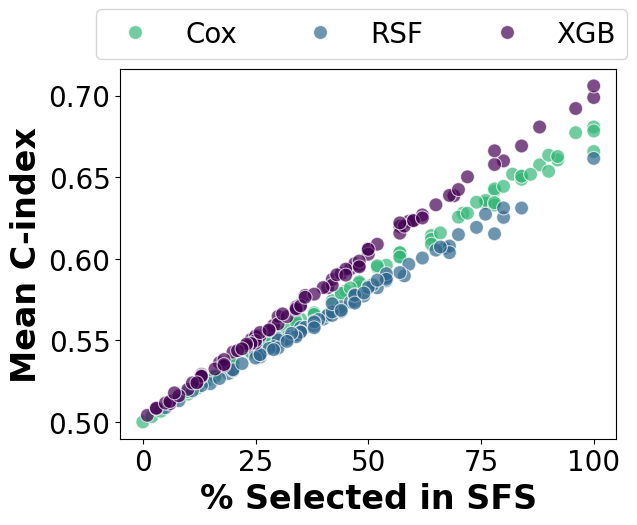

In [2]:
second_iteration_paths = {"Cox": '/home/projects/hornsteinlab/yahelc/R/isoMIRs/isomiRs_II/results/CI_based_2nd/features_stats_over_multiple_runs_2024_11_15_11_57_14.xlsx',
                         "RSF" : '/home/projects/hornsteinlab/yahelc/R/isoMIRs/isomiRs_II/results/CI_based_2nd/features_stats_over_multiple_runs_2024_11_15_11_51_51.xlsx',
                         "XGB" : '/home/projects/hornsteinlab/yahelc/R/isoMIRs/isomiRs_II/results/CI_XGBOOST_iteration/features_stats_over_multiple_runs_2024_11_15_11_57_03.xlsx'}

models = []
CI_means = []
selected = []
for model,path in second_iteration_paths.items():
    tmp_df = pd.read_excel(path,sheet_name = 'summary_mBS_family')

    CIs = tmp_df.all_ci_train.apply(lambda x: pd.Series([float(i.strip(' []')) for i in x.split(',')]))
    mean_across_runs = CIs.mean(axis = 1).tolist()
    CI_means = CI_means + mean_across_runs
    selected = selected + tmp_df['% selected'].tolist()
    current_model = np.repeat(model,len(mean_across_runs)).tolist()
    models = models + current_model


second_iteration_df = pd.DataFrame({'CI' : CI_means,'Selected' : selected, 'model' : models})

viridis = get_cmap("viridis")
categories = second_iteration_df['model'].unique()
color_map = {category: to_hex(viridis(i / len(categories))) for i, category in enumerate(categories)}
xgb_color = color_map['Cox']
color_map['Cox'] = color_map['XGB']
color_map['XGB'] = xgb_color

sns.scatterplot(second_iteration_df, x = 'Selected', y = 'CI', hue='model',
                s =100, alpha = 0.7, palette=color_map)
plt.tick_params(axis='both',which='major',labelsize = 20)
plt.ylabel('Mean C-index',fontsize=24, fontweight='bold')
plt.xlabel('% Selected in SFS',fontsize=24, fontweight='bold')
plt.legend(fontsize=20,bbox_to_anchor=(1.05 ,1.2),ncol = 3)
plt.savefig("graphs/S3b.eps", format='eps', bbox_inches='tight')

### 3rd iteration per loop XGB

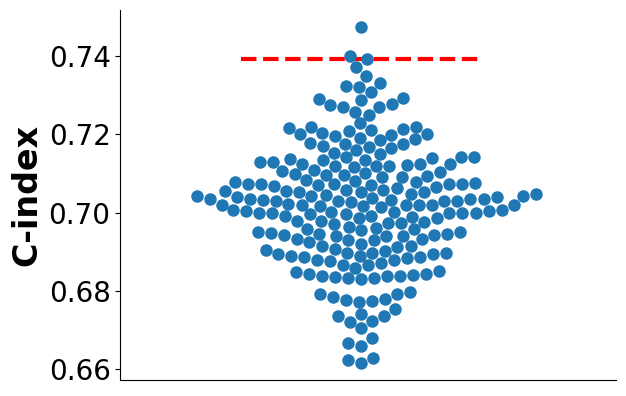

In [3]:
third_iter_path = '/home/projects/hornsteinlab/yahelc/R/isoMIRs/isomiRs_II/results/CI_XGBOOST_iteration/best_model_per_loop_2024_11_15_11_57_03.xlsx'
thersh_path = '/home/projects/hornsteinlab/yahelc/R/isoMIRs/isomiRs_II/results/CI_XGBOOST_iteration/selected_top_features_asof_token_2-0-2-4-_-1-1-_-1-5-_-1-1-_-5-7-_-0-3_created_2024_11_16_11_28_43.xlsx'
beewswarm_df = pd.read_excel(third_iter_path,sheet_name = 'AUC-t')
threshold = pd.read_excel(thersh_path,sheet_name = 'threshold')['score threshold'][0]

ax = sns.swarmplot(data = beewswarm_df, x = 1, y = 'ci_train', s = 9)
plt.tick_params(axis='both',which='major',labelsize = 20)
plt.ylabel('C-index',fontsize=24, fontweight='bold')
plt.xlabel('')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 

ax.hlines(y= threshold-0.0007,xmin = -0.02, xmax = 0.02, 
          linestyles = 'dashed', color = 'red',linewidth=3.0)

sns.despine(top=True, right=True) 
plt.savefig("graphs/S3c.eps", format='eps', bbox_inches='tight')

## loading the data ##

In [2]:
# read the selected features from file in path defined in globals
DT_token = '2024_11_16_11_28_43'# for xgb based CI (DT_token on globals 2024_11_15_11_57_03)

first_round_DT_token_name =   '-'.join(first_round_DT_token)
output_selected_top_features = "selected_top_features_asof_token_{0}_created_{1}.xlsx".format(first_round_DT_token_name, DT_token)
name_N_path_f_output = os.path.join(globals.savefig_path, output_selected_top_features)

name_N_path_f_output = os.path.join('/home/projects/hornsteinlab/yahelc/R/isoMIRs/isomiRs_II/results/CI_XGBOOST_iteration', output_selected_top_features)
extracted_feature_names = pd.read_excel(name_N_path_f_output, sheet_name='Sheet1')['2nd floor selected features']

In [3]:
# read, normalize and subset data
X_train, X_test, y_train, y_test = data_load()
y_test = np.delete(y_test,148)
X_test.drop(['BAC_7_22'],axis =0, inplace = True)

X_train_raw_all, X_test_raw_all = X_train, X_test
X_train_raw, X_test_raw = X_train[extracted_feature_names], X_test[extracted_feature_names]

# filter for releveant isomiRs only and scale & center
X_train, X_test = normalize(X_train, X_test, y_train, y_test, normalize_gt=False)
X_train_filtered, X_test_filtered = X_train[extracted_feature_names], X_test[extracted_feature_names]

float data type
Input:  (154, 2079)
Input: (201, 1999)
output - mutual f only:
(154, 1483)
(201, 1483)


In [4]:
# load continouse/binerized miR-181 and isomiRs data dfs
miR_181_dfs = {}
sheets_list = ['UK_chosen_isomiRs','UK_binary_chosen_isomiRs','PGB_chosen_isomiRs','PGB_binary_chosen_isomiRs']
for loc,df in enumerate(sheets_list):        
    tmp_df = pd.read_excel('cutpoint_dfs_by_median.xlsx',sheet_name=df)
    tmp_df.columns = [
    col.replace("hsa", "isomiR") if "let" in col else
    col.replace("hsa-", "iso") if "miR" in col else col
    for col in tmp_df.columns]
    miR_181_dfs[df] = tmp_df

In [5]:
# get mature names of chosen 
mature_mirs = pd.Series([name[0] for name in X_train_filtered.columns.str.split('\\.')]).unique()
mature_mirs = pd.Series(mature_mirs).tolist()
train_mature, test_mature = mature_data_load(output_censorship=False, output_labels=False,mature_mirs= mature_mirs)

# get clinical/demographical columns
non_mir_columns = [col for col in train_mature.columns if "hsa" not in col]


# filter by chosen columns
train_mature = train_mature[non_mir_columns+mature_mirs]
test_mature = test_mature[non_mir_columns+mature_mirs]

col_rename_dict = {'slope' : 'DeltaFRS','ismale' : 'Sex', 'istreatment' : 'Riluzole treatment',
                    'Age_onset' : 'Age at onset','bulbar_onset' : 'Disease primary site'}
train_mature.rename(col_rename_dict, axis = 1, inplace=True)
test_mature.rename(col_rename_dict, axis = 1, inplace=True)

# drop outlier pateint (by survival) 
test_mature.drop(['BAC_7_22'],axis =0, inplace = True)

non_mir_columns = [col_rename_dict[val] if val in col_rename_dict else val for val in non_mir_columns]

# reorder mature dfs like isomiRs for consistancy with y's
train_mature = train_mature.reindex(X_train_filtered.index)
test_mature = test_mature.reindex(X_test_filtered.index)

train_mature_only_mirs = train_mature[mature_mirs]
test_mature_only_mirs = test_mature[mature_mirs]

# filter canonical data - had no miR-130b-5p canonical left after filtration 
canonical_train = X_train_raw_all[pd.Series(mature_mirs)[pd.Series(mature_mirs) != 'hsa-miR-130b-5p']]
canonical_test = X_test_raw_all[pd.Series(mature_mirs)[pd.Series(mature_mirs) != 'hsa-miR-130b-5p']]

# filter by chosen columns for clinical data
train_clinical = train_mature[non_mir_columns]
test_clinical = test_mature[non_mir_columns]

In [6]:
train_nfl_df = pd.read_excel('UK_full_with_NfL.xlsx', index_col = 'ID')

train_nfl_df= train_nfl_df[~train_nfl_df['NfL SIMOA'].isnull()]

train_nfl_df.columns = [col.replace("hsa", "isomiR") if "let" in col else
    col.replace("hsa-", "iso") if "miR" in col else col
    for col in train_nfl_df.columns]

train_nfl_df.columns.values[train_nfl_df.shape[1]-1] = 'NfL median'
isomiRs_median_train = miR_181_dfs['UK_chosen_isomiRs'].iloc[:,:18].median(axis = 0)

nfl_df_cont = copy.deepcopy(train_nfl_df)
train_nfl__filtered_df = train_nfl_df[train_nfl_df.index.isin(X_train.index)]

for iso,med in isomiRs_median_train.items():
    train_nfl_df[iso] = (train_nfl_df[iso]> med).astype(int)
    
# train_nfl_df['nfl_terciles'] = train_nfl_df['NfL median']

train_nfl_df['NfL median'] = (train_nfl_df['NfL median'] > train_nfl_df['NfL median'].median()).astype(int)

#train_nfl_df["nfl_terciles"] = pd.qcut(train_nfl_df["nfl_terciles"], q=3, labels=[0, 1, 2],duplicates='drop')

test_nfl__filtered_df = pd.read_excel('Hornstein PGB - baseline serum NfL (2025.03.16).xlsx',
                                      index_col = 'ID').drop(index = 'BAC_7_22',inplace = False)
test_nfl__filtered_df = test_nfl__filtered_df.loc[X_test_raw.index]

surv_values_test = miR_181_dfs['PGB_chosen_isomiRs'].drop(index = 148)[['outcome','Survival.from.onset','Survival.from.enrolment']]
surv_values_test.index = test_nfl__filtered_df.index

test_nfl__filtered_df = pd.concat([X_test_raw,surv_values_test,test_nfl__filtered_df['NfL_s']], axis = 1)
test_nfl__filtered_df.columns = train_nfl__filtered_df.columns

In [7]:
# load controls data
CTL_df = pd.read_table('corrected_umi_counts_CTL.txt')
mature_let7_ctl = CTL_df.filter(regex = 'let-7g')
mature_let7_ctl = mature_let7_ctl.sum(axis = 1)

CTL_df_test = pd.read_csv('CTL_GENFI_corrected.csv', index_col='Unnamed: 0')

C9_train = pd.read_csv('C9_status_UK.csv', index_col='patient').replace({"Negative":"Non-carrier",
                                                                         "Not done" : 'Non-carrier',
                                                                        'Positive': 'Carrier'})

C9_test = pd.read_excel('Cohen Isoforms - C9 status (2025.07.28).xlsx', index_col = 'patient').replace({0:"Non-carrier",
                                                                                                        1: 'Carrier'})
C9_test.drop(columns = 'ID', inplace = True)

In [10]:
actual_survival_times = True
# define times to calculate CI and AUC later
lower_bound_prediction_time = y_train[survival_name2].min()
upper_bound_prediction_time = y_train[survival_name2].max()
lower_time = y_test[survival_name2].min()
upper_time = y_test[survival_name2].max()

if not actual_survival_times:
    lower_bound_prediction_time = max(lower_bound_prediction_time+2,lower_time)
    upper_bound_prediction_time = min(upper_bound_prediction_time - 2, upper_time)
    prediction_vector_times = np.arange(round(lower_bound_prediction_time), round(upper_bound_prediction_time))
else:
    prediction_vector_times_test = np.sort(np.unique(np.ceil(y_test[survival_name2])))
    prediction_vector_times_test = np.delete(prediction_vector_times_test, -1)
    prediction_vector_times_train = np.sort(np.unique(np.ceil(y_train[survival_name2])))
    prediction_vector_times_train = np.delete(prediction_vector_times_train, -1)

In [11]:
main_model = GradientBoostingSurvivalAnalysis()
main_model.set_params(n_estimators= 20, learning_rate=0.5,  max_depth=2, subsample = 0.3,  #scale_pos_weight = 0.1 - non v
                    loss= 'coxph', #{'coxph', 'squared', 'ipcwls'}, optional, default: 'coxph')
                    criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                    min_weight_fraction_leaf=0.0, min_impurity_decrease=0.0,
                    max_features=None, max_leaf_nodes=None, validation_fraction=0.1, n_iter_no_change=None,
                    tol=0.0001, dropout_rate=0.3, verbose=1, ccp_alpha=0.0,
                    random_state=42 )

## cross validation specific for survival so test times will be part of train times
cv = InclusiveSurvivalKFold(n_splits=5)
main_model.fit(X_train_filtered,y_train)
main_model.score(X_train_filtered, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1         130.3135           0.0000            0.06s
         2         125.8786          -4.8413            0.05s
         3         128.0970           3.4438            0.03s
         4         123.6365          -4.0146            0.03s
         5         125.0056           4.8029            0.02s
         6         130.6062          10.2931            0.02s
         7         127.1752          -0.6790            0.02s
         8         126.9405          -7.5356            0.02s
         9         126.3139           7.8328            0.02s
        10         122.4326          -9.2604            0.01s
        20         121.7133          15.3828            0.00s


0.718268651579038

## hyperparameter tuning ##

In [47]:
#Tune hyperparameters models
tune_parameters = False
if tune_parameters:
    tuned_rf_params, best_rf_score,baseline_score_rf =  tune_hyperparameters_xgb(X_train_filtered,y_train,cv,
                                                                        eval_metric='CI',n_trials=1000)
else:
               
    tuned_rf_params = {'n_estimators': 95, 'learning_rate': 0.1, 'max_depth': 35,
     'subsample': 0.4545454545454545, 'loss': 'coxph', 'criterion': 'friedman_mse',
     'min_samples_split': 60, 'min_samples_leaf': 20, 'min_weight_fraction_leaf': 0.060461799614030046,
     'min_impurity_decrease': 0.6, 'max_features': 0.1111111111111111,
     'max_leaf_nodes': 100, 'validation_fraction': 0.1,
     'n_iter_no_change': None, 'tol': 0.0001, 'dropout_rate': 0.016,
     'verbose': 1, 'ccp_alpha': 0.1, 'random_state': 42}
    best_rf_score = 0.725  
    
tuned_model = GradientBoostingSurvivalAnalysis(**tuned_rf_params)

# look at model preformace from 4 months and above in train/test
tuned_model.fit(X_train_filtered,y_train)
CI_train = concordance_index_censored(y_train[death_name], y_train[survival_name2], tuned_model.predict(X_train_filtered))
AUC_train = cumulative_dynamic_auc(y_train, y_train, tuned_model.predict(X_train_filtered), prediction_vector_times_train[2:])


CI_test = concordance_index_censored(y_test[death_name], y_test[survival_name2], tuned_model.predict(X_test_filtered))
AUC_test = cumulative_dynamic_auc(y_train, y_test, tuned_model.predict(X_test_filtered), prediction_vector_times_test[2:])


print(f'train/test CIs are {np.round(CI_train[0],2)} & {np.round(CI_test[0],2)} accordingly.\n' \
     f'also train/test average AUCs across time are {np.round(AUC_train[1],2)} & {np.round(AUC_test[1],2)}')

# plot_AUC(times = prediction_vector_times_train[2:],times_test = prediction_vector_times_test[2:],
#          auc_test = AUC_test, auc_train = AUC_train,
#          xlab = "Months from enrollment", ylab = "Time-dependent AUC",
#         pad = [1.12, 1.22], labels_size=24, ticks_size=20, legend=False)

# # plt.savefig("graphs/2a.eps", format='eps', bbox_inches='tight')
# plt.title('isomiRs', fontdict={'fontsize' : 24,
#                            'fontweight' : 'bold'},
#          pad=50)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1         215.4273           0.0000            0.08s
         2         220.8947           5.4613            0.08s
         3         218.4996          -2.3916            0.08s
         4         215.1373          -3.4351            0.08s
         5         220.6086           6.6338            0.08s
         6         219.3251          -1.1444            0.08s
         7         216.2601          -3.2080            0.08s
         8         222.4581           6.2434            0.09s
         9         222.2148          -0.3403            0.09s
        10         223.6016           2.9235            0.09s
        20         220.4090          -1.4885            0.11s
        30         220.0189          -0.5873            0.12s
        40         222.0777          10.0807            0.13s
        50         218.4673           2.1334            0.13s
        60         214.3210          -1.0346            0.11s
       

## Fit XGB model for miRNA/ refrence miRNA 

In [48]:
# for miRNA model
mature_model = GradientBoostingSurvivalAnalysis(**tuned_rf_params)
    
mature_model.fit(train_mature_only_mirs,y_train)
CI_train_mature = concordance_index_censored(y_train[death_name], y_train[survival_name2], mature_model.predict(train_mature_only_mirs))
AUC_train_mature = cumulative_dynamic_auc(y_train, y_train, mature_model.predict(train_mature_only_mirs), prediction_vector_times_train[2:])
ImBS_train_mature = my_ImBS(mature_model, train_mature_only_mirs, y_train, y_train, surv_name=survival_name2)

CI_test_mature = concordance_index_censored(y_test[death_name], y_test[survival_name2], mature_model.predict(test_mature_only_mirs))
AUC_test_mature = cumulative_dynamic_auc(y_train, y_test, mature_model.predict(test_mature_only_mirs), prediction_vector_times_test[2:])
ImBS_test_mature = my_ImBS(mature_model, test_mature_only_mirs, y_test, y_train, surv_name=survival_name2)

print(f'train/test CIs are {np.round(CI_train_mature[0],2)} & {np.round(CI_test_mature[0],2)} accordingly.\n' \
     f'also train/test average AUCs across time are {np.round(AUC_train_mature[1],2)} & {np.round(AUC_test_mature[1],2)} \n' \
     f'finally train/test ImBSs are {np.round(ImBS_train_mature,2)} & {np.round(ImBS_test_mature,2)}')

# plot_AUC(times = prediction_vector_times_train[2:],times_test = prediction_vector_times_test[2:],
#          auc_test = AUC_test_mature,auc_train = AUC_train_mature,
#          ref_auc_test=None, ref_auc_train=None,model = 'miRNA prediction',
#         xlab = "Months from enrollment", ylab = "Time-dependent AUC",labels_size=24, ticks_size=20)
# plt.title('miRNA', fontdict={'fontsize' : 24,
#                            'fontweight' : 'bold'},
#          pad=60)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1         215.4273           0.0000            0.07s
         2         220.8947           5.4613            0.07s
         3         218.9181          -2.6593            0.07s
         4         215.7656          -3.5287            0.07s
         5         221.1817           5.9042            0.08s
         6         220.3931          -0.6441            0.08s
         7         216.3707          -2.8080            0.08s
         8         222.8993           6.0693            0.08s
         9         222.1208          -0.5517            0.09s
        10         223.2646           3.4429            0.09s
        20         220.9441          -1.4380            0.11s
        30         221.1429          -0.7884            0.12s
        40         222.6898           9.2137            0.13s
        50         220.3129           1.7282            0.13s
        60         216.7469          -1.6716            0.11s
       

In [49]:
# for Reference miRNA model
canonical_model = GradientBoostingSurvivalAnalysis(**tuned_rf_params)
    
canonical_model.fit(canonical_train,y_train)
CI_train_canonical = concordance_index_censored(y_train[death_name], y_train[survival_name2], canonical_model.predict(canonical_train))
AUC_train_canonical = cumulative_dynamic_auc(y_train, y_train, canonical_model.predict(canonical_train), prediction_vector_times_train[2:])
ImBS_train_canonical = my_ImBS(canonical_model, canonical_train, y_train, y_train, surv_name=survival_name2)

CI_test_canonical = concordance_index_censored(y_test[death_name], y_test[survival_name2], canonical_model.predict(canonical_test))
AUC_test_canonical = cumulative_dynamic_auc(y_train, y_test, canonical_model.predict(canonical_test), prediction_vector_times_test[2:])
ImBS_test_canonical = my_ImBS(canonical_model, canonical_test, y_test, y_train, surv_name=survival_name2)

print(f'train/test CIs are {np.round(CI_train_canonical[0],2)} & {np.round(CI_test_canonical[0],2)} accordingly.\n' \
     f'also train/test average AUCs across time are {np.round(AUC_train_canonical[1],2)} & {np.round(AUC_test_canonical[1],2)} \n' \
     f'finally train/test ImBSs are {np.round(ImBS_train_canonical,2)} & {np.round(ImBS_test_canonical,2)}')

# plot_AUC(times = prediction_vector_times_train[2:],times_test = prediction_vector_times_test[2:],
#          auc_test = AUC_test_canonical,auc_train = AUC_train_canonical,
#          ref_auc_test=None, ref_auc_train=None,model = 'Reference miRNA prediction',
#         pad = [1.02,1.2],xlab = "Months from enrollment", ylab = "Time-dependent AUC",labels_size=24, ticks_size=20)
# plt.title('Reference miRNA', fontdict={'fontsize' : 24,
#                            'fontweight' : 'bold'},
#          pad=60)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1         215.4273           0.0000            0.08s
         2         220.8947           5.4613            0.09s
         3         218.9181          -2.6593            0.08s
         4         215.0576          -3.4490            0.08s
         5         220.8596           6.3637            0.08s
         6         220.0437          -0.7047            0.09s
         7         216.7387          -3.4361            0.09s
         8         223.0893           6.2881            0.09s
         9         222.5842          -0.5638            0.09s
        10         223.7597           2.8094            0.09s
        20         220.8455          -1.4654            0.11s
        30         220.9493          -0.7328            0.12s
        40         223.1581           9.5883            0.13s
        50         220.1094           1.8209            0.12s
        60         216.7018          -1.2899            0.11s
       

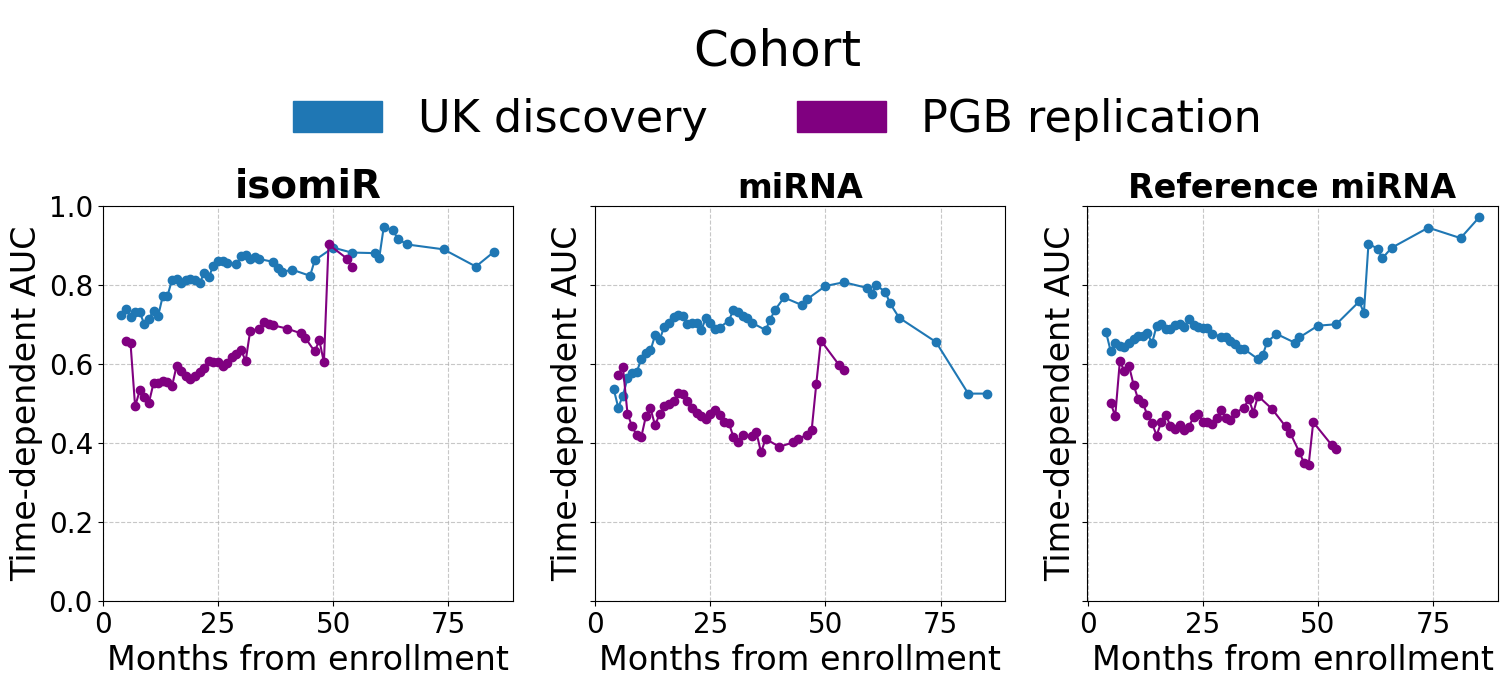

In [50]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

plot_AUC(times = prediction_vector_times_train[2:],times_test = prediction_vector_times_test[2:],
         auc_test = AUC_test, auc_train = AUC_train,
         xlab = "Months from enrollment", ylab = "Time-dependent AUC",
        pad = [1.12, 1.22], labels_size=24, ticks_size=20, legend=False, ax=axes[0])
axes[0].set_title('isomiR', fontsize=28, fontweight='bold')

plot_AUC(times = prediction_vector_times_train[2:],times_test = prediction_vector_times_test[2:],
         auc_test = AUC_test_mature,auc_train = AUC_train_mature,
         ref_auc_test=None, ref_auc_train=None,model = 'miRNA prediction',
        xlab = "Months from enrollment", ylab = "Time-dependent AUC",
         labels_size=24,legend=False, ticks_size=20, ax=axes[1])
axes[1].set_title('miRNA', fontsize=24, fontweight='bold')

plot_AUC(times = prediction_vector_times_train[2:],times_test = prediction_vector_times_test[2:],
         auc_test = AUC_test_canonical,auc_train = AUC_train_canonical,
         ref_auc_test=None, ref_auc_train=None,model = 'Reference miRNA prediction',
        pad = [1.02,1.2],xlab = "Months from enrollment", ylab = "Time-dependent AUC",
         labels_size=24, ticks_size=20, legend= False, ax=axes[2])
axes[2].set_title('Reference miRNA', fontsize=24, fontweight='bold')

uk_patch = mpatches.Patch(color='C0', label='UK discovery')
pgb_patch = mpatches.Patch(color='purple', label='PGB replication')

fig.legend(handles=[uk_patch, pgb_patch],
           loc='lower center',
           bbox_to_anchor=(0.5, 0.95),
           ncol=2,
           fontsize=32,
           title='Cohort',
           title_fontsize=36,
           frameon=False)

plt.subplots_adjust(top=0.9)
# plt.tight_layout()

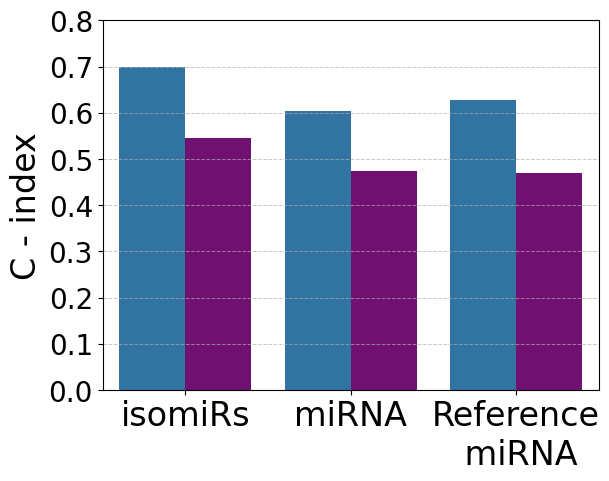

In [55]:
miR_ci_df = pd.DataFrame({"score" : [CI_train[0],CI_test[0],CI_train_mature[0],CI_test_mature[0],
                                    CI_train_canonical[0],CI_test_canonical[0]],
             "cohort": ['UK discovery','PGB replication'] *3,
             "model" : np.repeat(['isomiRs','miRNA','Reference\n miRNA'],2)})

miR_AUC_df = pd.DataFrame({"score" : [AUC_train[1],AUC_test[1],AUC_train_mature[1],AUC_test_mature[1],
                                     AUC_train_canonical[1],AUC_test_canonical[1]],
             "cohort": ['UK discovery','PGB replication'] *3,
             "model" : np.repeat(['isomiRs','miRNA','Reference\n miRNA'],2)})

# for C-index
sns.barplot(miR_ci_df, y = 'score', x = 'model', hue = 'cohort', palette=['#1f77b4','purple'], legend=False)

plt.yticks(fontsize=20)
plt.xlabel('',fontsize=18)
plt.ylabel('C - index',fontsize=24)
plt.ylim(0,0.8)
plt.xticks(fontsize=24)
# plt.legend(
#     title='',  # Add a title for clarity (optional)
#     title_fontsize=14,
#     fontsize=20,
#     loc='upper center',  # Position it at the upper center
#     bbox_to_anchor=(0.5, 1.22),  # Move it lower (y = -0.15 moves it below the plot)
#     ncol=2  # Arrange legend in two columns
# )
plt.grid(visible=True, which="major", axis="y", linestyle="--", linewidth=0.7, alpha=0.7)


# plt.savefig("graphs/2c.eps", format='eps', bbox_inches='tight')

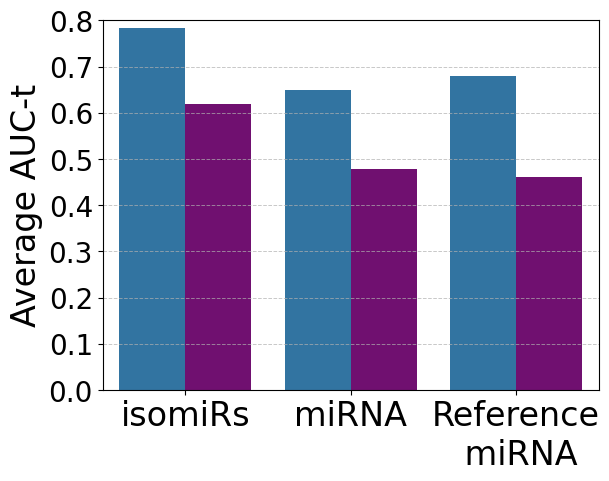

In [56]:
# for AUC-t
sns.barplot(miR_AUC_df, y = 'score', x = 'model', hue = 'cohort', palette=['#1f77b4','purple'],legend=False)

plt.yticks(fontsize=20)
plt.xlabel('',fontsize=18, fontweight='bold')
plt.ylabel('Average AUC-t',fontsize=24)
plt.ylim(0,0.8)
plt.xticks(fontsize=24)
# plt.legend(
#     title='',  # Add a title for clarity (optional)
#     title_fontsize=14,
#     fontsize=20,
#     loc='upper center',  # Position it at the upper center
#     bbox_to_anchor=(0.5, 1.22),  # Move it lower (y = -0.15 moves it below the plot)
#     ncol=2  # Arrange legend in two columns
# )
plt.grid(visible=True, which="major", axis="y", linestyle="--", linewidth=0.7, alpha=0.7)
# plt.savefig("graphs/2b.eps", format='eps', bbox_inches='tight')

## SHAP Feature importance ##

In [57]:
explainer = shap.KernelExplainer(lambda x: rsf_predict_risk(x, times=prediction_vector_times_train, model=tuned_model),
                                 X_train_filtered)
calculate_shap = False

if calculate_shap:
    shap_values_test = explainer.shap_values(X_test_filtered, nsamples=X_test_filtered.shape[0])
    shap_values_train = explainer.shap_values(X_train_filtered, nsamples=X_train_filtered.shape[0])
else:
    with open("shap_train.pkl", "rb") as f:
        shap_values_train = pickle.load(f)
    with open("shap_test.pkl", "rb") as f:
        shap_values_test = pickle.load(f)


/home/projects/hornsteinlab/yahelc/miniconda3/envs/isomiRs_II/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingSurvivalAnalysis was fitted with feature names
  warnings.warn(
Using 154 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


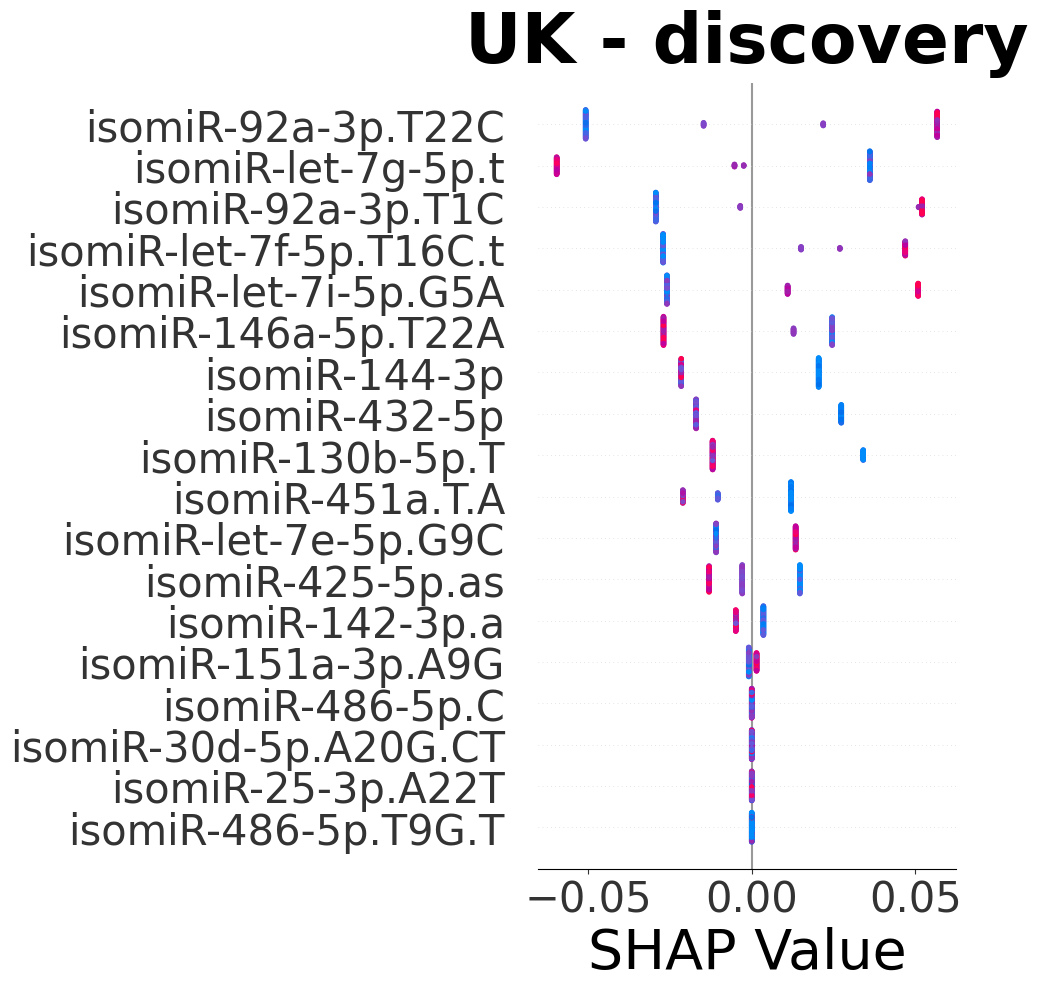

In [58]:
custom_feature_names = [
    col.replace("hsa", "isomiR") if "let" in col else
    col.replace("hsa-", "iso") if "miR" in col else col
    for col in X_train_filtered.columns
]

shap.summary_plot(shap_values_train, X_train_filtered, show = False, 
                 feature_names=custom_feature_names)
# Access the current figure and axes
fig = plt.gcf()
ax = plt.gca()

# Customize axes, labels, or title
ax.set_title("UK - discovery", fontsize=50, fontweight='bold',pad=15)
ax.set_ylabel("")
ax.set_xlabel("SHAP Value", fontsize=40)
ax.tick_params(axis='y', which='major', labelsize=30)
ax.tick_params(axis='x', which='major', labelsize=30)

# Remove the colorbar axis — usually the second axis
if len(fig.axes) > 1:
    fig.delaxes(fig.axes[1])
# plt.savefig("graphs/2d.eps", format='eps', bbox_inches='tight')

Text(675.3598611111112, 0.5, 'Feature Value')

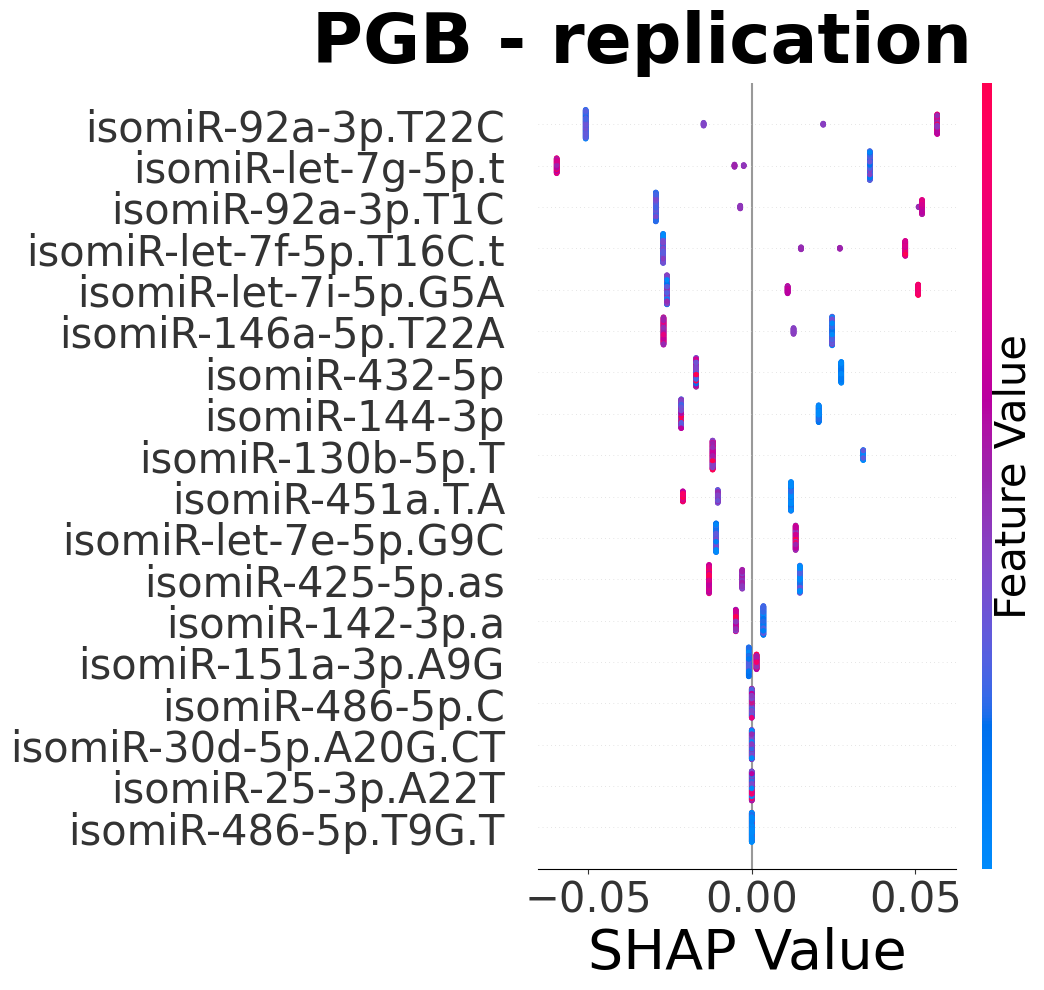

In [59]:
shap.summary_plot(shap_values_test, X_test_filtered, show = False, 
                 feature_names=custom_feature_names,color=None)
# Access the current figure and axes
fig = plt.gcf()
ax = plt.gca()

# Customize axes, labels, or title

ax.set_title("PGB - replication", fontsize=50, fontweight='bold',pad=15)
ax.title.set_position([0.25, 1.0])
ax.set_ylabel("")
ax.set_xlabel("SHAP Value", fontsize=40)
ax.tick_params(axis='y', which='major', labelsize=30)
ax.tick_params(axis='x', which='major', labelsize=30)


cbar = [obj for obj in fig.axes if isinstance(obj, plt.Axes)][-1]  # last axis is usually the colorbar
cbar.set_xticks([])  # remove tick labels (for horizontal colorbar)
cbar.set_yticks([])  # in case it's vertical

fig.axes[-1].set_ylabel('Feature Value',fontsize = 30)
# plt.savefig("graphs/2e.eps", format='eps', bbox_inches='tight')

## get weights based on SHAP for isomiR feature engnieering

                              HRs                  feature
isomiR-486-5p.T9G.T      1.000000      isomiR-486-5p.T9G.T
isomiR-25-3p.A22T        1.000000        isomiR-25-3p.A22T
isomiR-30d-5p.A20G.CT    1.000000    isomiR-30d-5p.A20G.CT
isomiR-486-5p.C          1.000000          isomiR-486-5p.C
isomiR-151a-3p.A9G       1.002012       isomiR-151a-3p.A9G
isomiR-142-3p.a          0.992361          isomiR-142-3p.a
isomiR-425-5p.as         0.982132         isomiR-425-5p.as
isomiR-let-7e-5p.G9C     1.023477     isomiR-let-7e-5p.G9C
isomiR-451a.T.A          0.972053          isomiR-451a.T.A
isomiR-130b-5p.T         0.976674         isomiR-130b-5p.T
isomiR-432-5p            0.973912            isomiR-432-5p
isomiR-144-3p            0.967994            isomiR-144-3p
isomiR-146a-5p.T22A      0.952870      isomiR-146a-5p.T22A
isomiR-let-7i-5p.G5A     1.058642     isomiR-let-7i-5p.G5A
isomiR-let-7f-5p.T16C.t  1.064200  isomiR-let-7f-5p.T16C.t
isomiR-92a-3p.T1C        1.076830        isomiR-92a-3p.T

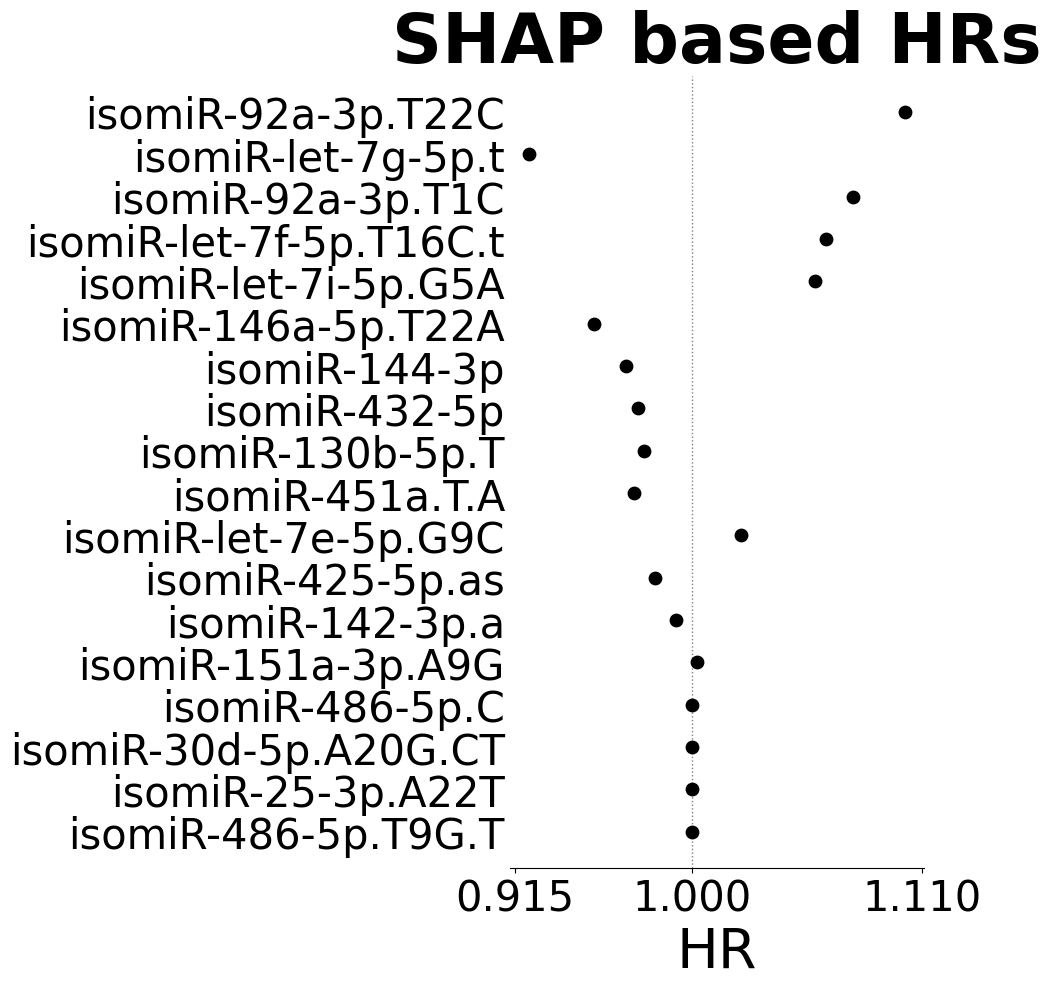

In [60]:
XGB_hrs = []
calculate_CI = False
for i in range(shap_values_train.shape[1]):
    mean_shap_high = np.mean(shap_values_train[:,i][X_train_raw.iloc[:,i] >= X_train_raw.iloc[:,i].mean()])
    mean_shap_low = np.mean(shap_values_train[:,i][X_train_raw.iloc[:,i] < X_train_raw.iloc[:,i].mean()])
    XGB_hrs.append(np.exp(mean_shap_high) / np.exp(mean_shap_low))

ranked_shaps  = pd.Series(np.abs(shap_values_train).mean(axis=0), index=custom_feature_names).sort_values(ascending=True)
        
XGB_hrs = pd.DataFrame({'HRs': XGB_hrs,
              'feature' : custom_feature_names})

XGB_hrs.index = custom_feature_names
XGB_hrs = XGB_hrs.loc[ranked_shaps.index]

print(XGB_hrs)

plt.figure(figsize = (10,10))
plot_forest(XGB_hrs,'HRs','HRs','HRs',middle_line = 1,yticks_size=30,
            bold_ticks= False,xticks_size = 30,
            main_title = "SHAP based HRs",x_size=40,title_size=50,dotsize = 80,
            sort_HR=False,y_ticks = "feature", log2=False ,X_title='HR',
            remove_frame = True, limit_num=True)

# plt.savefig("graphs/2f.eps", format='eps', bbox_inches='tight')

# compare isomiRs to NfL and miR-181

[{'Feature': 'isomiR-let-7g-5p.t',
  'Log-rank p-value': 1.5128923711801015e-05,
  'C-index': 0.5981843214869632,
  'Hazard Ratio': 0.4828000522813956,
  'HR p-value': 2.13259395172587e-05,
  'Confidance interval':           0
  0  0.345103
  1  0.675438}]

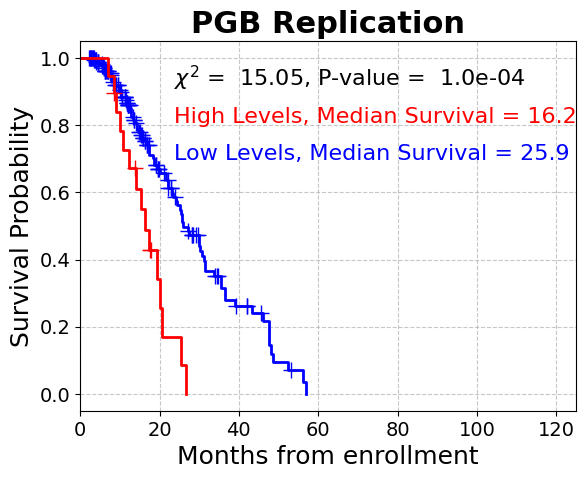

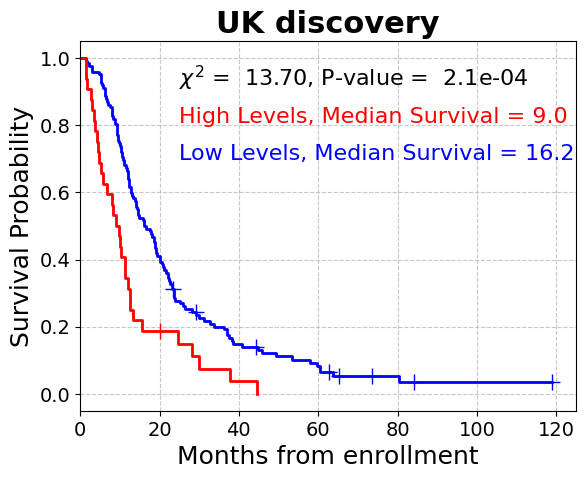

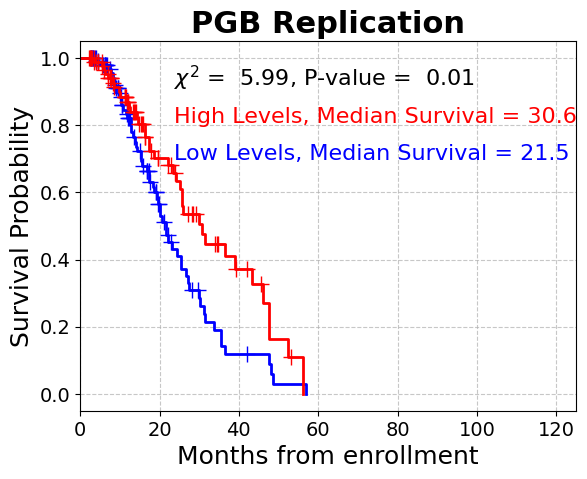

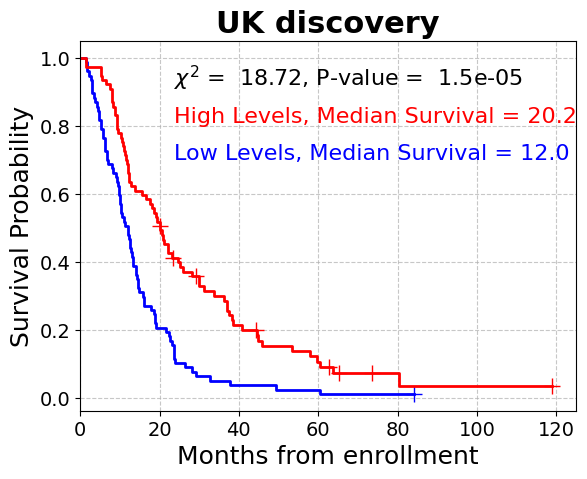

In [33]:
cohort_title = 'PGB Replication'
KM_plots(miR_181_dfs['PGB_binary_chosen_isomiRs'].drop(index = 148),
                               ['miR-181'],cohort_title=cohort_title, combine_plots=False,
                               km_stats_loc = [0.19, 0.94],
                               high_text_loc = [0.19, 0.78],
                               low_text_loc = [0.19, 0.68],
                            x_title = 'Months from enrollment',xlim = [0,125],text_size = 16)

# plt.savefig("graphs/4b.eps", format='eps', bbox_inches='tight')

KM_plots(miR_181_dfs['UK_binary_chosen_isomiRs'],
                               ['miR-181'],cohort_title='UK discovery', combine_plots=False,
                               km_stats_loc = [0.2, 0.94],
                               high_text_loc = [0.2, 0.78],
                               low_text_loc = [0.2, 0.68],
                            x_title = 'Months from enrollment',xlim = [0,125],text_size = 16)

# plt.savefig("graphs/4a.eps", format='eps', bbox_inches='tight')

KM_plots(miR_181_dfs['PGB_binary_chosen_isomiRs'].drop(index = 148),
                               ['isomiR-let-7g-5p.t'],cohort_title=cohort_title, combine_plots=False,
                               km_stats_loc = [0.19, 0.94],
                               high_text_loc = [0.19, 0.78],
                               low_text_loc = [0.19, 0.68],
                            x_title = 'Months from enrollment',xlim = [0,125],text_size = 16)

# plt.savefig("graphs/1f.eps", format='eps', bbox_inches='tight')

KM_plots(miR_181_dfs['UK_binary_chosen_isomiRs'],
                               ['isomiR-let-7g-5p.t'],cohort_title='UK discovery', combine_plots=False,
                               km_stats_loc = [0.19, 0.94],
                               high_text_loc = [0.19, 0.78],
                               low_text_loc = [0.19, 0.68],
                            x_title = 'Months from enrollment',xlim = [0,125],text_size = 16)

# plt.savefig("graphs/1e.eps", format='eps', bbox_inches='tight')

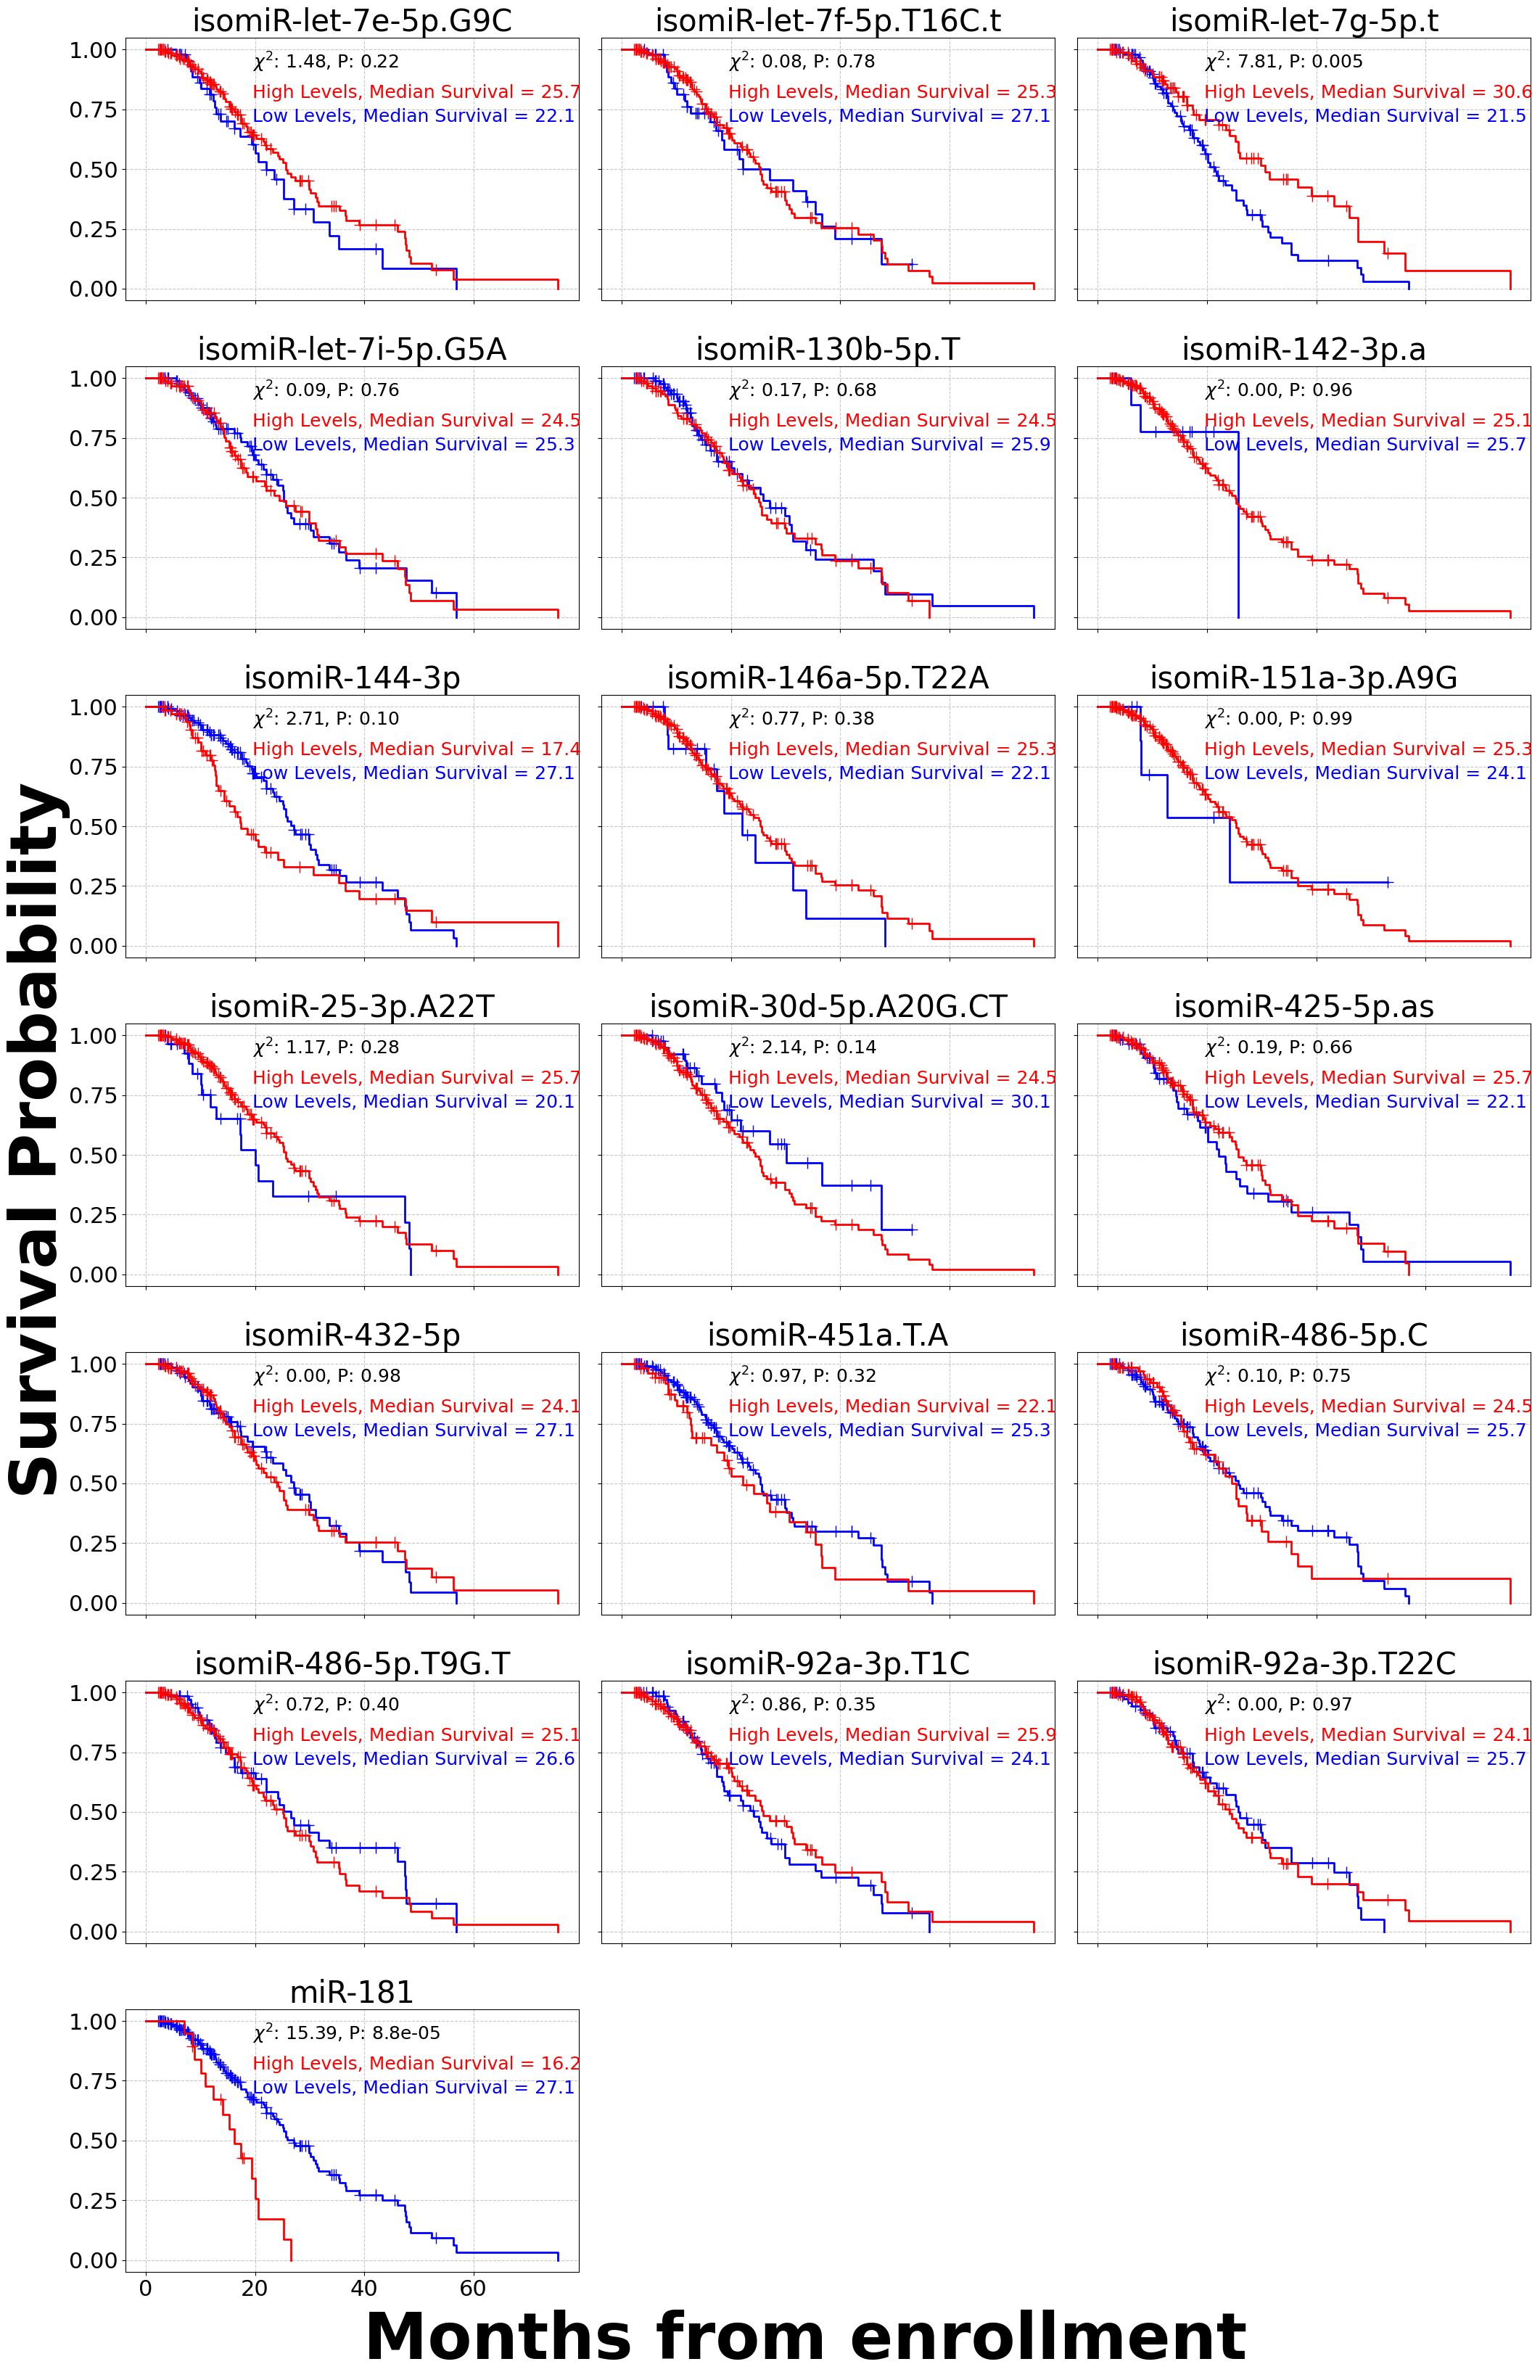

In [35]:
feature_cols = miR_181_dfs['PGB_binary_chosen_isomiRs'].columns[:-3]
#feature_cols = feature_cols[[2,11,6,7,5,4,13,0,9,10,14,12,8,15,1,3,17,16]]
cohort_title = 'PGB replication'

replication_uni_cox = KM_plots(miR_181_dfs['PGB_binary_chosen_isomiRs'],
                               feature_cols,cohort_title=cohort_title, combine_plots=True,
                               km_stats_loc = [0.28, 0.95],
                               high_text_loc = [0.28, 0.77],
                               low_text_loc = [0.28, 0.68],
                              x_title = 'Months from enrollment', cols = 3, text_size=18,
                            sub_height= 40, sub_width= 25,wsapce=0.05, hspace=0.25,
                             combine_title_x = [64,0.5, 0.08], combine_title_y=[64,0.06, 0.5])
# plt.savefig("graphs/S6b.eps", format='eps', bbox_inches='tight',dpi=300)

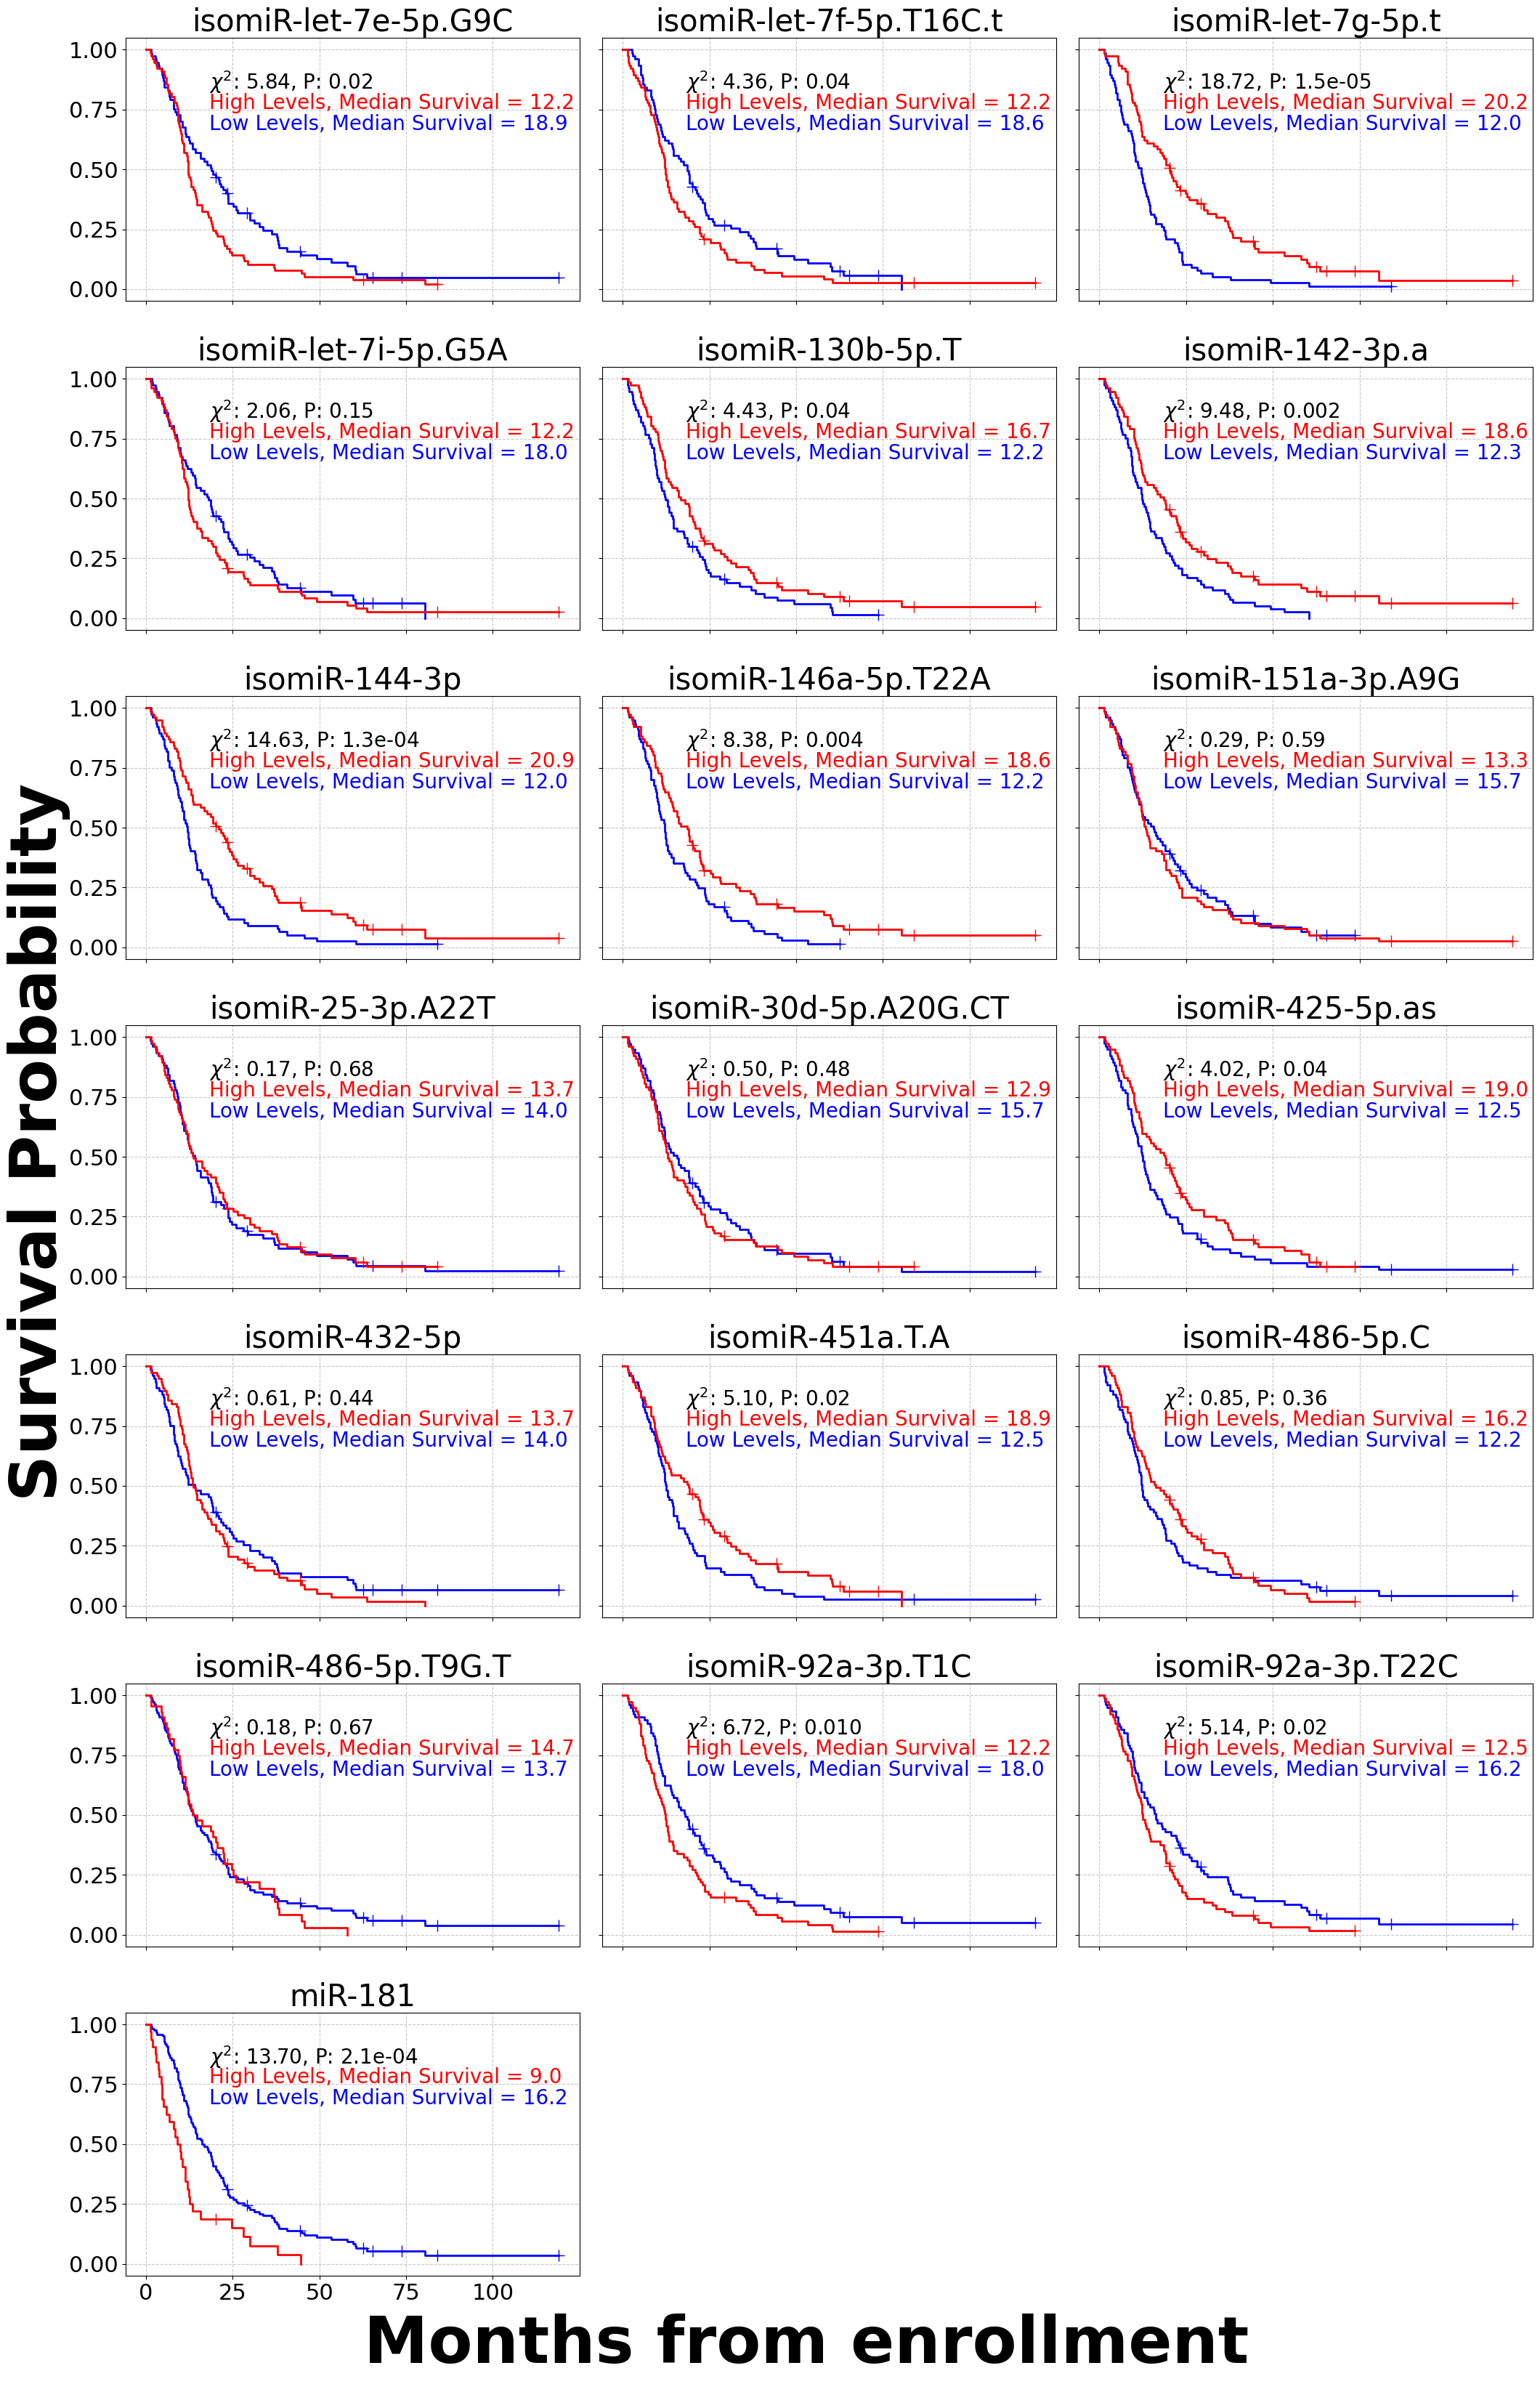

In [36]:
discovery_uni_cox = KM_plots(miR_181_dfs['UK_binary_chosen_isomiRs'],
                               feature_cols,cohort_title=cohort_title, combine_plots=True,
                               km_stats_loc = [0.185, 0.88],
                               high_text_loc = [0.185, 0.73],
                               low_text_loc = [0.185, 0.65],
                            x_title = 'Months from enrollment',cols = 3, text_size=20,
                            sub_height= 40, sub_width= 25,wsapce=0.05, hspace=0.25,
                             combine_title_x = [64,0.5, 0.08], combine_title_y=[64,0.06, 0.5])
# plt.savefig("graphs/S6a.eps", format='eps', bbox_inches='tight',dpi=300)

In [37]:
uni_HRs_df = pd.DataFrame({'features' : [i['Feature'] for i in discovery_uni_cox],
'HRs' : [i['Hazard Ratio'] for i in discovery_uni_cox],
'confi_lower' : [i['Confidance interval'].iloc[0,0] for i in discovery_uni_cox],
'confi_upper' : [i['Confidance interval'].iloc[1,0] for i in discovery_uni_cox]})



uni_HRs_df.sort_values(by = 'HRs',ascending = True,inplace=True)

uni_HRs_df_rep = pd.DataFrame({'features' : [i['Feature'] for i in replication_uni_cox],
'HRs' : [i['Hazard Ratio'] for i in replication_uni_cox],
'confi_lower' : [i['Confidance interval'].iloc[0,0] for i in replication_uni_cox],
'confi_upper' : [i['Confidance interval'].iloc[1,0] for i in replication_uni_cox]})



uni_HRs_df_rep = uni_HRs_df_rep.loc[uni_HRs_df.index]

uni_HRs_df_rep.reset_index(inplace=True, drop = True)
uni_HRs_df.reset_index(inplace=True, drop = True)

## Univariate cox for all isomiRs in UK

290


Text(0.5, 1.0, 'Discovery UK')

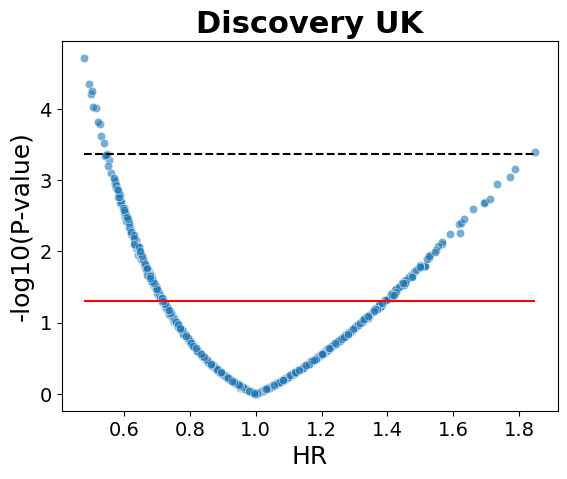

In [38]:
run_univarite_all = False 
X_train_raw_all_surv = pd.concat([X_train_raw_all.reset_index(drop = True),
                             miR_181_dfs['UK_chosen_isomiRs'][['outcome','Survival.from.enrolment']]],
                            axis = 1)
X_train_raw_all_surv.index = X_train_raw_all.index


X_replication_filtered = X_test_raw_all[X_train_raw_all_surv.columns[:-2]]
X_replication_filtered = pd.concat([X_replication_filtered.reset_index(drop = True),
                             miR_181_dfs['PGB_chosen_isomiRs'][['outcome',
                                                                'Survival.from.enrolment']].drop(index = 148).reset_index(drop = True)],
                            axis = 1)

X_replication_filtered.index = X_replication_filtered.index

if run_univarite_all:

    results_uni_binary = cox_univariate_binarization(X_train_raw_all_surv,X_replication_filtered,
                               'Survival.from.enrolment','outcome', 'median')
    results_uni_binary.index = results_uni_binary.Feature
    results_uni_binary.to_csv('Binary_univariate_cox_all.csv')
else:
    results_uni_binary = pd.read_csv('Binary_univariate_cox_all.csv', index_col= 'Feature.1')

print(sum(results_uni_binary['P-value'] <= 0.05))


sns.scatterplot(results_uni_binary, x = 'HR', y = -np.log10(results_uni_binary['P-value']), alpha = 0.6)
plt.hlines(-np.log10(0.05), np.min(results_uni_binary['HR']),
           np.max(results_uni_binary['HR']),colors = 'red')

plt.hlines(-np.log10(0.000426), np.min(results_uni_binary['HR']),
           np.max(results_uni_binary['HR']),colors = 'black',linestyles='dashed')
plt.ylabel("-log10(P-value)", size = 18)
plt.xlabel("HR",size = 18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title("Discovery UK", fontsize=22,fontweight = 'bold')

# plt.savefig("graphs/1b.eps", format='eps', bbox_inches='tight')

/tmp/ipykernel_3561701/3838186086.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_fdr_uni.fillna(1,inplace= True)
/tmp/ipykernel_3561701/3838186086.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_fdr_uni.sort_values(by = 'HR', ascending=False, inplace=True)


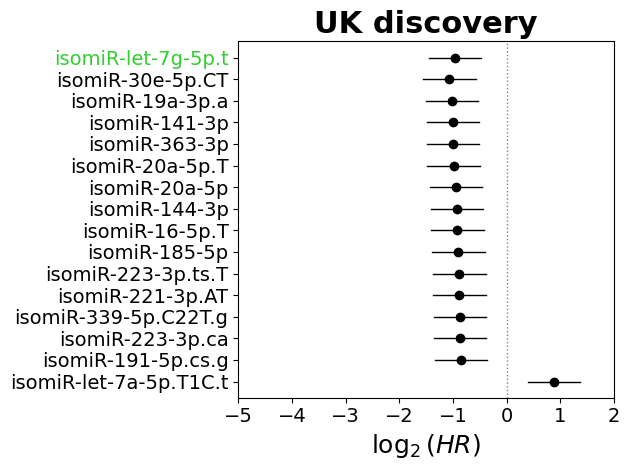

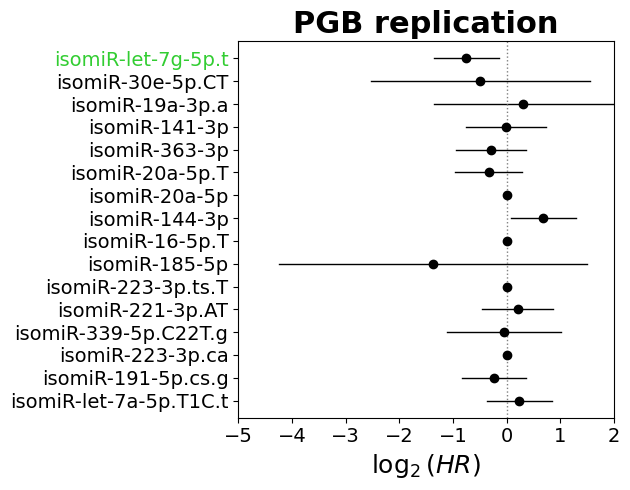

In [39]:
custom_feature_names_uni = [
    col.replace("hsa", "isomiR") if "let" in col else
    col.replace("hsa-", "iso") if "miR" in col else col
    for col in results_uni_binary.Feature
]

results_uni_binary.Feature = custom_feature_names_uni
results_uni_binary['padj'] = multipletests(results_uni_binary['P-value'], method= 'fdr_bh')[1]

dis_fdr_uni = results_uni_binary[results_uni_binary['padj']<= 0.05]
dis_fdr_uni.fillna(1,inplace= True)

# sort by replication HR
dis_fdr_uni.sort_values(by = 'HR', ascending=False, inplace=True)

# Separate the row you want to move
row_to_move = dis_fdr_uni[dis_fdr_uni["Feature"] == "isomiR-let-7g-5p.t"]
df_remaining = dis_fdr_uni[dis_fdr_uni["Feature"] != "isomiR-let-7g-5p.t"]

# Concatenate with that row at the bottom
dis_fdr_uni = pd.concat([df_remaining, row_to_move], ignore_index=False)

plot_forest(dis_fdr_uni,
            '95% CI Lower','95% CI Upper','HR',y_ticks='Feature',log2 = True,middle_line=0,
            main_title = "UK discovery",sort_HR=False,
           highlight_y_ticks = ['isomiR-let-7g-5p.t'],xlim = [-5,2], x_tick_gap = 1)

# plt.savefig("graphs/1c.eps", format='eps', bbox_inches='tight')

plt.figure(figsize=(6.4, 5)) 
plot_forest(dis_fdr_uni,
            '95% CI Lower_replication','95% CI Upper_replication',
            'HR_replication',y_ticks='Feature',log2 = True,middle_line=0,
            main_title = "PGB replication",sort_HR=False,
           highlight_y_ticks = ['isomiR-let-7g-5p.t'],xlim = [-5,2],x_tick_gap = 1)

# plt.savefig("graphs/1d.eps", format='eps', bbox_inches='tight')

/home/projects/hornsteinlab/yahelc/miniconda3/envs/isomiRs_II/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['binarized_feature'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/projects/hornsteinlab/yahelc/miniconda3/envs/isomiRs_II/lib/python3.9/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['binarized_feature'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/projects/hornsteinlab/yahelc/miniconda3/envs/isomiRs_II/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: ov

Skipping hsa-miR-223-3p (Threshold 3628.84035851901, Replication): delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Skipping hsa-miR-185-5p (Threshold 291.79432015536247, Replication): delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Skipping hsa-miR-339-5p (Threshold 124.0603137196895, Replication): delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Skipping hsa-miR-20a-5p (Threshold 115.2014088701995, Replication): delta contains nan value(s). Conver

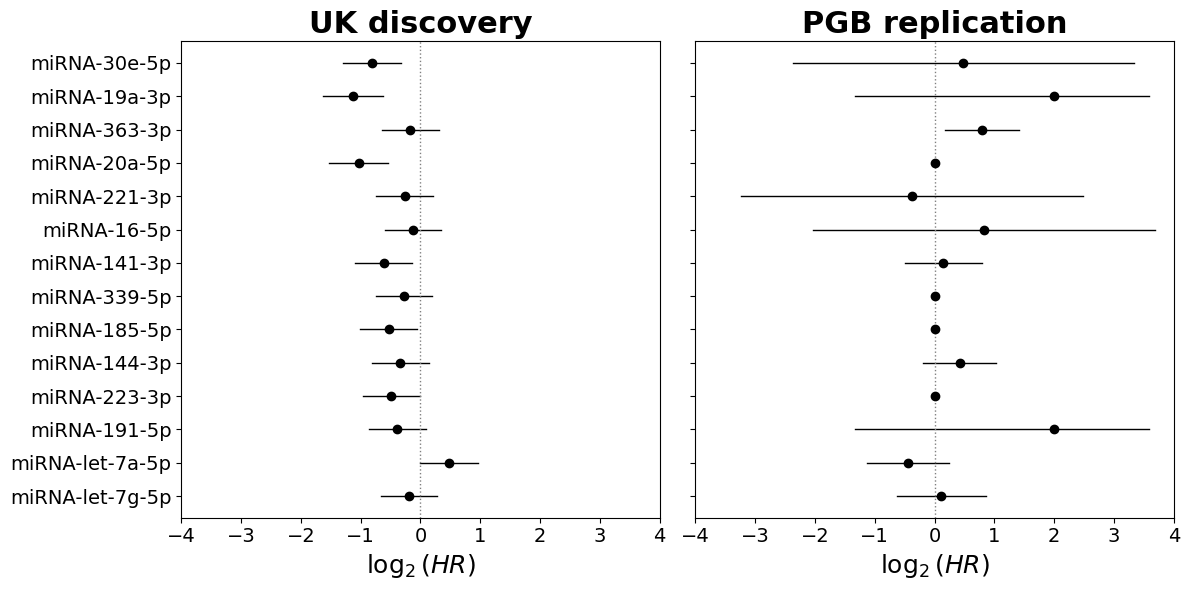

In [40]:
# miRNAs levels of the isomiRs passing FDR

# isomiRs mean UMI thershold was 5 UMI
fdr_mature = ['hsa-let-7g-5p','hsa-let-7a-5p','hsa-miR-191-5p','hsa-miR-223-3p','hsa-miR-144-3p','hsa-miR-185-5p',
              'hsa-miR-339-5p','hsa-miR-141-3p','hsa-miR-16-5p','hsa-miR-221-3p','hsa-miR-20a-5p','hsa-miR-363-3p',
             'hsa-miR-19a-3p','hsa-miR-30e-5p']

train_mature_fdr, test_mature_fdr = mature_data_load(output_censorship=False, output_labels=False,mature_mirs=fdr_mature)

test_mature_fdr.drop(index = ['BAC_7_22'],axis =0, inplace = True)

mature_fdr_dis = pd.concat([train_mature_fdr[fdr_mature],
                              X_train_raw_all_surv[['outcome','Survival.from.enrolment']]],axis = 1)

mature_fdr_rep = pd.concat([test_mature_fdr[fdr_mature].reset_index(drop = True),
                            X_replication_filtered[['outcome','Survival.from.enrolment']]], axis = 1)

mature_uni_binary = cox_univariate_binarization(mature_fdr_dis,mature_fdr_rep,
                            'Survival.from.enrolment','outcome', 'median')

# these are not real number they replace Nan and inf and 0 number in the case of non-convergance of cox
# this is for plotting reasons
mature_uni_binary.fillna(1,inplace= True)
mature_uni_binary.replace([np.inf, -np.inf], 12, inplace=True)
mature_uni_binary.loc[mature_uni_binary["HR_replication"] > 10, "HR_replication"] = 4
mature_uni_binary.loc[mature_uni_binary["95% CI Lower_replication"] == 0, "95% CI Lower_replication"] = 0.4

# mature_uni_binary = mature_uni_binary.reindex(fdr_mature)

mature_uni_binary.Feature = [
    col.replace("hsa", "miRNA") if "let" in col else
    col.replace("hsa-miR", "miRNA") if "miR" in col else col
    for col in mature_uni_binary.Feature
]
mature_uni_binary.index = mature_uni_binary.Feature

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6),sharey=True) # 

plot_forest(mature_uni_binary,
            '95% CI Lower_replication','95% CI Upper_replication',
            'HR_replication',y_ticks='Feature',log2 = True,middle_line=0,
            main_title = "PGB replication",sort_HR=False,xlim = [-4,4],x_tick_gap=1)

plt.sca(axes[0])
 
plot_forest(mature_uni_binary,
            '95% CI Lower','95% CI Upper','HR',y_ticks='Feature',log2 = True,middle_line=0,
            main_title = "UK discovery",sort_HR=False,xlim = [-4,4],x_tick_gap=1)


plt.sca(axes[1])


# plt.savefig("graphs/S2.eps", format='eps', bbox_inches='tight')



In [100]:
mature_uni_binary

Feature     Threshold   C-index        HR  \
Feature                                                              
miRNA-let-7g-5p  miRNA-let-7g-5p    933.364230  0.506239  0.875739   
miRNA-let-7a-5p  miRNA-let-7a-5p  14407.874552  0.514629  1.386752   
miRNA-191-5p        miRNA-191-5p   2295.419872  0.523062  0.763809   
miRNA-223-3p        miRNA-223-3p   3628.840359  0.530204  0.712598   
miRNA-144-3p        miRNA-144-3p     15.127765  0.531538  0.792550   
miRNA-185-5p        miRNA-185-5p    291.794320  0.534550  0.692851   
miRNA-339-5p        miRNA-339-5p    124.060314  0.529300  0.825692   
miRNA-141-3p        miRNA-141-3p      7.160019  0.573273  0.654379   
miRNA-16-5p          miRNA-16-5p  26400.192844  0.513467  0.918558   
miRNA-221-3p        miRNA-221-3p   1455.548591  0.520351  0.832058   
miRNA-20a-5p        miRNA-20a-5p    115.201409  0.590999  0.487667   
miRNA-363-3p        miRNA-363-3p     37.648885  0.519448  0.888833   
miRNA-19a-3p        miRNA-19a-3p      9.840137  0.583384  0.458797   
miRNA-30e-5p        miRNA-30e-5p    547.301569  0.551803  0.569640   

                 95% CI Lower  95% CI Upper   P-value  C-index_replication  \
Feature                                                                      
miRNA-let-7g-5p      0.630334      1.216686  0.429003             0.509351   
miRNA-let-7a-5p      0.991222      1.940109  0.056326             0.558206   
miRNA-191-5p         0.549610      1.061488  0.108583             0.501491   
miRNA-223-3p         0.511020      0.993692  0.045796             1.000000   
miRNA-144-3p         0.571239      1.099600  0.164028             0.530153   
miRNA-185-5p         0.498349      0.963266  0.029067             1.000000   
miRNA-339-5p         0.595050      1.145733  0.251803             1.000000   
miRNA-141-3p         0.470892      0.909365  0.011542             0.504540   
miRNA-16-5p          0.662576      1.273437  0.610269             0.505285   
miRNA-221-3p         0.598377      1.156996  0.274387             0.500136   
miRNA-20a-5p         0.347606      0.684163  0.000032             1.000000   
miRNA-363-3p         0.639867      1.234669  0.482181             0.559832   
miRNA-19a-3p         0.323615      0.650448  0.000012             0.500407   
miRNA-30e-5p         0.406535      0.798182  0.001077             0.504472   

                 HR_replication  95% CI Lower_replication  \
Feature                                                     
miRNA-let-7g-5p        1.083143                  0.645934   
miRNA-let-7a-5p        0.733446                  0.455901   
miRNA-191-5p           4.000000                  0.400000   
miRNA-223-3p           1.000000                  1.000000   
miRNA-144-3p           1.342104                  0.878696   
miRNA-185-5p           1.000000                  1.000000   
miRNA-339-5p           1.000000                  1.000000   
miRNA-141-3p           1.106698                  0.708733   
miRNA-16-5p            1.775683                  0.244425   
miRNA-221-3p           0.770464                  0.106267   
miRNA-20a-5p           1.000000                  1.000000   
miRNA-363-3p           1.737805                  1.133210   
miRNA-19a-3p           4.000000                  0.400000   
miRNA-30e-5p           1.398213                  0.193309   

                 95% CI Upper_replication  P-value_replication  
Feature                                                         
miRNA-let-7g-5p                  1.816283             0.762024  
miRNA-let-7a-5p                  1.179955             0.201301  
miRNA-191-5p                    12.000000             0.995954  
miRNA-223-3p                     1.000000             1.000000  
miRNA-144-3p                     2.049905             0.173336  
miRNA-185-5p                     1.000000             1.000000  
miRNA-339-5p                     1.000000             1.000000  
miRNA-141-3p                     1.728126             0.655694  
miRNA-16-5p                 

[{'Feature': 'miRNA-let-7g-5p',
  'Log-rank p-value': 0.7622993345741763,
  'C-index': 0.5093508605502101,
  'Hazard Ratio': 1.083143315385003,
  'HR p-value': 0.7620243885159899,
  'Confidance interval':           0
  0  0.645934
  1  1.816283}]

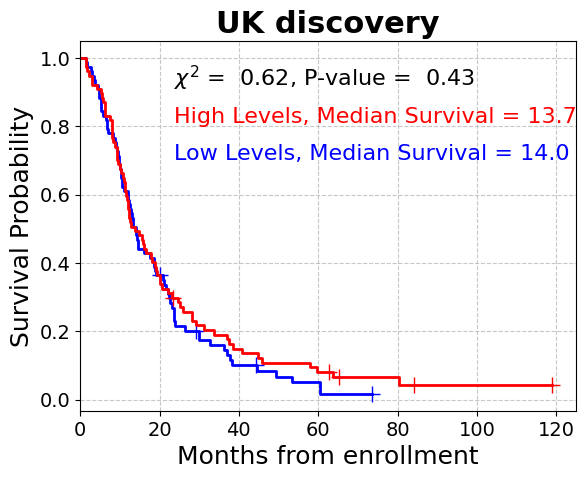

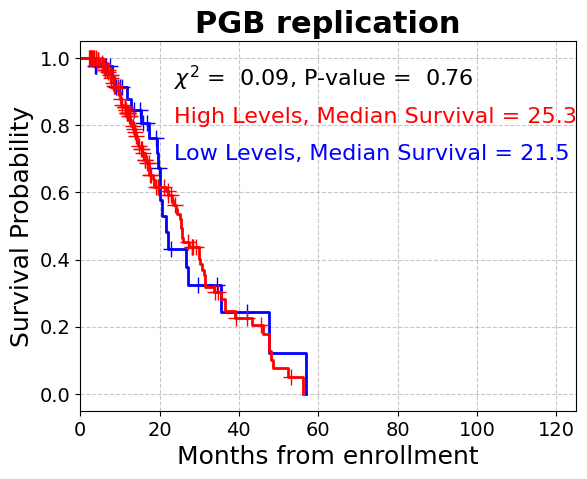

In [41]:
mature_fdr_dis_q, bin_arrays_mature_fdr_dis = convert_to_quantiles(mature_fdr_dis,
                                                         ['hsa-let-7g-5p'],'outcome','Survival.from.enrolment',2)
mature_fdr_rep_q = copy.deepcopy(mature_fdr_rep)
mature_fdr_rep_q['hsa-let-7g-5p'] = (mature_fdr_rep['hsa-let-7g-5p'] >= bin_arrays_mature_fdr_dis['hsa-let-7g-5p'][1]).astype(int)
#nfl_test_q, bin_arrays_nfl_test = convert_to_quantiles(test_nfl__filtered_df,['NfL median'],'outcome','Survival.from.enrolment',3)

mature_fdr_dis_q.rename(columns={'hsa-let-7g-5p' : 'miRNA-let-7g-5p'},inplace=True)
mature_fdr_rep_q.rename(columns={'hsa-let-7g-5p' : 'miRNA-let-7g-5p'},inplace=True)


KM_plots(mature_fdr_dis_q,['miRNA-let-7g-5p'] ,cohort_title='UK discovery', combine_plots=False,
         km_stats_loc = [0.19, 0.94],
         high_text_loc = [0.19, 0.78],
         low_text_loc = [0.19, 0.68],
         x_title = 'Months from enrollment',xlim = [0,125],text_size = 16)

# plt.savefig("graphs/1g.eps", format='eps', bbox_inches='tight')

KM_plots(mature_fdr_rep_q,['miRNA-let-7g-5p'] ,cohort_title='PGB replication', combine_plots=False,
         km_stats_loc = [0.19, 0.94],
         high_text_loc = [0.19, 0.78],
         low_text_loc = [0.19, 0.68],
         x_title = 'Months from enrollment', xlim = [0,125],text_size = 16)


# plt.savefig("graphs/1h.eps", format='eps', bbox_inches='tight')

# miR-181 analysis

## miR-181 and isomiRs in multivariate cox

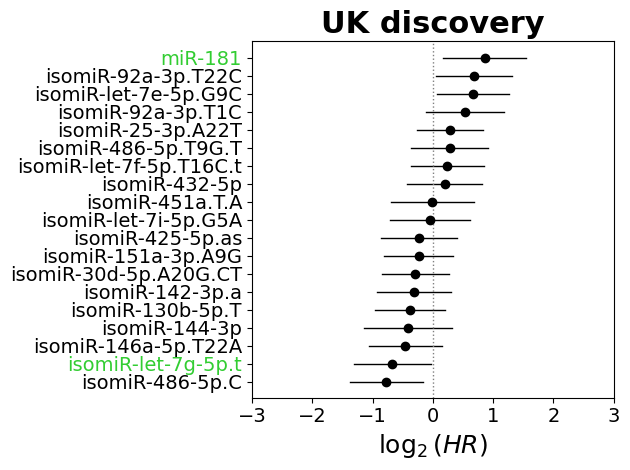

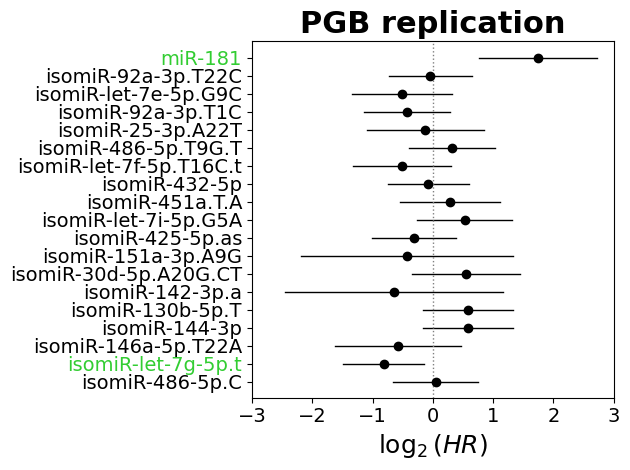

In [42]:
cph = lifelines.CoxPHFitter()
cph.fit(miR_181_dfs['UK_binary_chosen_isomiRs'].drop('Survival.from.onset', axis =1),
        duration_col="Survival.from.enrolment", event_col="outcome")

# Extract hazard ratios, confidence intervals, and p-values
summary_uk = cph.summary
summary_uk = summary_uk.sort_values(by = 'exp(coef)',ascending = True)
    

plot_forest(summary_uk.reset_index(drop=False),'exp(coef) lower 95%','exp(coef) upper 95%','exp(coef)',
            main_title = "UK discovery",y_ticks='covariate', sort_HR=False,
           highlight_y_ticks=['isomiR-let-7g-5p.t','miR-181'], xlim = [-3,3], x_tick_gap=1)

# plt.savefig("graphs/4c.eps", format='eps', bbox_inches='tight')
plt.show()

cph.fit(miR_181_dfs['PGB_binary_chosen_isomiRs'].drop('Survival.from.onset', axis =1),
        duration_col="Survival.from.enrolment", event_col="outcome")
summary_pgb = cph.summary
summary_pgb =summary_pgb.loc[summary_uk.index]


plot_forest(summary_pgb.reset_index(drop=False),'exp(coef) lower 95%','exp(coef) upper 95%','exp(coef)',
            main_title = "PGB replication",y_ticks='covariate', sort_HR=False,
            highlight_y_ticks=['isomiR-let-7g-5p.t','miR-181'], xlim = [-3,3],x_tick_gap=1)
# plt.savefig("graphs/4d.eps", format='eps', bbox_inches='tight')

## engnireed feature of miR-181 and isomiR-let-7g-5p.t

/tmp/ipykernel_3561701/2075867631.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engineered_df_for_km_rep['isomiR-let-7g-5p.t_miR-181_ratio'] =(engineered_df_for_km_rep['isomiR-let-7g-5p.t_miR-181_ratio'] > \
/tmp/ipykernel_3561701/2075867631.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engineered_df_for_km['isomiR-let-7g-5p.t_miR-181_ratio'] =(engineered_df_for_km['isomiR-let-7g-5p.t_miR-181_ratio'] > \


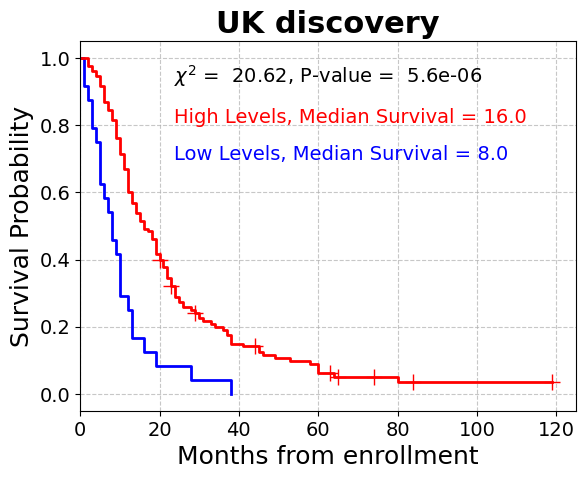

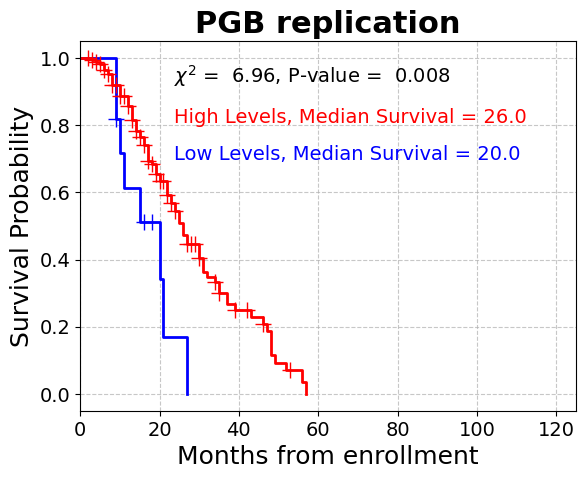

In [58]:
run_feature_engineering = False

# Test different mathmatical combinations of miR-181 and isomiR-let-7g-5p.t
filtered_feature_df_discovery = miR_181_dfs['UK_chosen_isomiRs'][['isomiR-let-7g-5p.t','miR-181','outcome','Survival.from.enrolment']]
engineered_df = generate_features(filtered_feature_df_discovery,'isomiR-let-7g-5p.t','miR-181')

filtered_feature_df_replication = miR_181_dfs['PGB_chosen_isomiRs'][['isomiR-let-7g-5p.t',
                                                                     'miR-181','outcome','Survival.from.enrolment']].drop(index = 148)
engineered_df_replication = generate_features(filtered_feature_df_replication,'isomiR-let-7g-5p.t','miR-181')

if run_feature_engineering:
    all_possible_cox_results = cox_univariate_binarization(engineered_df,
                                                           engineered_df_replication,
                                                           'Survival.from.enrolment','outcome')
#     all_possible_cox_results.to_csv('miR_181_&_isolet_7_engineered_cox.csv')
else:
    all_possible_cox_results = pd.read_csv('miR_181_&_isolet_7_engineered_cox.csv')
    all_possible_cox_results.drop('Unnamed: 0', axis = 1, inplace = True)

# filter to only significant combinations in the same direction in discovery and replication 
filter_cox = (all_possible_cox_results['P-value'] <= 0.05) & (all_possible_cox_results['P-value_replication'] <= 0.05) & \
             (((all_possible_cox_results['HR'] < 1) & (all_possible_cox_results['HR_replication'] < 1)) | \
             ((all_possible_cox_results['HR'] > 1) & (all_possible_cox_results['HR_replication'] > 1))) 

all_possible_cox_results = all_possible_cox_results[filter_cox]

# rank outcome
all_possible_cox_results = rank_thresholds_per_feature(all_possible_cox_results)
all_possible_cox_results[all_possible_cox_results.Rank == 1].sort_values(["HR", "HR_replication"], ascending=[True, True])

# extract for KM ploting
engineered_df_for_km = engineered_df[['isomiR-let-7g-5p.t_miR-181_ratio','outcome','Survival.from.enrolment']]

engineered_df_for_km_rep = engineered_df_replication[['isomiR-let-7g-5p.t_miR-181_ratio','outcome','Survival.from.enrolment']]

iso_let7_181_uni = cox_univariate_binarization(engineered_df_for_km,engineered_df_for_km_rep,
                            'Survival.from.enrolment','outcome',cutpoint='median')

# binerize by median
engineered_df_for_km_rep['isomiR-let-7g-5p.t_miR-181_ratio'] =(engineered_df_for_km_rep['isomiR-let-7g-5p.t_miR-181_ratio'] > \
                                                          all_possible_cox_results.loc[489]['Threshold']).astype(int)

engineered_df_for_km['isomiR-let-7g-5p.t_miR-181_ratio'] =(engineered_df_for_km['isomiR-let-7g-5p.t_miR-181_ratio'] > \
                                                          all_possible_cox_results.loc[489]['Threshold']).astype(int)

# plot KMs
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6),sharey=True) #  

# plt.sca(axes[0])
KM_plots(engineered_df_for_km,feature_cols=['isomiR-let-7g-5p.t_miR-181_ratio'],cohort_title ="UK discovery",
         combine_plots=False,
         km_stats_loc = [0.19, 0.94],
         high_text_loc = [0.19, 0.78],
         low_text_loc = [0.19, 0.68],
         x_title = 'Months from enrollment', xlim = [0,125]) # , axs = axes[0]

# axes[0].set_title('UK discovery', fontsize=25, fontweight="bold")
# plt.savefig("graphs/4e.eps", format='eps', bbox_inches='tight')

# plt.sca(axes[1])
KM_plots(engineered_df_for_km_rep,feature_cols=['isomiR-let-7g-5p.t_miR-181_ratio'],cohort_title= "PGB replication",
         combine_plots=False,
         km_stats_loc = [0.19, 0.94],
         high_text_loc = [0.19, 0.78],
         low_text_loc = [0.19, 0.68],
         x_title = 'Months from enrollment', xlim = [0,125]) # , axs = axes[1]
# axes[1].set_title('PGB replication', fontsize=28, fontweight="bold")


# fig.suptitle("isomiR-let-7g-5p / miR-181 Ratio", 
#              fontsize=35, fontweight="bold", y=1)

# plt.savefig("graphs/4f.eps", format='eps', bbox_inches='tight')
# plt.tight_layout()
plt.show()

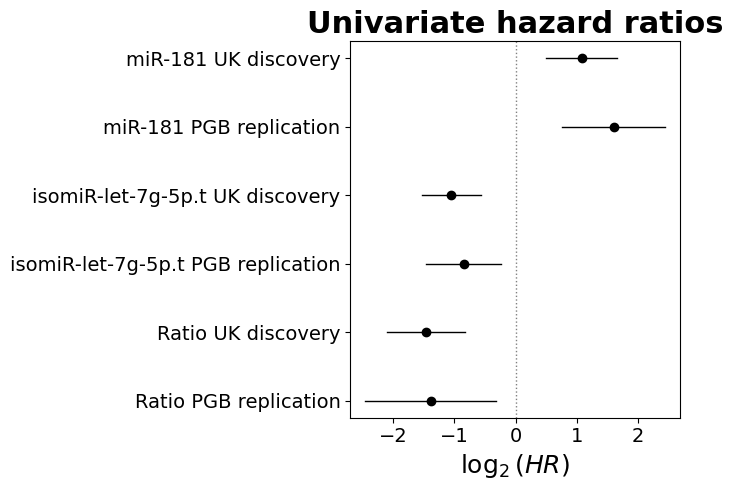

In [44]:
#plot forest plot aod discovert/replication results
engnireed_forst_plot_df_181 = pd.DataFrame((all_possible_cox_results.loc[489][['HR','95% CI Lower','95% CI Upper']].reset_index(drop = True),
             all_possible_cox_results.loc[489][['HR_replication',
                                                '95% CI Lower_replication','95% CI Upper_replication']].reset_index(drop = True)))
engnireed_forst_plot_df_181.columns=['HRs','confi_lower','confi_upper']
engnireed_forst_plot_df_181['features'] = ['Ratio','Ratio']

engnireed_forst_plot_df_181 = pd.concat([uni_HRs_df[uni_HRs_df.features.isin(['miR-181','isomiR-let-7g-5p.t'])],
          uni_HRs_df_rep[uni_HRs_df_rep.features.isin(['miR-181','isomiR-let-7g-5p.t'])],
          engnireed_forst_plot_df_181], axis = 0).reset_index(drop = True)

engnireed_forst_plot_df_181["features"] = engnireed_forst_plot_df_181["features"] + np.concatenate((np.repeat([" UK discovery", " PGB replication"], 2),np.array([" UK discovery", " PGB replication"])))


correct_order = [
    "Ratio PGB replication",
    "Ratio UK discovery",
    "isomiR-let-7g-5p.t PGB replication",
    "isomiR-let-7g-5p.t UK discovery",
    "miR-181 PGB replication",
    "miR-181 UK discovery"
]

# Ensure categorical order for sorting
engnireed_forst_plot_df_181["features"] = pd.Categorical(engnireed_forst_plot_df_181["features"], categories=correct_order, ordered=True)

# Sort the dataframe before plotting
engnireed_forst_plot_df_181 = engnireed_forst_plot_df_181.sort_values("features").reset_index(drop=True)

plt.figure(figsize=(7, 5))
plot_forest(engnireed_forst_plot_df_181,'confi_lower','confi_upper','HRs',
            main_title = "Univariate hazard ratios",y_ticks='features', sort_HR=False)

# NfL analysis 

[{'Feature': 'NfL median',
  'Log-rank p-value': 2.6604922742421627e-05,
  'C-index': 0.6314541265754168,
  'Hazard Ratio': 2.4050751639154253,
  'HR p-value': 4.507976934225424e-05,
  'Confidance interval':           0
  0  1.577722
  1  3.666289}]

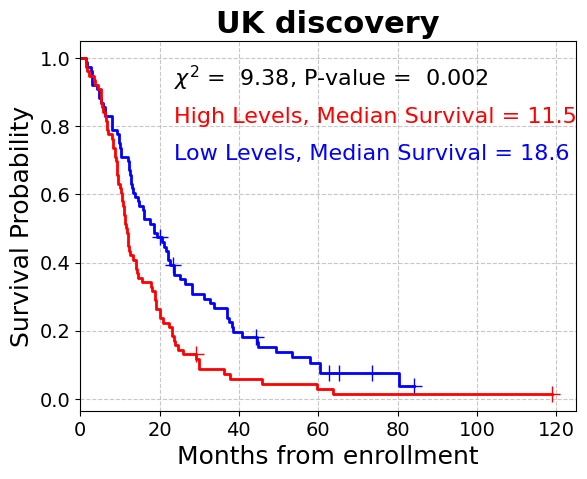

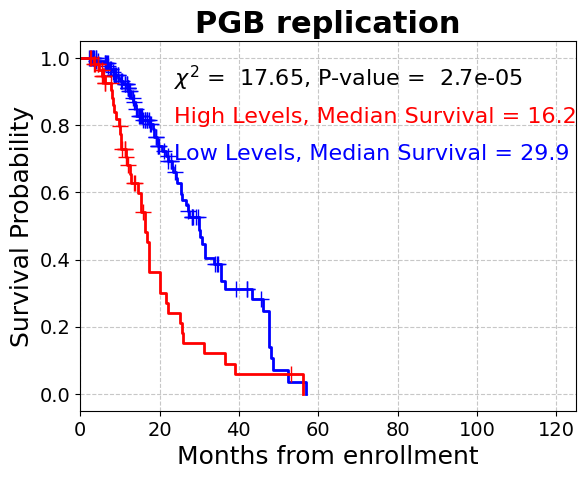

In [45]:
nfl_train_q, bin_arrays_nfl_train = convert_to_quantiles(train_nfl__filtered_df,
                                                         ['NfL median'],'outcome','Survival.from.enrolment',2)
nfl_test_q = copy.deepcopy(test_nfl__filtered_df)
nfl_test_q['NfL median'] = (test_nfl__filtered_df['NfL median'] >= bin_arrays_nfl_train['NfL median'][1]).astype(int)


KM_plots(nfl_train_q,['NfL median'] ,cohort_title='UK discovery', combine_plots=False,
         km_stats_loc = [0.19, 0.94],high_text_loc = [0.19, 0.78],
         low_text_loc = [0.19, 0.68],  xlim = [0,125], text_size= 16,
         x_title = 'Months from enrollment')

# plt.savefig("graphs/3a.eps", format='eps', bbox_inches='tight')

KM_plots(nfl_test_q,['NfL median'] ,cohort_title='PGB replication', combine_plots=False,
         km_stats_loc = [0.19, 0.94],high_text_loc = [0.19, 0.78],
         low_text_loc = [0.19, 0.68],text_size= 16,
         x_title = 'Months from enrollment', xlim = [0,125])

# plt.savefig("graphs/3b.eps", format='eps', bbox_inches='tight')

# # combined isomiRs dichotomized by medain KMs
# KM_plots(nfl_binary_cox,['iso combined'] ,cohort_title='UK discovery', combine_plots=False,
#          km_stats_loc = [0.37, 0.95],high_text_loc = [0.3, 0.78],
#          low_text_loc = [0.3, 0.68],
#          x_title = 'Months from enrollment')

# KM_plots(nfl_binary_cox_rep,['iso combined'] ,cohort_title='PGB replication', combine_plots=False,
#          km_stats_loc = [0.37, 0.95],high_text_loc = [0.3, 0.78],
#          low_text_loc = [0.3, 0.68],
#          x_title = 'Months from enrollment', xlim = [0,125])


0.6705549664192294
                             coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                
isomiR-let-7e-5p.G9C     0.042837   1.043767  0.248114       -0.443458   
isomiR-let-7f-5p.T16C.t  0.063733   1.065808  0.207356       -0.342676   
isomiR-let-7g-5p.t      -0.360995   0.696982  0.242529       -0.836343   
isomiR-let-7i-5p.G5A     0.480028   1.616120  0.217138        0.054445   
isomiR-130b-5p.T        -0.107530   0.898050  0.234710       -0.567552   
isomiR-142-3p.a          0.027689   1.028076  0.262323       -0.486454   
isomiR-144-3p           -0.232397   0.792631  0.289975       -0.800737   
isomiR-146a-5p.T22A     -0.670105   0.511655  0.238182       -1.136934   
isomiR-151a-3p.A9G      -0.042585   0.958309  0.210031       -0.454239   
isomiR-25-3p.A22T        0.108631   1.114751  0.213850       -0.310506   
isomiR-30d-5p.A20G.CT   -0.295529   0.744138  0.194820       -0.677369   
isomiR-425-5p.as   

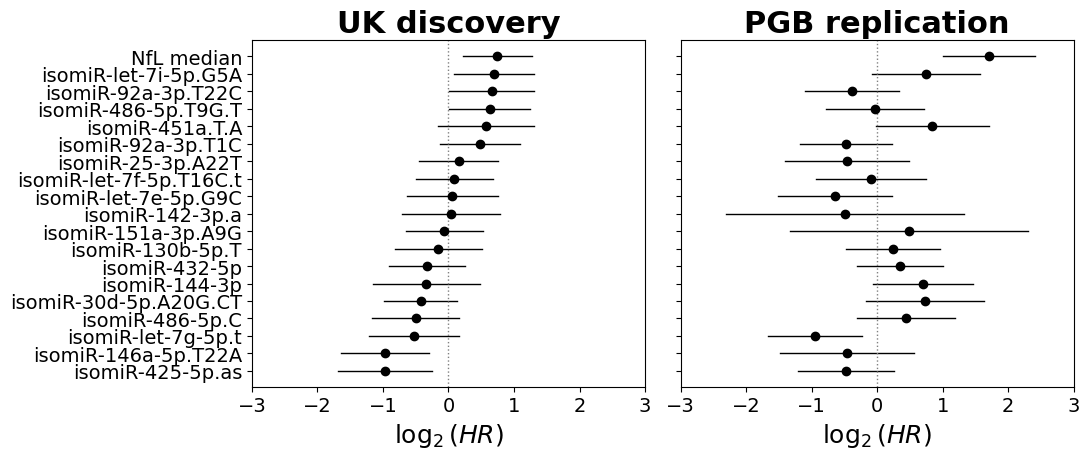

In [46]:
# multivariate analysis of all isomiRs with NfL in discovery/replication


nfl_ind_iso_binary_df = train_nfl_df[train_nfl_df.index.isin(nfl_train_q.index)].drop('Survival.from.onset', axis =1 )
nfl_ind_iso_binary_df['NfL median'] = nfl_train_q['NfL median']

cph.fit(nfl_ind_iso_binary_df,duration_col='Survival.from.enrolment', event_col='outcome')

res_df = cph.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]
res_df['features'] = res_df.index

res_df.sort_values(by = 'exp(coef)',ascending=True, inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4.7),sharey=True)


print(cph.concordance_index_)
print(cph.summary)



# plt.savefig("graphs/S7a&b.eps", format='eps', bbox_inches='tight')


nfl_ind_iso_binary_df_rep = pd.concat([nfl_test_q[['NfL median']].reset_index(drop = True),
           miR_181_dfs['PGB_binary_chosen_isomiRs'].drop(columns = ['miR-181','Survival.from.onset'],
                                                         index = 148).reset_index(drop = True)],axis = 1)

cph.fit(nfl_ind_iso_binary_df_rep,duration_col='Survival.from.enrolment', event_col='outcome')

res_df_rep = cph.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]
res_df_rep['features'] = res_df_rep.index

res_df_rep = res_df_rep.loc[res_df.index]

plot_forest(res_df_rep,
            'exp(coef) lower 95%','exp(coef) upper 95%','exp(coef)',log2 = True,middle_line=0,
            main_title = "PGB replication",sort_HR=False,
           highlight_y_ticks = False,xlim = [-3,3], x_tick_gap=1,yticks_size=14)

plt.sca(axes[0])

plot_forest(res_df,
            'exp(coef) lower 95%','exp(coef) upper 95%','exp(coef)',log2 = True,middle_line=0,
            main_title = "UK discovery",sort_HR=False,
           highlight_y_ticks = False,xlim = [-3,3], x_tick_gap=1,yticks_size=14)

# plt.savefig("graphs/7a.eps", format='eps', bbox_inches='tight')
# plt.show()

plt.sca(axes[1])

# plt.savefig("graphs/7b.eps", format='eps', bbox_inches='tight')
print(cph.concordance_index_)
print(cph.summary)

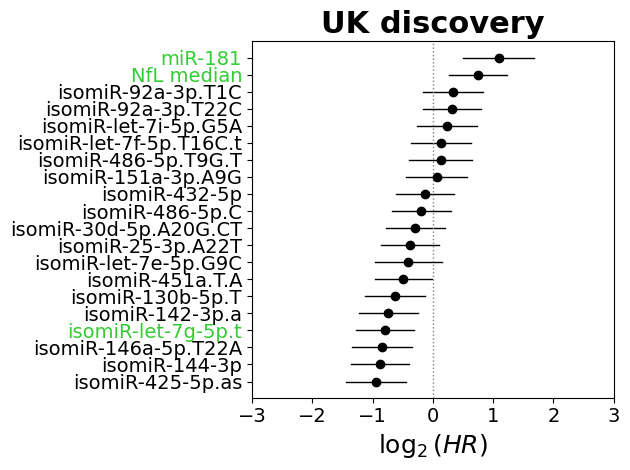

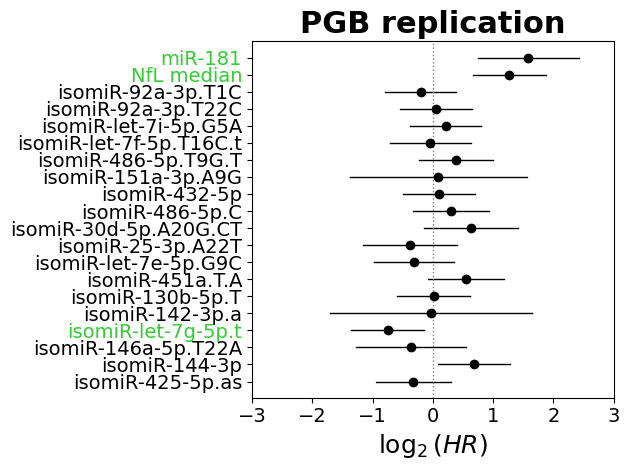

In [47]:
# forest plot for univariate cox binary isomiRs, NfL & miR-181

# [138, 148] indexes in train had no NfL values so I omitted them from NfL analysis
miR_181_nfl = miR_181_dfs['UK_binary_chosen_isomiRs']['miR-181'].drop(index = [138, 148])
miR_181_nfl.index = nfl_ind_iso_binary_df.index
nfl_ind_iso_binary_df['miR-181'] = miR_181_nfl

miR_181_nfl_rep = miR_181_dfs['PGB_binary_chosen_isomiRs']['miR-181'].drop(index = [148])
miR_181_nfl_rep.index = nfl_ind_iso_binary_df_rep.index
nfl_ind_iso_binary_df_rep['miR-181'] = miR_181_nfl_rep

discovery_uni_nfl_cox = {}
replication_uni_nfl_cox = {}
cph = lifelines.CoxPHFitter()
for feat in nfl_ind_iso_binary_df.columns:
    if feat in ['Survival.from.enrolment','outcome']:
        continue
    cph.fit(nfl_ind_iso_binary_df[[feat,'Survival.from.enrolment','outcome']],
            duration_col='Survival.from.enrolment', event_col='outcome')
    discovery_uni_nfl_cox[feat] = {'HRs' :  cph.summary['exp(coef)'][0],
                                  "confi_lower":  cph.summary['exp(coef) lower 95%'][0],
                                  "confi_upper":  cph.summary['exp(coef) upper 95%'][0],
                                  'P-value' : cph.summary['p'][0],
                                  'C-index' : cph.concordance_index_}
    
    cph.fit(nfl_ind_iso_binary_df_rep[[feat,'Survival.from.enrolment','outcome']],
            duration_col='Survival.from.enrolment', event_col='outcome')
    replication_uni_nfl_cox[feat] = {'HRs' :  cph.summary['exp(coef)'][0],
                                  "confi_lower":  cph.summary['exp(coef) lower 95%'][0],
                                  "confi_upper":  cph.summary['exp(coef) upper 95%'][0],
                                    'P-value' : cph.summary['p'][0],
                                    'C-index' : cph.concordance_index_}
    
    uni_HRs_df_nfl = pd.DataFrame({'features' : [i for i,j in discovery_uni_nfl_cox.items()],
'HRs' : [j['HRs'] for i,j in discovery_uni_nfl_cox.items()],
'confi_lower' : [j['confi_lower'] for i,j in discovery_uni_nfl_cox.items()],
'confi_upper' : [j['confi_upper'] for i,j in discovery_uni_nfl_cox.items()],
'P-value' : [j['P-value'] for i,j in discovery_uni_nfl_cox.items()],
'C-index' : [j['C-index'] for i,j in discovery_uni_nfl_cox.items()]})



uni_HRs_df_nfl.sort_values(by = 'HRs',ascending = True,inplace=True)

uni_HRs_df_nfl_rep = pd.DataFrame({'features' : [i for i,j in replication_uni_nfl_cox.items()],
'HRs' : [j['HRs'] for i,j in replication_uni_nfl_cox.items()],
'confi_lower' : [j['confi_lower'] for i,j in replication_uni_nfl_cox.items()],
'confi_upper' : [j['confi_upper'] for i,j in replication_uni_nfl_cox.items()],
'P-value' : [j['P-value'] for i,j in replication_uni_nfl_cox.items()],
'C-index' : [j['C-index'] for i,j in replication_uni_nfl_cox.items()]})


uni_HRs_df_nfl_rep = uni_HRs_df_nfl_rep.loc[uni_HRs_df_nfl.index]

uni_HRs_df_nfl_rep.reset_index(inplace=True, drop = True)
uni_HRs_df_nfl.reset_index(inplace=True, drop = True)

plot_forest(uni_HRs_df_nfl,'confi_lower','confi_upper','HRs',
            main_title = "UK discovery",
            highlight_y_ticks = ['isomiR-let-7g-5p.t', 'miR-181','NfL median'], xlim = [-3,3], x_tick_gap=1) #xlim = [-2.1,2.5]
# plt.savefig("graphs/3c.eps", format='eps', bbox_inches='tight')
plt.show()

plot_forest(uni_HRs_df_nfl_rep,'confi_lower','confi_upper','HRs',
            main_title = "PGB replication",sort_HR=False,
           highlight_y_ticks = ['isomiR-let-7g-5p.t', 'miR-181','NfL median'],xlim = [-3,3], x_tick_gap=1)
# plt.savefig("graphs/3d.eps", format='eps', bbox_inches='tight')

# Engineered feature of NfL and combined isomiRs

## Joint analysis of NfL and isomiR-let-7g-5p.t

In [48]:
run_feature_engineering_nfl = False

# build new DFs for NfL and isomiR-let-7g-5p.t
nfl_let7_df = pd.concat([nfl_df_cont[['NfL median','outcome','Survival.from.enrolment']],
                         X_train_raw[X_train_raw.index.isin(nfl_df_cont.index)]['hsa-let-7g-5p.t']],axis = 1)

nfl_let7_df_rep = pd.concat([test_nfl__filtered_df[['NfL median','outcome','Survival.from.enrolment']],
                         X_test_raw[X_test_raw.index.isin(test_nfl__filtered_df.index)]['hsa-let-7g-5p.t']],axis = 1)

# compute new features baed on different mathmatical operations 
engineered_df = generate_features(nfl_let7_df,'hsa-let-7g-5p.t','NfL median')
engineered_df_replication = generate_features(nfl_let7_df_rep,'hsa-let-7g-5p.t','NfL median')

if run_feature_engineering_nfl:
    all_possible_cox_results = cox_univariate_binarization(engineered_df,
                                                           engineered_df_replication,
                                                           'Survival.from.enrolment','outcome')

    all_possible_cox_results.to_csv('NfL_&_let_7_engineered_cox.csv', index = False)
else:
    all_possible_cox_results = pd.read_csv('NfL_&_let_7_engineered_cox.csv')

filter_cox = (all_possible_cox_results['P-value'] <= 0.05) & (all_possible_cox_results['P-value_replication'] <= 0.05) & \
             (((all_possible_cox_results['HR'] < 1) & (all_possible_cox_results['HR_replication'] < 1)) | \
             ((all_possible_cox_results['HR'] > 1) & (all_possible_cox_results['HR_replication'] > 1))) 

all_possible_cox_results = all_possible_cox_results[filter_cox]

all_possible_cox_results = rank_thresholds_per_feature(all_possible_cox_results)

                     coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                        
NfL median       0.539623   1.715361  0.172306        0.201910   
hsa-let-7g-5p.t -0.651854   0.521079  0.172480       -0.989908   

                 coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                   
NfL median             0.877337             1.223738             2.404487   
hsa-let-7g-5p.t       -0.313800             0.371611             0.730665   

                 cmp to         z         p   -log2(p)  
covariate                                               
NfL median          0.0  3.131779  0.001738   9.168765  
hsa-let-7g-5p.t     0.0 -3.779309  0.000157  12.634521  
0.6215093672675858
                     coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                        
NfL median       1.036323   2.818834  0.219260 

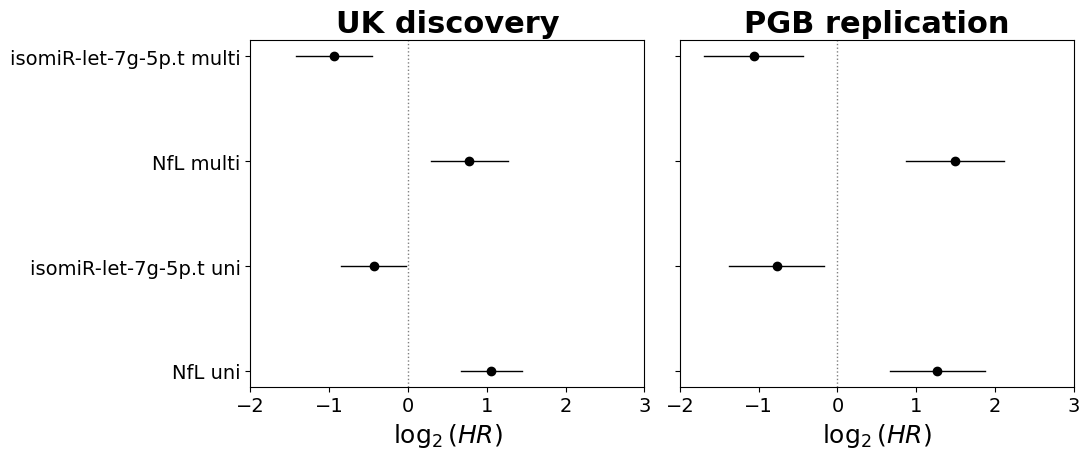

In [49]:
# multivariate cox of NfL & isomiR-let-7g-5p.t for discovery/ replication
SHAP_COX_binary_df = cox_univariate_binarization(nfl_let7_df,nfl_let7_df_rep,
                           'Survival.from.enrolment','outcome', 'median')

SHAP_COX_binary_df['Feature'] = ['NfL uni','isomiR-let-7g-5p.t uni']

nfl_let7_df_binary = copy.deepcopy(nfl_let7_df.loc[nfl_train_q.index])
nfl_let7_df_binary['NfL median'] = (nfl_let7_df_binary['NfL median'] > nfl_let7_df['NfL median'].median()).astype(int)
nfl_let7_df_binary['hsa-let-7g-5p.t'] = (nfl_let7_df_binary['hsa-let-7g-5p.t'] > nfl_let7_df['hsa-let-7g-5p.t'].median()).astype(int)
cph.fit(nfl_let7_df_binary,duration_col='Survival.from.enrolment', event_col='outcome')
add_mat = cph.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]
add_mat['Feature'] = ['NfL multi','isomiR-let-7g-5p.t multi']

add_mat.rename(columns={
    "exp(coef)": "HR",
    "exp(coef) lower 95%": "95% CI Lower",
    "exp(coef) upper 95%": "95% CI Upper",
    "p": "P-value"
},inplace=True)


SHAP_COX_binary_df = pd.concat([SHAP_COX_binary_df, add_mat], ignore_index=False)
print(cph.summary)
print(cph.concordance_index_)

nfl_let7_df_binary_rep = copy.deepcopy(nfl_let7_df_rep)
nfl_let7_df_binary_rep['NfL median'] = (nfl_let7_df_binary_rep['NfL median'] > nfl_let7_df['NfL median'].median()).astype(int)
nfl_let7_df_binary_rep['hsa-let-7g-5p.t'] = (nfl_let7_df_binary_rep['hsa-let-7g-5p.t'] > nfl_let7_df['hsa-let-7g-5p.t'].median()).astype(int)
cph.fit(nfl_let7_df_binary_rep,duration_col='Survival.from.enrolment', event_col='outcome')
add_mat = cph.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]
add_mat['Feature'] = ['NfL multi','isomiR-let-7g-5p.t multi']

add_mat.rename(columns={
    "exp(coef)": "HR_replication",
    "exp(coef) lower 95%": "95% CI Lower_replication",
    "exp(coef) upper 95%": "95% CI Upper_replication",
    "p": "P-value_replication"
},inplace=True)

SHAP_COX_binary_df = pd.concat([SHAP_COX_binary_df, add_mat], ignore_index=False, axis =0)
print(cph.summary)
print(cph.concordance_index_)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4.7),sharey=True)

plot_forest(SHAP_COX_binary_df[~SHAP_COX_binary_df.HR_replication.isnull()].reset_index(drop = True),
            '95% CI Lower_replication','95% CI Upper_replication',
            'HR_replication',y_ticks='Feature',log2 = True,middle_line=0,
            main_title = "PGB replication",sort_HR=False,
           highlight_y_ticks = False,xlim = [-2,2.5], x_tick_gap=1)


plt.sca(axes[0])

plot_forest(SHAP_COX_binary_df[~SHAP_COX_binary_df.HR.isnull()].reset_index(drop = True),
            '95% CI Lower','95% CI Upper',
            'HR',y_ticks='Feature',log2 = True,middle_line=0,
            main_title = "UK discovery",sort_HR=False,
           highlight_y_ticks = False,xlim = [-2,2.5], x_tick_gap=1)

plt.sca(axes[1])

# plt.savefig("graphs/S7c&d.eps", format='eps', bbox_inches='tight')

In [50]:
# multivariate analysis of NfL, isomiR-let-7g-5p.t and clinical covariates

clinical_nfl_isoletf_binary_df_rep = pd.concat([test_clinical,nfl_let7_df_binary_rep],axis = 1)
clinical_nfl_isoletf_binary_df_rep.rename({'Disease primary site' : 'Site of symptom onset',
                                          'hsa-let-7g-5p.t' : 'isomiR-let-7g-5p.t'}, axis = 1, inplace=True)
cph.fit(clinical_nfl_isoletf_binary_df_rep.drop(['DeltaFRS','Riluzole treatment', 'Sex'],axis = 1),
        duration_col='Survival.from.enrolment', event_col='outcome')

res_df_rep = cph.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]
res_df_rep['features'] = res_df.index

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4.7),sharey=True)

plot_forest(res_df_rep,
            'exp(coef) lower 95%','exp(coef) upper 95%','exp(coef)',log2 = True,middle_line=0,
            main_title = "PGB replication",sort_HR=False,
           highlight_y_ticks = False, xlim=[-2,3], x_tick_gap=1)

print(cph.concordance_index_)
print(cph.summary)
plt.sca(axes[0])

clinical_nfl_isoletf_binary_df = pd.concat([train_clinical[train_clinical.index.isin(nfl_let7_df_binary.index)],nfl_let7_df_binary],axis = 1)
clinical_nfl_isoletf_binary_df.rename({'Disease primary site' : 'Site of symptom onset',
                                      'hsa-let-7g-5p.t' : 'isomiR-let-7g-5p.t'}, axis = 1, inplace=True)
cph.fit(clinical_nfl_isoletf_binary_df.drop(['DeltaFRS','Riluzole treatment', 'Sex'],axis = 1),
        duration_col='Survival.from.enrolment', event_col='outcome')

res_df = cph.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]
res_df['features'] = res_df.index
plot_forest(res_df,
            'exp(coef) lower 95%','exp(coef) upper 95%','exp(coef)',log2 = True,middle_line=0,
            main_title = "UK discovery",sort_HR=False,
           highlight_y_ticks = False, xlim=[-2,3], x_tick_gap=1)

print(cph.concordance_index_)
print(cph.summary)
plt.sca(axes[1])
# plt.savefig("graphs/S7e&f.eps", format='eps', bbox_inches='tight')

ValueError: Length of values (19) does not match length of index (5)

## Engineered feature of NfL and isomiR-let-7g-5p.t

/tmp/ipykernel_3561701/3749757612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engineered_df_for_km_rep['hsa-let-7g-5p.t_NfL median_ratio'] =(engineered_df_for_km_rep['hsa-let-7g-5p.t_NfL median_ratio'] > \
/tmp/ipykernel_3561701/3749757612.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engineered_df_for_km['hsa-let-7g-5p.t_NfL median_ratio'] =(engineered_df_for_km['hsa-let-7g-5p.t_NfL median_ratio'] > \
The PostScript backend does not support transparency; partially transparent artists will be

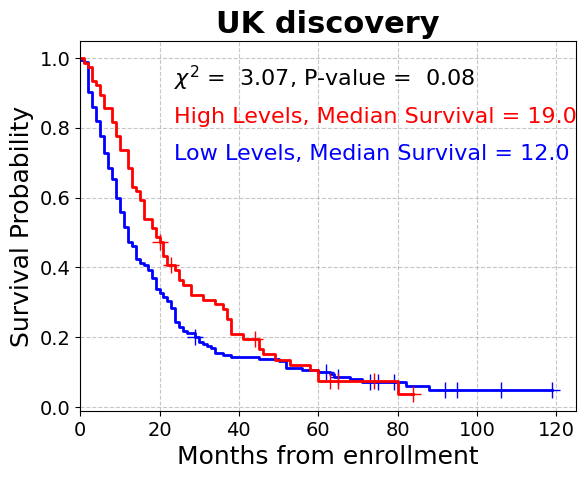

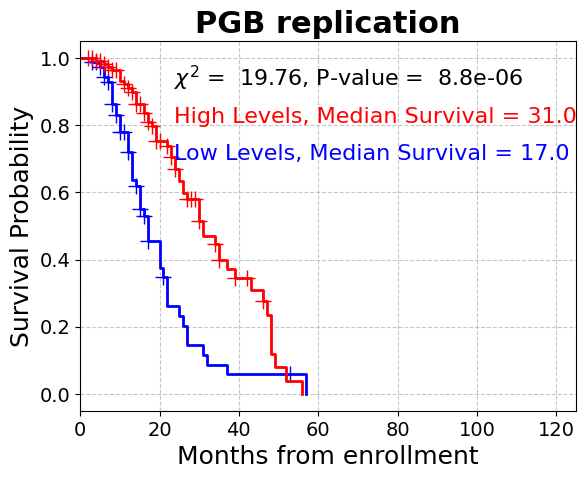

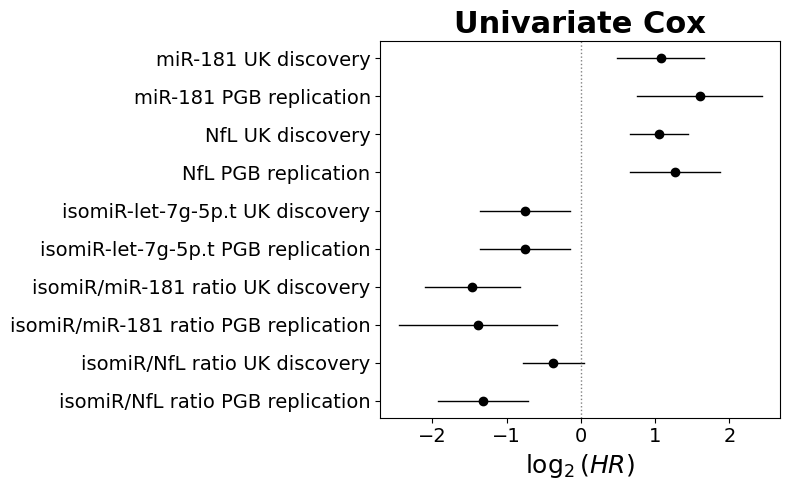

In [51]:
engineered_df_for_km = engineered_df[['hsa-let-7g-5p.t_NfL median_ratio','outcome','Survival.from.enrolment']]
engineered_df_for_km_rep = engineered_df_replication[['hsa-let-7g-5p.t_NfL median_ratio','outcome','Survival.from.enrolment']]

let_7_ratio_uni = cox_univariate_binarization(engineered_df_for_km,engineered_df_for_km_rep,
                            'Survival.from.enrolment','outcome',cutpoint='median')

engineered_df_for_km_rep['hsa-let-7g-5p.t_NfL median_ratio'] =(engineered_df_for_km_rep['hsa-let-7g-5p.t_NfL median_ratio'] > \
                                                          engineered_df_for_km['hsa-let-7g-5p.t_NfL median_ratio'].median()).astype(int)

engineered_df_for_km['hsa-let-7g-5p.t_NfL median_ratio'] =(engineered_df_for_km['hsa-let-7g-5p.t_NfL median_ratio'] > \
                                                          engineered_df_for_km['hsa-let-7g-5p.t_NfL median_ratio'].median()).astype(int)


# plot KMs and forest plots for ratio of isomiR-let-7g-5p.t and NfL
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6),sharey=True) #  

# plt.sca(axes[0]) 
KM_plots(engineered_df_for_km,feature_cols=['hsa-let-7g-5p.t_NfL median_ratio'],cohort_title ="UK discovery",
         combine_plots=False,
         km_stats_loc = [0.19, 0.94],
         high_text_loc = [0.19, 0.78],
         low_text_loc = [0.19, 0.68], text_size=16,
         x_title = 'Months from enrollment', xlim=[0,125]) # axs = axes[0]

# axes[0].set_title('UK discovery', fontsize=25, fontweight="bold")
plt.savefig("graphs/3e.eps", format='eps', bbox_inches='tight')

# plt.sca(axes[1]) 
KM_plots(engineered_df_for_km_rep,feature_cols=['hsa-let-7g-5p.t_NfL median_ratio'],cohort_title= "PGB replication",
         combine_plots=False,
         km_stats_loc = [0.19, 0.94],
         high_text_loc = [0.19, 0.78],
         low_text_loc = [0.19, 0.68], text_size=16,
         x_title = 'Months from enrollment',xlim=[0,125]) # ,axs = axes[1]

# axes[1].set_title('PGB replication', fontsize=28, fontweight="bold")
# plt.savefig("graphs/3f.eps", format='eps', bbox_inches='tight')
# fig.suptitle("isomiR-let-7g-5p / NfL median Ratio", 
#              fontsize=35, fontweight="bold", y=1) 
# plt.tight_layout()
plt.show()

engnireed_forst_plot_df = pd.DataFrame((let_7_ratio_uni.loc[0][['HR','95% CI Lower','95% CI Upper']].reset_index(drop = True),
             let_7_ratio_uni.loc[0][['HR_replication','95% CI Lower_replication','95% CI Upper_replication']].reset_index(drop = True),
             SHAP_COX_binary_df[SHAP_COX_binary_df.Feature.isin(['NfL uni'])][['HR','95% CI Lower','95% CI Upper']].loc[0].reset_index(drop= True),
             SHAP_COX_binary_df[SHAP_COX_binary_df.Feature.isin(['NfL uni'])][['HR_replication','95% CI Lower_replication','95% CI Upper_replication']].loc[0].reset_index(drop= True),
             uni_HRs_df_nfl_rep[uni_HRs_df_nfl_rep.features.isin(['isomiR-let-7g-5p.t'])][['HRs','confi_lower','confi_upper']].loc[3].reset_index(drop= True),
             uni_HRs_df_nfl_rep[uni_HRs_df_nfl_rep.features.isin(['isomiR-let-7g-5p.t'])][['HRs','confi_lower','confi_upper']].loc[3].reset_index(drop= True)))


engnireed_forst_plot_df.columns = ['HRs','confi_lower','confi_upper']
base_features = ['Ratio', 'Ratio', 'NfL', 'NfL', 'isomiR-let-7g-5p.t', 'isomiR-let-7g-5p.t']
origins = ['UK discovery', 'PGB replication'] * 3 
engnireed_forst_plot_df['features'] = [f"{f} {o}" for f, o in zip(base_features, origins)]

engnireed_forst_plot_df['features'] = engnireed_forst_plot_df['features'].str.replace(r'^Ratio', 'isomiR/NfL ratio', regex=True)
engnireed_forst_plot_df_181['features'] = engnireed_forst_plot_df_181['features'].str.replace(r'^Ratio', 'isomiR/miR-181 ratio', regex=True)
combined_forst_plot_df = pd.concat([engnireed_forst_plot_df, engnireed_forst_plot_df_181], ignore_index=True)
combined_forst_plot_df = combined_forst_plot_df[~combined_forst_plot_df.features.duplicated()]

correct_order = [
    'isomiR/NfL ratio PGB replication',
    'isomiR/NfL ratio UK discovery',
    'isomiR/miR-181 ratio PGB replication',
    'isomiR/miR-181 ratio UK discovery',
    'isomiR-let-7g-5p.t PGB replication',
    'isomiR-let-7g-5p.t UK discovery',
    'NfL PGB replication',
    'NfL UK discovery',
    'miR-181 PGB replication',
    'miR-181 UK discovery'
]

# Ensure categorical order for sorting
combined_forst_plot_df["features"] = pd.Categorical(combined_forst_plot_df["features"], categories=correct_order, ordered=True)

# Sort the dataframe before plotting
combined_forst_plot_df = combined_forst_plot_df.sort_values("features").reset_index(drop=True)

plt.figure(figsize=(8, 5)) 
plot_forest(combined_forst_plot_df.reset_index(drop = True),'confi_lower','confi_upper','HRs',
            main_title = "Univariate Cox",y_ticks='features', sort_HR=False)

# plt.savefig("graphs/S8a.eps", format='eps', bbox_inches='tight')


#  miRNA / reference miRNA data 

In [61]:
melted_level_df_train = pd.melt(train_mature_only_mirs, var_name = 'Name', value_name = 'Plasma levels')
melted_level_df_train['form'] = 'miRNA'
added_df = pd.melt(canonical_train, var_name = 'Name', value_name = 'Plasma levels')
added_df['form'] = 'reference miRNA'

melted_level_df_train = pd.concat([melted_level_df_train,added_df])
melted_level_df_train['Cohort'] = 'UK discovery'

melted_level_df_test = pd.melt(test_mature_only_mirs, var_name = 'Name', value_name = 'Plasma levels')
melted_level_df_test['form'] = 'miRNA'
added_df = pd.melt(canonical_test, var_name = 'Name', value_name = 'Plasma levels')
added_df['form'] = 'reference miRNA'

melted_level_df_test = pd.concat([melted_level_df_test,added_df])
melted_level_df_test['Cohort'] = 'PGB replication'

melted_levels_all = pd.concat([melted_level_df_train,melted_level_df_test], ignore_index=True)
melted_levels_all.miRNA = melted_levels_all.Name.str.replace("hsa-", "")
melted_levels_all

/tmp/ipykernel_3561701/2561865246.py:18: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  melted_levels_all.miRNA = melted_levels_all.Name.str.replace("hsa-", "")


Name  Plasma levels             form           Cohort
0      hsa-let-7e-5p     246.784103            miRNA     UK discovery
1      hsa-let-7e-5p     542.388973            miRNA     UK discovery
2      hsa-let-7e-5p     175.403855            miRNA     UK discovery
3      hsa-let-7e-5p     127.164026            miRNA     UK discovery
4      hsa-let-7e-5p     401.668638            miRNA     UK discovery
...              ...            ...              ...              ...
10969  hsa-let-7g-5p     748.291947  reference miRNA  PGB replication
10970  hsa-let-7g-5p     444.385984  reference miRNA  PGB replication
10971  hsa-let-7g-5p     458.859825  reference miRNA  PGB replication
10972  hsa-let-7g-5p     771.423713  reference miRNA  PGB replication
10973  hsa-let-7g-5p     506.884994  reference miRNA  PGB replication

[10974 rows x 4 columns]

In [62]:
# Group by `miR name`, `form`, and `cohort`, and calculate mean and SD
grouped = melted_levels_all.groupby(["Name", "form", "Cohort"])["Plasma levels"].agg(['mean', 'std']).reset_index()

# Format mean ± SD
grouped["mean ± SD"] = grouped.apply(lambda x: f"{x['mean']:.2f} ± {x['std']:.2f}", axis=1)

# Pivot the table for the desired format
table = grouped.pivot(index="Name", columns=["form", "Cohort"], values="mean ± SD")

# Rename columns for readability

desired_order = [
    "miRNA UK discovery", "miRNA PGB replication",
    "reference miRNA UK discovery", "reference miRNA PGB replication"
]

# Convert multi-index columns to readable format
table.columns = [' '.join(col).strip() for col in table.columns]

# Reindex table with new order
table = table.reindex(columns=desired_order)

table = table.rename(columns={
    'reference miRNA UK discovery': 'reference miRNA<br> UK discovery',
    'reference miRNA PGB replication': 'reference miRNA<br> PGB replication'
})

table.index.name = ''

import plotly.figure_factory as ff

# Reset the index for easier handling
table_reset = table.reset_index()

# Add line breaks to headers of columns 2-5
header_values = [
    "<br>".join(col.split()) if idx in range(1, 5) else col
    for idx, col in enumerate(table_reset.columns.tolist())
]

# Create the table with modified headers
fig = ff.create_table(
    table_reset,
    height_constant=30  # Adjust row height
)

# Customize the table for proper alignment and bold formatting
for annotation in fig.layout.annotations:
    # Check if it's a header row
    if annotation['y'] == 0:
        # Update headers with line breaks and bold styling
        if annotation['text'] in header_values:
            annotation['text'] = f"<b>{annotation['text']}</b>"
        annotation['font'] = dict(size=20, color="white", family="Arial Bold")
        annotation['align'] = "center"
    else:
        # Apply bold formatting to "miR name" column only
        if annotation['x'] == table_reset.columns[0]:  # First column
            annotation['font'] = dict(size=16, color="black", family="Arial Bold")
        else:
            annotation['font'] = dict(size=20, color="black", family="Arial")
        annotation['align'] = "center"  # Center-align all other cells

# Adjust column widths and layout
fig.update_layout(
    autosize=False,
    width=1300,  # Adjust table width
    height=800,  # Adjust table height
    margin=dict(l=0, r=0, t=30, b=0)  # Margins
)

# Show the table
fig.show()

## isomiRs levels and statistics

/tmp/ipykernel_3561701/1366435853.py:49: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_3561701/1366435853.py:62: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_3561701/1366435853.py:98: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_3561701/1366435853.py:99: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


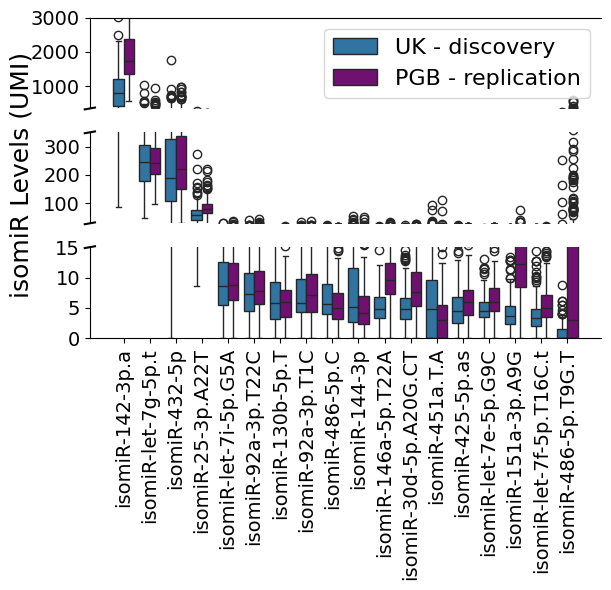

In [63]:
train_means = X_train_raw.median(axis = 0)

# Sorting the isomiRs by their means (largest to smallest)
sorted_isomiRs  = X_train_raw.mean(axis = 0).index[np.argsort(-train_means)] # Sort in descending order

# melt train/test dfs
melted_train_raw = pd.melt(X_train_raw, var_name = 'isomiR', value_name = 'Levels')
melted_train_raw['cohort'] = 'UK - discovery'

melted_test_raw = pd.melt(X_test_raw, var_name = 'isomiR', value_name = 'Levels')
melted_test_raw['cohort'] = 'PGB - replication'

#combine together 
melted_train_raw = pd.concat([melted_train_raw,melted_test_raw])

melted_train_raw['isomiR'] = pd.Categorical(
    melted_train_raw['isomiR'], categories=sorted_isomiRs, ordered=True
)


sorted_isomiRs = [
    col.replace("hsa", "isomiR") if "let" in col else
    col.replace("hsa-", "iso") if "miR" in col else col
    for col in sorted_isomiRs
]


# change isomiR names
melted_train_raw['isomiR'] = np.where(
    melted_train_raw['isomiR'].str.contains("let"),
    melted_train_raw['isomiR'].str.replace("hsa", "isomiR", regex=False),
    melted_train_raw['isomiR'].str.replace("hsa-", "iso", regex=False)
)

# Plotting with two breaks in the y-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [2, 2, 2]},figsize = (6,6))

# Upper part
sns.boxplot(data=melted_train_raw, x='isomiR', y='Levels', ax=ax1, order=sorted_isomiRs, hue = 'cohort',
           palette=['#1f77b4', 'purple'])
ax1.set_ylim(350, 3000)  # Upper range
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)  # Remove right y-axis
ax1.tick_params(bottom=False, left=True)
ax1.set_ylabel('')  # Remove y-axis title
ax1.yaxis.tick_left()  # Remove right y-axis ticks
ax1.legend(fontsize=16)
ax1.get_legend().set_visible(True)
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize=14)

# Middle part
sns.boxplot(data=melted_train_raw, x='isomiR', y='Levels', ax=ax2, order=sorted_isomiRs,hue = 'cohort',
           palette=['#1f77b4', 'purple'])
ax2.set_ylim(30, 350)  # Middle range
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)  # Remove right y-axis
ax2.tick_params(bottom=False, left=True)
ax2.set_ylabel('')  # Remove y-axis title
ax2.yaxis.tick_left()  # Remove right y-axis ticks
ax2.get_legend().set_visible(False)
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=14)

# Lower part
sns.boxplot(data=melted_train_raw, x='isomiR', y='Levels', ax=ax3, order=sorted_isomiRs,hue = 'cohort',
           palette=['#1f77b4', 'purple'])
ax3.set_ylim(0, 15)  # Lower range
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)  # Remove right y-axis
ax3.set_ylabel('')  # Remove y-axis title
ax3.yaxis.tick_left()  # Remove right y-axis ticks
ax3.get_legend().set_visible(False)

# Adding the diagonal lines to indicate the breaks
d = 0.01  # Proportion of the vertical distance for the diagonal line

# Break between ax1 and ax2
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)
#ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
#ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# Break between ax2 and ax3
kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-d, +d), (-d, +d), **kwargs)
#ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs.update(transform=ax3.transAxes)
ax3.plot((-d, +d), (1 - d, 1 + d), **kwargs)
#ax3.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# Adding unified y-axis label
fig.text(-0.01, 0.7, 'isomiR Levels (UMI)', va='center', rotation='vertical', fontsize=18,)

# Enhancing x-axis labels
ax3.set_xlabel('')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90, fontsize=14)
ax3.set_yticklabels(ax3.get_yticklabels(),fontsize=14)

# Adjust layout and show the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("graphs/S5a.eps", format='eps', dpi=300, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


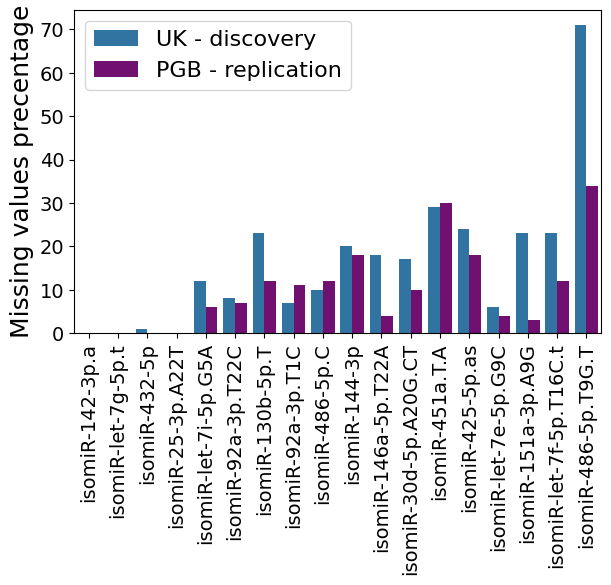

In [64]:
missing_values_train = np.round(X_train_raw.apply(lambda x: sum(x == 0), axis =0) / X_train_raw.shape[0] *100,0)
missing_values_test = np.round(X_test_raw.apply(lambda x: sum(x == 0), axis =0) / X_test_raw.shape[0] *100,0)

missing_order = missing_values_train.index[np.argsort(missing_values_train)]
missing_order = [
    col.replace("hsa", "isomiR") if "let" in col else
    col.replace("hsa-", "iso") if "miR" in col else col
    for col in sorted_isomiRs
]

missing_values_df = pd.DataFrame({'missing' : pd.concat([missing_values_train,missing_values_test]),
                                  'cohort' : np.repeat(['UK - discovery','PGB - replication'],len(missing_values_train)),
                                  'isomiR' : missing_values_train.index.tolist() * 2})

# change isomiR names
missing_values_df['isomiR'] = np.where(
    missing_values_df['isomiR'].str.contains("let"),
    missing_values_df['isomiR'].str.replace("hsa", "isomiR", regex=False),
    missing_values_df['isomiR'].str.replace("hsa-", "iso", regex=False)
)

plt.figure(figsize=(6.8, 4.2)) 
sns.barplot(data=missing_values_df, x='isomiR', y='missing', order=missing_order, hue = 'cohort',
           palette=['#1f77b4', 'purple'],legend=True)
plt.xticks(fontsize=14,  rotation=90)
plt.yticks(fontsize=14)
plt.ylabel('Missing values precentage',fontsize=18)
plt.xlabel('')
plt.legend(fontsize=16, frameon=True)
plt.savefig("graphs/S5b.eps", format='eps', dpi=300, bbox_inches='tight')

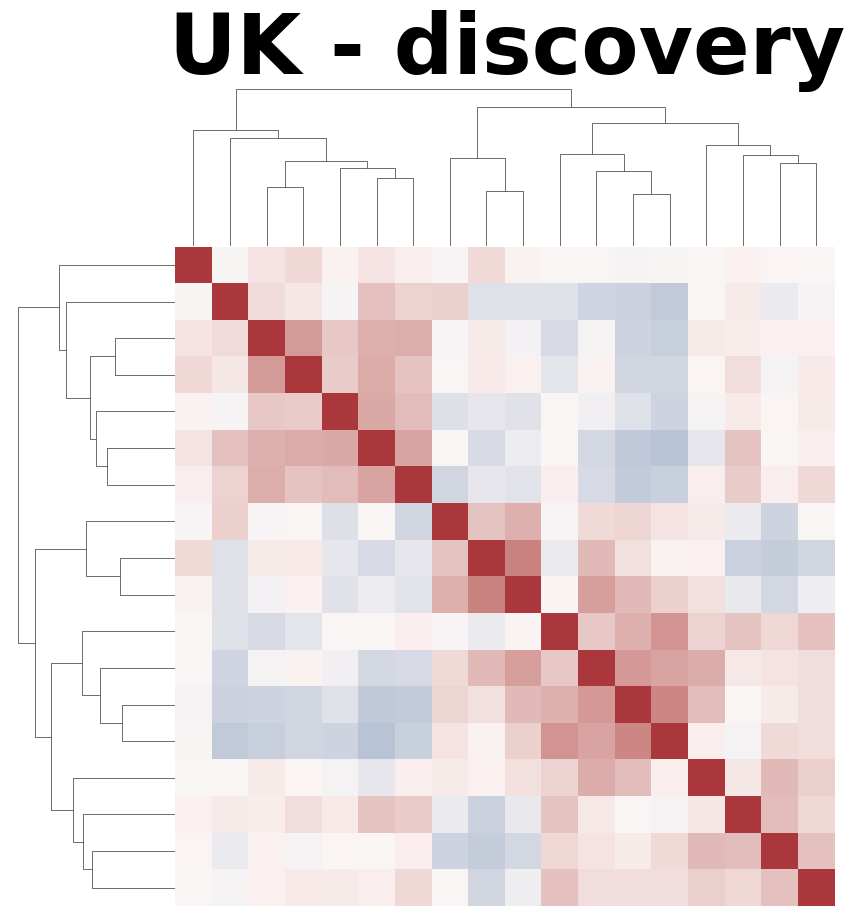

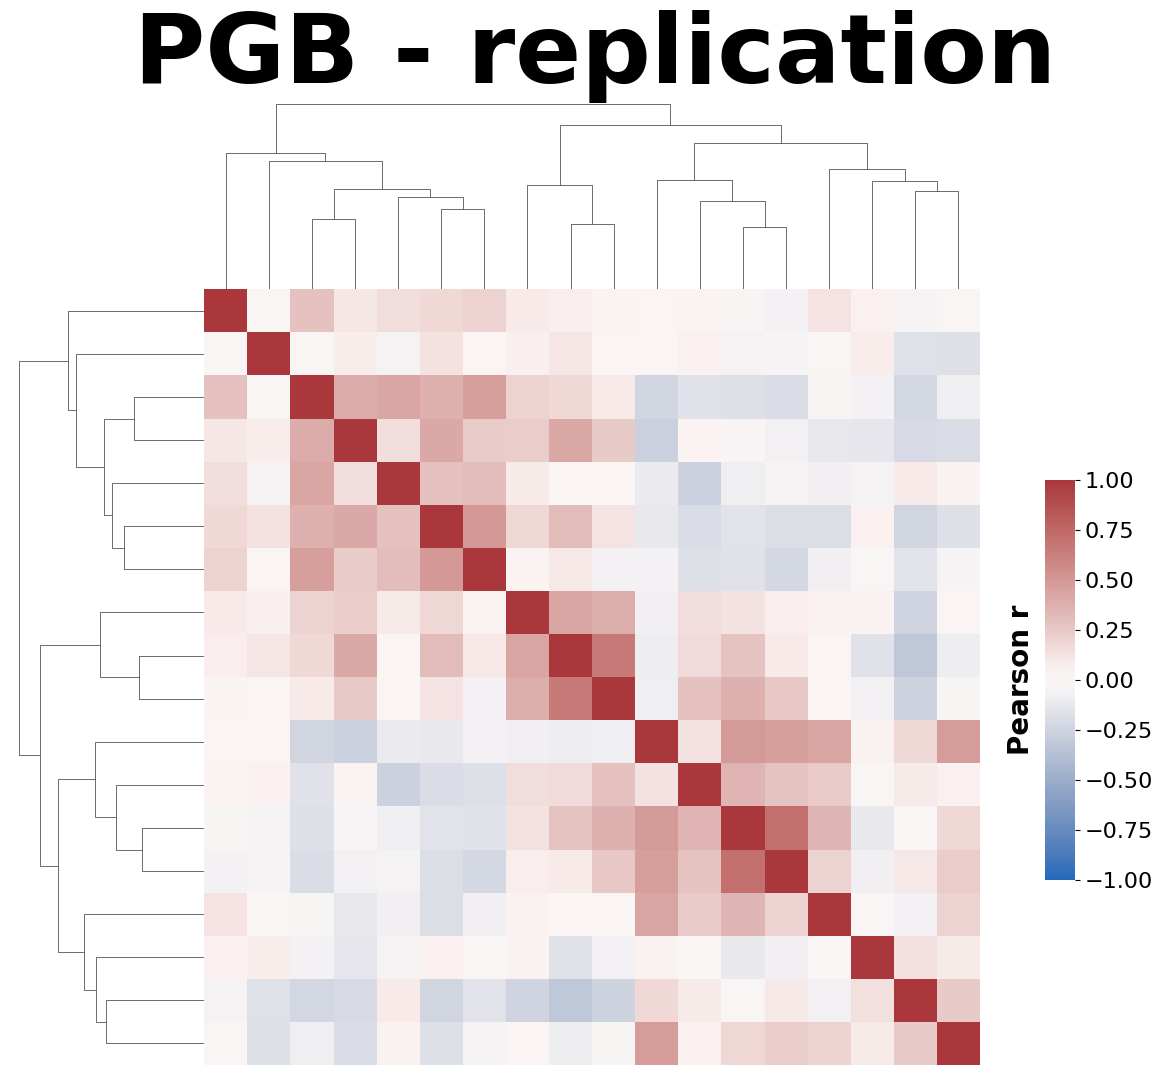

In [95]:
cmap = sns.color_palette("vlag", as_cmap=True)
r_cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

cluster_train = sns.clustermap(X_train_filtered.corr(),
                               cmap = cmap,
                               center = 0, vmin = -1, vmax =1,
                               row_cluster=True,
                               col_cluster=True,xticklabels = False, yticklabels = False)

row_linkage = cluster_train.dendrogram_row.linkage
col_linkage = cluster_train.dendrogram_col.linkage
cluster_train.cax.set_visible(False)

cluster_train.fig.suptitle("UK - discovery", fontsize=60, fontweight='bold',y=1.07, x = 0.6)
cluster_train.fig.set_size_inches(8.5, 8.5)
plt.savefig("graphs/S5c.eps", format='eps', dpi=300, bbox_inches='tight')

cluster_test = sns.clustermap(
    X_test_raw.corr(), 
    cmap = cmap,
    center = 0, vmin = -1, vmax =1,
    row_cluster=True,
    col_cluster=True,
    xticklabels = False, yticklabels = False,
    row_linkage=row_linkage,
    col_linkage=col_linkage)
cluster_test.fig.set_size_inches(10, 10)
cluster_test.ax_heatmap.collections[0].colorbar.set_label("Pearson r", labelpad=-105,fontsize=20, weight='bold')
cluster_test.ax_heatmap.collections[0].colorbar.ax.tick_params(labelsize=16)
cluster_test.ax_cbar.set_position((1.05, .2, .03, .4))
cluster_test.fig.suptitle("PGB - replication", fontsize=70, fontweight='bold',y=1.07, x = 0.6)
plt.savefig("graphs/S5d.eps", format='eps', dpi=300, bbox_inches='tight')

## CTL analysis of isomiRs

Text(2.3, 12.3, '***')

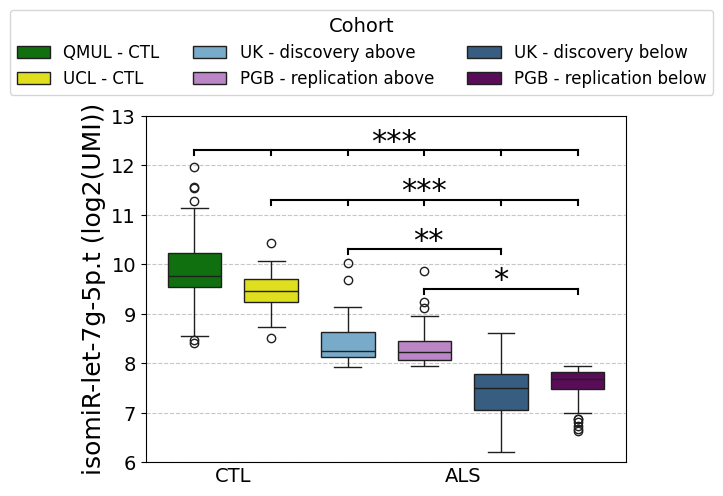

In [66]:
# add ctl levels for isomiR-=let-7g-5p.t
add_ctl = pd.DataFrame({'isomiR' : 'isomiR-let-7g-5p.t',
                        'Levels' : CTL_df['hsa-let-7g-5p.t'].tolist() + CTL_df_test['hsa-let-7g-5p.t'].tolist(),
                       "cohort" : np.repeat(['QMUL - CTL','UCL - CTL'],[CTL_df.shape[0],CTL_df_test.shape[0]])})

sub_groups = ["below" if x == 0 else "above" for x in pd.concat([miR_181_dfs['UK_binary_chosen_isomiRs']['isomiR-let-7g-5p.t'],
                                                    miR_181_dfs['PGB_binary_chosen_isomiRs']['isomiR-let-7g-5p.t'].drop(index = 148)])]
iso_let7 = melted_train_raw[melted_train_raw.isomiR == 'isomiR-let-7g-5p.t']
iso_let7['cohort'] = iso_let7['cohort'] + ' ' + sub_groups

iso_let7 = pd.concat([iso_let7,add_ctl],axis = 0)

iso_let7['Form'] = 'isomiR'
iso_let7['Condition'] = np.repeat(['ALS','CTL'],[sum(melted_train_raw.isomiR == 'isomiR-let-7g-5p.t'),
                                                          CTL_df.shape[0]+CTL_df_test.shape[0]])

iso_let7['overall_cohort'] = iso_let7.cohort.replace('below|above','',regex = True)

iso_let7['Scaled Levels'] = iso_let7.Levels / CTL_df['hsa-let-7g-5p.t'].mean()

# Define the desired order
conditions_order = ['CTL','ALS']  # your conditions
cohorts_order = ['QMUL - CTL','UCL - CTL',
                 'UK - discovery above','PGB - replication above' ,
                 'UK - discovery below', 'PGB - replication below']  # your cohorts (change to actual cohorts you have)

# Filter actual cohort-condition combinations in data
actual_groups = iso_let7.groupby(['Condition', 'cohort']).size().reset_index().iloc[:, :2]

# Create a dictionary for positions
position_dict = {}
current_pos = 0
tick_positions = []
tick_labels = []

for cond in conditions_order:
    cohorts_in_cond = actual_groups[actual_groups['Condition'] == cond]['cohort']
    num_cohorts = len(cohorts_in_cond)
    start_pos = current_pos
    for cohort in cohorts_order:
        if cohort in cohorts_in_cond.values:
            position_dict[(cond, cohort)] = current_pos
            current_pos += 1
    end_pos = current_pos - 1
    tick_positions.append((start_pos + end_pos) / 2)
    tick_labels.append(cond)
    current_pos += 1  # add a gap between conditions

iso_let7['position'] = iso_let7.apply(lambda row: position_dict[(row['Condition'], row['cohort'])], axis=1)


iso_let7['log2_levels'] = np.log2(iso_let7['Levels'])

fig, ax = plt.subplots(figsize=(6.2, 4.5))

# Boxplot using explicit positions
sns.boxplot(
    data=iso_let7,
    x='position',
    y='log2_levels',
    hue='cohort',
    palette=['green','yellow','#6baed6','#c17ccf','#2b5d8c','#660066'],
    dodge=False,  # Important to keep False here, since positions are already explicit
    ax=ax,
    width=0.7
)

# Set custom xticks
ax.set_xticks([0.5, 3.5])
ax.set_xticklabels(tick_labels, fontsize=14)

plt.xlabel("", fontsize=18)
plt.ylabel("isomiR-let-7g-5p.t (log2(UMI))", fontsize=18)
plt.grid(True, linestyle="--", alpha=0.7, axis="y")
plt.yticks(fontsize=14)
plt.ylim(6,13)
ax.tick_params(axis='x', which='major', length=0)

# Adjust legend
ax.legend(
    title='Cohort',
    title_fontsize=14,
    fontsize=12,
    loc='upper left',
    ncol = 3,
    bbox_to_anchor = (-0.3, 1.33)
)

# plot signifiacne lines

# plt.plot([0, 1], [11.8, 11.8],c  = 'black')
# plt.plot([0, 0], [11.8, 11.7],c  = 'black')
# plt.plot([1, 1], [11.8, 11.7],c  = 'black')
# plt.text(0.2, 11.8, '***', fontsize = 22)

plt.plot([2, 4], [10.3, 10.3],c  = 'black')
plt.plot([2, 2], [10.3, 10.2],c  = 'black')
plt.plot([4, 4], [10.3, 10.2],c  = 'black')
plt.text(2.85, 10.3, '**', fontsize = 22)

plt.plot([3, 5], [9.5, 9.5],c  = 'black')
plt.plot([3, 3], [9.5, 9.4],c  = 'black')
plt.plot([5, 5], [9.5, 9.4],c  = 'black')
plt.text(3.9, 9.5, '*', fontsize = 22)

plt.plot([1, 5], [11.3, 11.3],c  = 'black')
plt.plot([1, 1], [11.3, 11.2],c  = 'black')
plt.plot([2, 2], [11.3, 11.2],c  = 'black')
plt.plot([3, 3], [11.3, 11.2],c  = 'black')
plt.plot([4, 4], [11.3, 11.2],c  = 'black')
plt.plot([5, 5], [11.3, 11.2],c  = 'black')
plt.text(2.7, 11.3, '***', fontsize = 22)

plt.plot([0, 5], [12.3, 12.3],c  = 'black')
plt.plot([1, 1], [12.3, 12.2],c  = 'black')
plt.plot([0, 0], [12.3, 12.2],c  = 'black')
plt.plot([2, 2], [12.3, 12.2],c  = 'black')
plt.plot([3, 3], [12.3, 12.2],c  = 'black')
plt.plot([4, 4], [12.3, 12.2],c  = 'black')
plt.plot([5, 5], [12.3, 12.2],c  = 'black')
plt.text(2.3, 12.3, '***', fontsize = 22)


# plt.plot([0, 2], [3300, 3300],c  = 'black')
# plt.plot([0, 0], [3300, 3100],c  = 'black')
# plt.plot([2, 2], [3300, 3100],c  = 'black')
# plt.text(0.9, 3250, '***', fontsize = 22)

# plt.plot([0, 3], [3700, 3700],c  = 'black')
# plt.plot([0, 0], [3700, 3500],c  = 'black')
# plt.plot([3, 3], [3700, 3500],c  = 'black')
# plt.text(1.35, 3650, '***', fontsize = 22)

# plt.plot([3, 1], [2750, 2750],c  = 'black')
# plt.plot([1, 1], [2750, 2550],c  = 'black')
# plt.plot([3, 3], [2750, 2550],c  = 'black')
# plt.text(1.8, 2700, '***', fontsize = 22)


In [67]:
# One-way ANOVA for differences between cohorts
model = ols('Levels ~ C(cohort)',
            data=iso_let7).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Run Tukey HSD
tukey = pairwise_tukeyhsd(endog=iso_let7['Levels'], groups=iso_let7['cohort'], alpha=0.05)

# Convert to DataFrame
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
tukey_df
# # Filter for non-significant comparisons
# not_rejected = tukey_df[tukey_df['reject'] == True]

# not_rejected

                 sum_sq     df           F        PR(>F)
C(cohort)  5.353879e+07    5.0  137.745018  8.149875e-92
Residual   3.910125e+07  503.0         NaN           NaN


group1                   group2  meandiff   p-adj  \
0   PGB - replication above  PGB - replication below -125.7970  0.0189   
1   PGB - replication above               QMUL - CTL  719.5994  0.0000   
2   PGB - replication above                UCL - CTL  395.9591  0.0000   
3   PGB - replication above     UK - discovery above   27.1596  0.9882   
4   PGB - replication above     UK - discovery below -148.3683  0.0072   
5   PGB - replication below               QMUL - CTL  845.3964  0.0000   
6   PGB - replication below                UCL - CTL  521.7561  0.0000   
7   PGB - replication below     UK - discovery above  152.9566  0.0039   
8   PGB - replication below     UK - discovery below  -22.5713  0.9946   
9                QMUL - CTL                UCL - CTL -323.6403  0.0000   
10               QMUL - CTL     UK - discovery above -692.4398  0.0000   
11               QMUL - CTL     UK - discovery below -867.9677  0.0000   
12                UCL - CTL     UK - discovery above -368.7995  0.0000   
13                UCL - CTL     UK - discovery below -544.3274  0.0000   
14     UK - discovery above     UK - discovery below -175.5279  0.0015   

       lower     upper  reject  
0  -238.6862  -12.9078    True  
1   605.3501  833.8488    True  
2   261.8427  530.0755    True  
3   -94.8606  149.1799   False  
4  -270.3885  -26.3480    True  
5   733.4002  957.3927    True  
6   389.5538  653.9584    True  
7    33.0434  272.8698    True  
8  -142.4845   97.3419   False  
9  -457.0060 -190.2747    True  
10 -813.6344 -571.2453    True  
11 -989.1622 -746.7732    True  
12 -508.8795 -228.7195    True  
13 -684.4074 -404.2474    True  
14 -304.0741  -46.9817    True

### General isomiR-let-7g-5p.t levels in different clinical features

In [68]:
# filter by chosen columns for clinical data
train_clinical = train_mature[non_mir_columns]
test_clinical = test_mature[non_mir_columns]

C9_train = pd.read_csv('C9_status_UK.csv', index_col='patient').replace({"Negative":"Non-carrier",
                                                                         "Not done" : 'Non-carrier',
                                                                        'Positive': 'Carrier'})

C9_test = pd.read_excel('Cohen Isoforms - C9 status (2025.07.28).xlsx', index_col = 'patient').replace({0:"Non-carrier",
                                                                                                        1: 'Carrier'})
C9_test.drop(columns = 'ID', inplace = True)

In [69]:
train_clinical = pd.merge(train_clinical,C9_train,left_index=True, right_index=True)

iso_clinical_df = pd.concat([train_clinical.reset_index(drop = True),
                             miR_181_dfs['UK_binary_chosen_isomiRs']['isomiR-let-7g-5p.t'],
                            X_train_raw['hsa-let-7g-5p.t'].reset_index(drop =True)],
                             axis = 1)

iso_clinical_df.rename({'hsa-let-7g-5p.t' : 'raw-isomiR-let-7g-5p.t',
                       'C9 ': 'C9 status'},axis = 1, inplace = True)

iso_clinical_df.replace({
        'Sex': {True : 'Male', False : 'Female'},
        'Riluzole treatment': {True : 'Yes', False : 'No'},
        'Disease primary site': {True : 'Bulber', False : 'Non-bulber'}
    }, inplace=True)
iso_clinical_df['cohort'] = 'UK - discovery'

test_clinical = pd.merge(test_clinical,C9_test,left_index=True, right_index=True)

iso_clinical_df_rep = pd.concat([test_clinical.reset_index(drop = True),
                                 miR_181_dfs['PGB_binary_chosen_isomiRs']['isomiR-let-7g-5p.t'].drop(index = 148).reset_index(drop = True),
                                 X_test_raw['hsa-let-7g-5p.t'].reset_index(drop =True)],
                                 axis = 1)

iso_clinical_df_rep.rename({'hsa-let-7g-5p.t' : 'raw-isomiR-let-7g-5p.t'},axis = 1, inplace = True)

iso_clinical_df_rep.replace({
        'Sex': {1 : 'Male', 0 : 'Female'},
        'Riluzole treatment': {True : 'Yes', False : 'No'},
        'Disease primary site': {True : 'Bulber', False : 'Non-bulber'}
    }, inplace=True)
iso_clinical_df_rep['cohort'] = 'PGB - replication'

# iso_clinical_df.groupby('isomiR-let-7g-5p.t')['Sex'].value_counts()

In [89]:
iso_clinical_df[['isomiR-let-7g-5p.t','C9 status']].value_counts()

isomiR-let-7g-5p.t  C9 status  
1                   Non-carrier    72
0                   Non-carrier    70
                    Carrier         7
1                   Carrier         5
dtype: int64

In [90]:
iso_clinical_df_rep[['isomiR-let-7g-5p.t','C9 status']].value_counts()

isomiR-let-7g-5p.t  C9 status  
0                   Non-carrier    92
1                   Non-carrier    88
0                   Carrier        12
1                   Carrier         8
dtype: int64

Text(0.47, 700, '*')

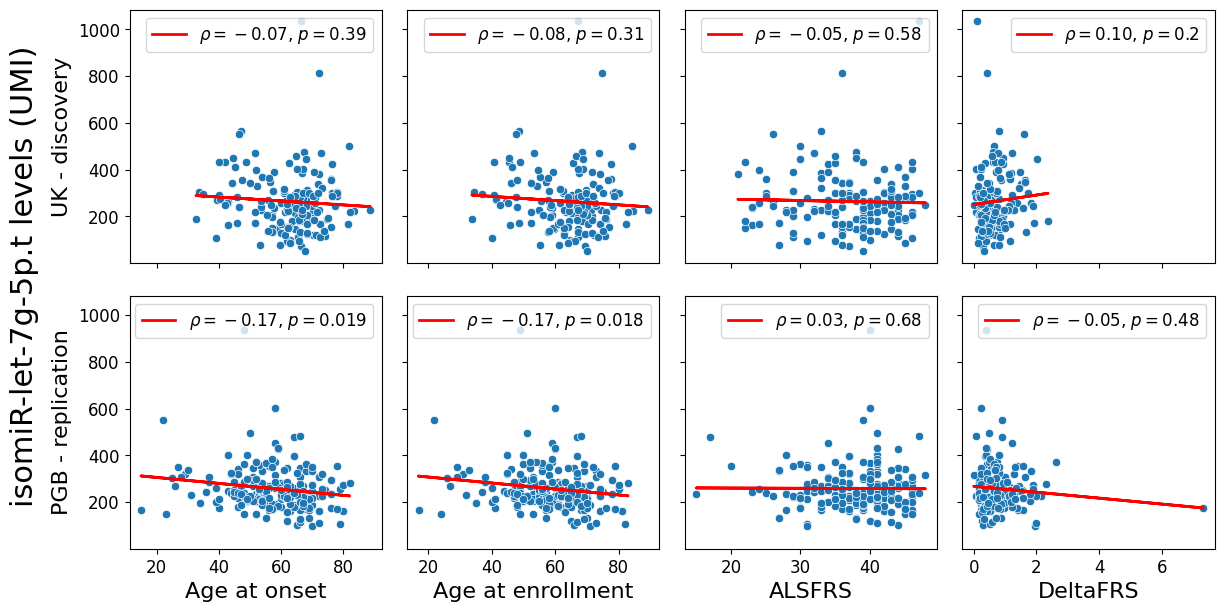

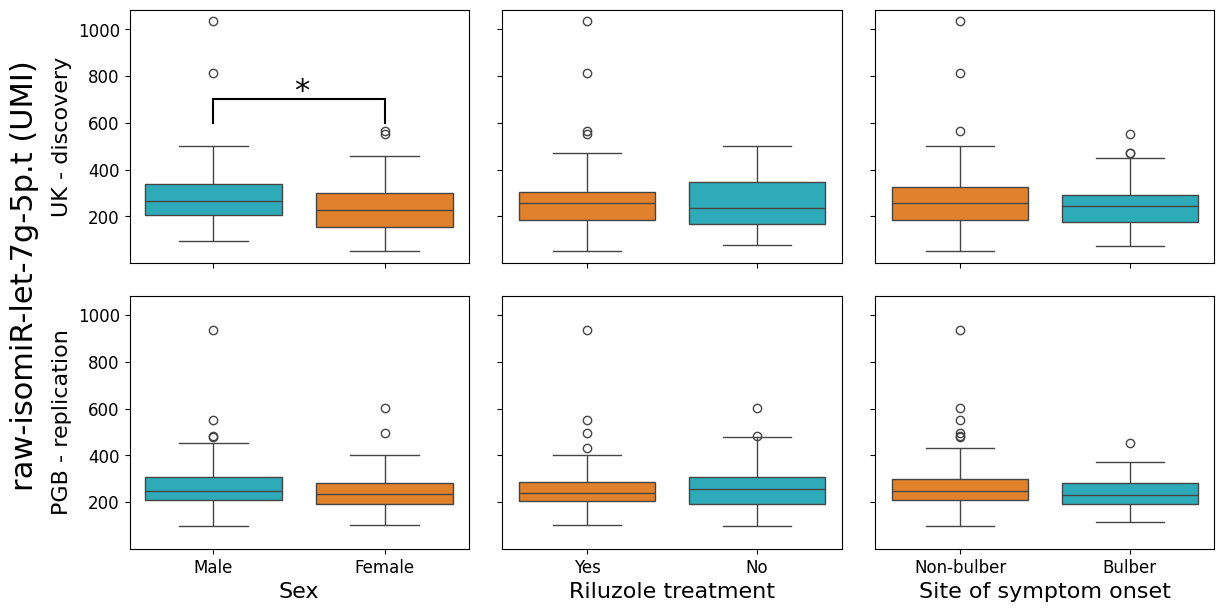

In [70]:
merged_clinical_data = pd.concat([iso_clinical_df.reset_index(drop = True),
                             iso_clinical_df_rep.reset_index(drop = True)],
                             axis = 0)
merged_clinical_data.rename({'Disease primary site' : 'Site of symptom onset'}, axis = 1, inplace = True)
merged_clinical_data.index = X_train.index.append(X_test.index)

uk_ages = pd.read_excel('Clinical info for Yahel.xlsx',index_col='index case')
uk_ages.index = uk_ages.index.str.strip()
uk_ages = uk_ages[uk_ages.index.isin(X_train.index)]
uk_ages = uk_ages.loc[X_train.index]
uk_onset = uk_ages['Age of onset ']

pgb_ages = pd.read_excel('Hornstein PGB Clin Data - plasma & CSF (2023.09.08).xlsx',
              sheet_name='Plasma clin data',
              index_col='ID')
pgb_ages = pgb_ages.loc[X_test.index]
pgb_onset = pgb_ages['OsAge']

merged_clinical_data.loc[uk_onset.index,'Age at onset'] = uk_onset
merged_clinical_data.loc[pgb_onset.index,'Age at onset'] = pgb_onset

merged_clinical_data['Age at enrollment'] = pd.concat([uk_ages['Age of enrolment'],pgb_ages['CollAge']], axis = 0)

binary_features = ['Sex','Riluzole treatment','Site of symptom onset']
cont_features = ['Age at onset','Age at enrollment','ALSFRS','DeltaFRS',]

# for some reason 1 value is NaN in the isomiR binarization
# I manually fix it as it levels are above median
merged_clinical_data['isomiR-let-7g-5p.t'][merged_clinical_data['isomiR-let-7g-5p.t'].isnull()] = 1

correlation_plot(df= merged_clinical_data,features = cont_features,
                 y = 'raw-isomiR-let-7g-5p.t',cor_method = 'spearman',
                 cohort_col = 'cohort', figsize = (14,7), wsapce=0.1, hspace=0.13)

hue_orders = {
    'Riluzole treatment': ['Yes', 'No'],
    'Sex': ['Female', 'Male'],
    'Site of symptom onset': ['Bulbar', 'Non-bulbar',]
}

fig, axes  = box_plots(df= merged_clinical_data,
                       features = binary_features,
                       hue_orders = hue_orders,
                       y = 'raw-isomiR-let-7g-5p.t',
                       cohort_col = 'cohort',
                       figsize = (14,7), wsapce=0.1, hspace=0.13)

# axes[0, 0].axhline(y=10, color='black', linestyle='--', linewidth=1.5)
# axes[0, 0].axhline(y=20, color='black', linestyle='--', linewidth=1.5)

axes[0, 0].plot([0, 1], [700, 700],c  = 'black')
axes[0, 0].plot([0, 0], [700, 600],c  = 'black')
axes[0, 0].plot([1, 1], [700, 600],c  = 'black')
axes[0, 0].text(0.47, 700, '*', fontsize = 22)

In [92]:
for cohort in merged_clinical_data.cohort.unique():
        sub_df = merged_clinical_data[merged_clinical_data['cohort'] == cohort]

        for feature in binary_features:
            vals = sub_df[feature].unique()
            a = vals[0]
            b = vals[1]
            print(cohort, feature,'\n',mannwhitneyu(sub_df['raw-isomiR-let-7g-5p.t'][sub_df[feature] == a], 
                         sub_df['raw-isomiR-let-7g-5p.t'][sub_df[feature] == b],
                         alternative='two-sided'))

            

UK - discovery Sex 
 MannwhitneyuResult(statistic=3502.0, pvalue=0.019621996316711875)
UK - discovery Riluzole treatment 
 MannwhitneyuResult(statistic=2565.0, pvalue=0.6563469439148275)
UK - discovery Site of symptom onset 
 MannwhitneyuResult(statistic=2934.0, pvalue=0.28216090464166754)
PGB - replication Sex 
 MannwhitneyuResult(statistic=4398.0, pvalue=0.17563508199380118)
PGB - replication Riluzole treatment 
 MannwhitneyuResult(statistic=4112.0, pvalue=0.42131910337958123)
PGB - replication Site of symptom onset 
 MannwhitneyuResult(statistic=4378.0, pvalue=0.18211608122279455)


In [74]:
['raw-isomiR-let-7g-5p.t'] + cont_features 

['raw-isomiR-let-7g-5p.t',
 'Age at onset',
 'Age at enrollment',
 'ALSFRS',
 'DeltaFRS']

cohort             isomiR-let-7g-5p.t
PGB - replication  0                     198.317305
                   1                     324.114272
UK - discovery     0                     175.746019
                   1                     351.273917
Name: raw-isomiR-let-7g-5p.t, dtype: float64
Cohen's D for age differences in discovery is 1.8 and in replication is 1.6


Text(0.9, 720, '***')

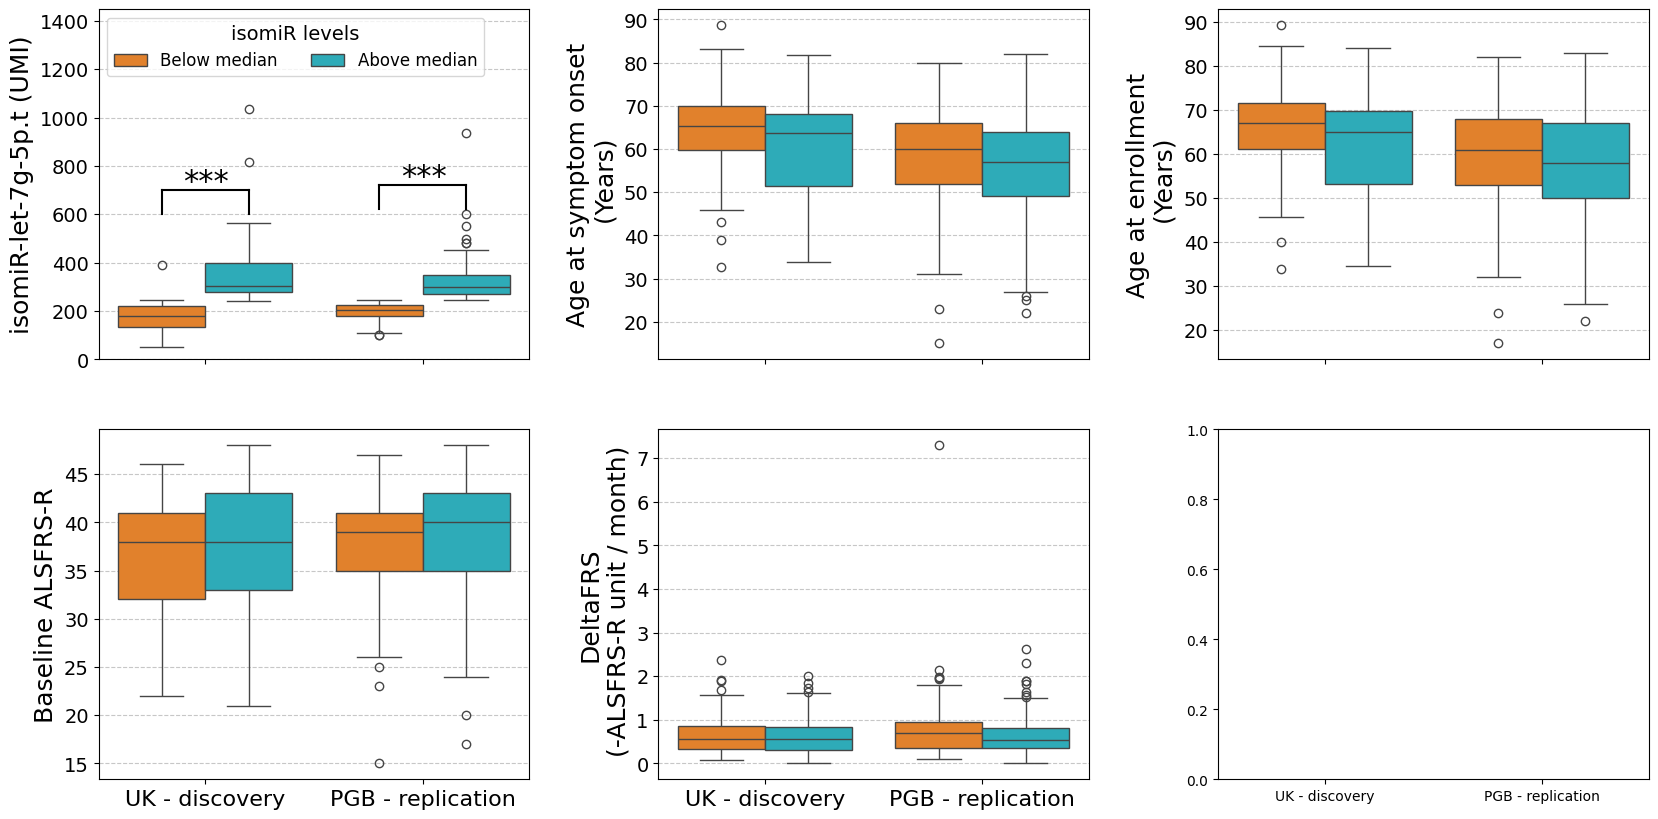

In [81]:
print(merged_clinical_data.groupby(['cohort','isomiR-let-7g-5p.t'])['raw-isomiR-let-7g-5p.t'].mean())

print("Cohen's D for age differences in discovery is 1.8 and in replication is 1.6")

y_labels = {'Age at onset' : 'Age at symptom onset\n (Years)',
            'Age at enrollment' : 'Age at enrollment\n (Years)',
           'ALSFRS' : 'Baseline ALSFRS-R',
           'DeltaFRS' : 'DeltaFRS\n (-ALSFRS-R unit / month)',
           'raw-isomiR-let-7g-5p.t' : 'isomiR-let-7g-5p.t (UMI)'}

fig, axes  = box_plot_binary(merged_clinical_data,['raw-isomiR-let-7g-5p.t'] + cont_features ,
               'cohort',hue = 'isomiR-let-7g-5p.t', figsize = (20,10),
               wsapce = 0.3,hspace= 0.2, y_labels=y_labels,ncol=2,nrow=3)

axes[0].plot([-0.2, 0.2], [700, 700],c  = 'black')
axes[0].plot([-0.2, -0.2], [700, 600],c  = 'black')
axes[0].plot([0.2, 0.2], [700, 600],c  = 'black')
axes[0].text(-0.1, 700, '***', fontsize = 22)

axes[0].plot([0.8, 1.2], [720, 720],c  = 'black')
axes[0].plot([0.8, 0.8], [720, 620],c  = 'black')
axes[0].plot([1.2, 1.2], [720, 620],c  = 'black')
axes[0].text(0.9, 720, '***', fontsize = 22)

Sex difference between 0 & 1 chi = 2.6862026862026864, p-value = 0.10122077690806007
0
1
Sex difference between 0 & 1 chi = 0.5900349650349662, p-value = 0.4424055982746069
0
1


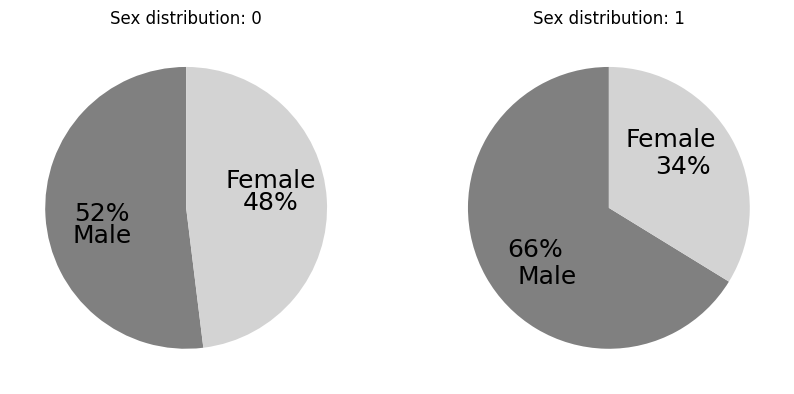

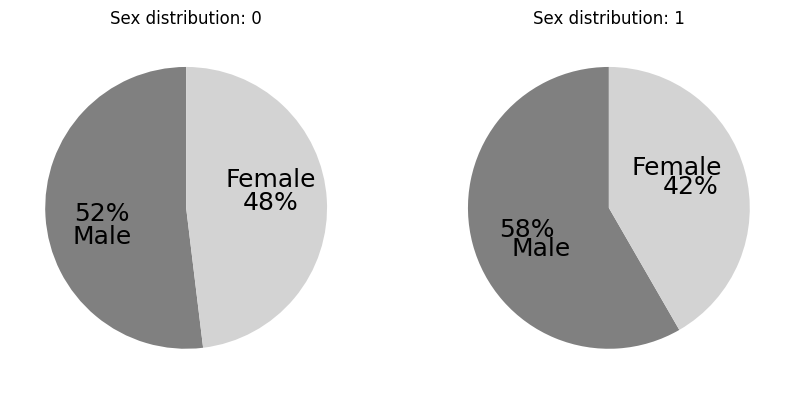

In [97]:
# sex distribution in high/low levels
pie_plot(merged_clinical_data[merged_clinical_data.cohort == 'UK - discovery'],
         'Sex','isomiR-let-7g-5p.t', label_coord = [0.6,3.2,0.5,1]) 

pie_plot(merged_clinical_data[merged_clinical_data.cohort != 'UK - discovery'],
         'Sex','isomiR-let-7g-5p.t', label_coord = [0.6,3.3,0.5,1.1]) 

Site of symptom onset difference between 0 & 1 chi = 0.029034690799396683, p-value = 0.8646989623168262
0
1
Site of symptom onset difference between 0 & 1 chi = 1.5965578297114686, p-value = 0.20639169936183457
0
1


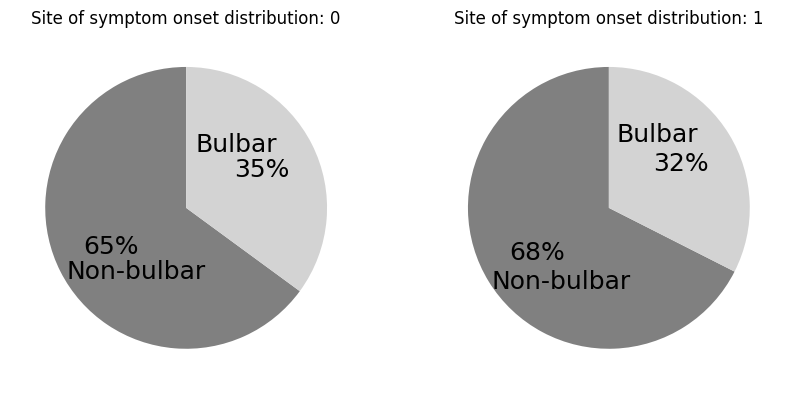

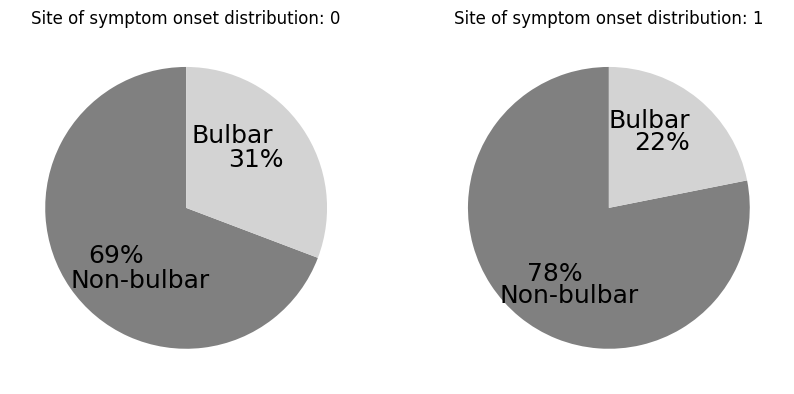

In [99]:
# Site of symptom onset in high/low levels
pie_plot(merged_clinical_data[merged_clinical_data.cohort == 'UK - discovery'],
         'Site of symptom onset','isomiR-let-7g-5p.t',
         labels_dict = {'Non-bulber' : 'Non-bulbar', 'Bulber' : 'Bulbar'},
         label_coord = [0.4,1,0.4,1]) 

pie_plot(merged_clinical_data[merged_clinical_data.cohort != 'UK - discovery'],
         'Site of symptom onset','isomiR-let-7g-5p.t',
         labels_dict = {'Non-bulber' : 'Non-bulbar', 'Bulber' : 'Bulbar'},
         label_coord = [0.4,0.9,0.45,0.8]) 

Riluzole treatment difference between 0 & 1 chi = 0.5023445463812437, p-value = 0.47847175639613493
0
1
Riluzole treatment difference between 0 & 1 chi = 2.1048965545234184, p-value = 0.14682827250268513
0
1


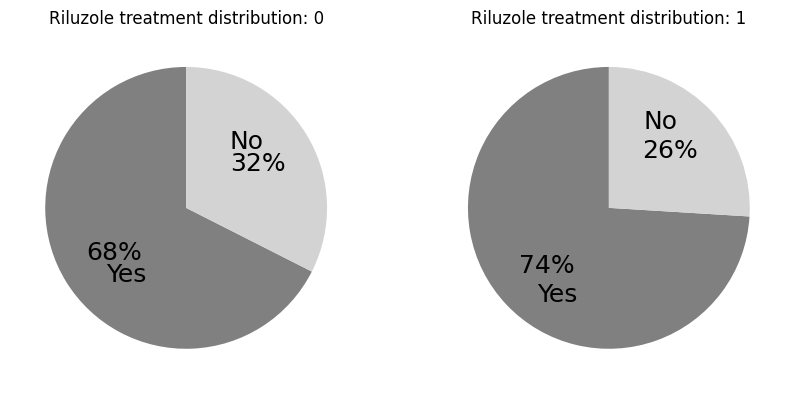

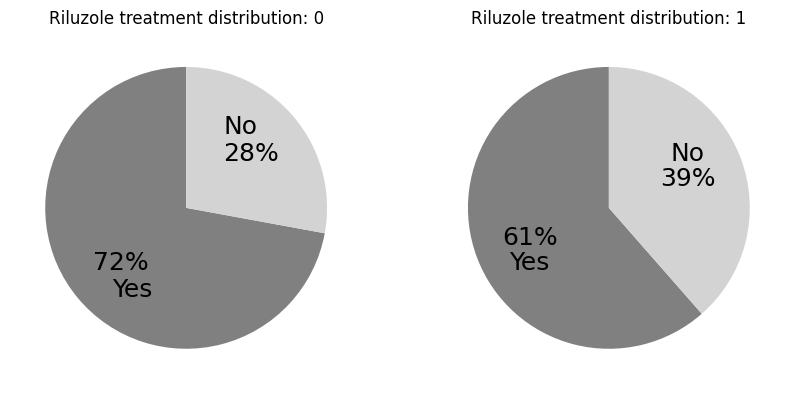

In [61]:
# Riluzole treatment in high/low levels
pie_plot(merged_clinical_data[merged_clinical_data.cohort == 'UK - discovery'],
         'Riluzole treatment','isomiR-let-7g-5p.t',
         labels_dict = {'Yes' : 'Yes', 'No' : 'No'},
         label_coord = [0.5,0.9,0.5,0.9]) 

pie_plot(merged_clinical_data[merged_clinical_data.cohort != 'UK - discovery'],
         'Riluzole treatment','isomiR-let-7g-5p.t',
         labels_dict = {'Yes' : 'Yes', 'No' : 'No'},
         label_coord = [0.5,0.9,0.6,1.1]) 

C9 status difference between 0 & 1 chi = 0.0903755868544601, p-value = 0.7637002166753172
0
1
C9 status difference between 0 & 1 chi = 0.26931980056980015, p-value = 0.6037884211178526
0
1


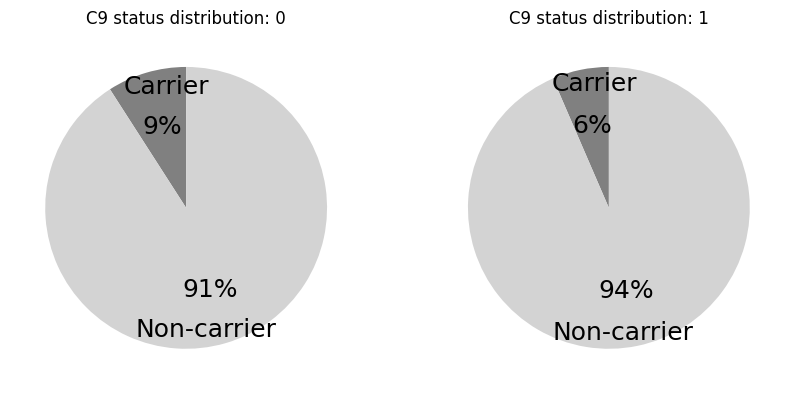

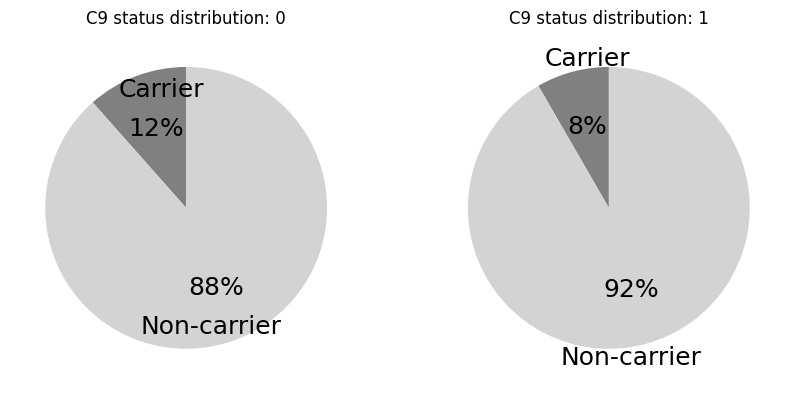

In [65]:
# Riluzole treatment in high/low levels
pie_plot(merged_clinical_data[merged_clinical_data.cohort == 'UK - discovery'],
         'C9 status','isomiR-let-7g-5p.t',
         labels_dict = {'Carrier' : 'Carrier', 'Non-carrier' : 'Non-carrier'},
         label_coord = [0.5,0.9,0.5,0.9]) 

pie_plot(merged_clinical_data[merged_clinical_data.cohort != 'UK - discovery'],
         'C9 status','isomiR-let-7g-5p.t',
         labels_dict = {'Carrier' : 'Carrier', 'Non-carrier' : 'Non-carrier'},
         label_coord = [0.5,0.9,0.6,1.1]) 

## miRNA targets 

In [14]:
import requests
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# function to get sequence of mRNAs as fasta format

def get_main_transcript_sequence(gene_name):
    server = "https://rest.ensembl.org"
    ext = f"/lookup/symbol/homo_sapiens/{gene_name}?expand=1"
    headers = {"Content-Type": "application/json"}
    r = requests.get(server + ext, headers=headers)

    if not r.ok:
        print(f"{gene_name} not found")
        return None

    data = r.json()
    transcripts = data.get("Transcript", [])
    for t in transcripts:
        if t.get("is_canonical"):
            transcript_id = t["id"]
            break
    else:
        transcript_id = transcripts[0]["id"]  # fallback

    # Get the sequence
    seq_req = f"/sequence/id/{transcript_id}?type=cdna"
    r2 = requests.get(server + seq_req, headers={"Content-Type": "text/plain"})
    if r2.ok:
        return SeqRecord(
            Seq(r2.text.strip()),
            id=f"{gene_name}|{transcript_id}",
            description=""
        )
    else:
        print(f"{gene_name} sequence fetch failed")
        return None


In [15]:
# get let-7g-5p targets based on miRCarta
mircarta_let_7_targets = pd.read_csv('miRCarta - targets.csv')
targets_gene = mircarta_let_7_targets['Gene name']


# ALS genes from Chen Eitan paper
ALS_genes_df = pd.read_excel('ALS_gene_list.xlsx',skiprows=2)
ALS_genes_df.rename(columns = {'Unnamed: 2' : 'ALSoD', 'Unnamed: 3' : 'PLOS genetics 2014',
                              'Unnamed: 4' : 'Manual review',
                               'miRNA Candidate\nGenes' : 'miRNA Candidate Genes',
                              'Pvalue\nORF': 'P-value - ORF',"Pvalue\n3'UTR" : "P-value - 3UTR"}, inplace=True)
ALS_genes_df.drop(index = 0 ,inplace=True)

# overlap between let-7g-5p targets and ALS genes
ALS_let_7_filter  = ALS_genes_df["Gene Symbol"].isin(targets_gene)
print(f'There are {ALS_let_7_filter.sum()} which are predicted targets of let-7g-5p \
and are associated to ALS')

overlap_genes = ALS_genes_df["Gene Symbol"][ALS_let_7_filter]
pd.set_option('display.max_rows', None)
display(mircarta_let_7_targets[mircarta_let_7_targets['Gene name'].isin(overlap_genes)])
pd.set_option('display.max_rows', 10)



There are 83 which are predicted targets of let-7g-5p and are associated to ALS


miRNA Gene name  \
19    hsa-let-7g-5p      AGO1   
29    hsa-let-7g-5p     SMAD2   
95    hsa-let-7g-5p     DISC1   
112   hsa-let-7g-5p   SLC11A2   
118   hsa-let-7g-5p       VCL   
210   hsa-let-7g-5p      SOD2   
220   hsa-let-7g-5p      MSI2   
287   hsa-let-7g-5p     ATXN2   
340   hsa-let-7g-5p    PIWIL1   
363   hsa-let-7g-5p     MAGI2   
453   hsa-let-7g-5p     PDE4B   
459   hsa-let-7g-5p   SIGMAR1   
474   hsa-let-7g-5p     G3BP1   
478   hsa-let-7g-5p      NOX4   
679   hsa-let-7g-5p   HNRNPA1   
680   hsa-let-7g-5p    DICER1   
878   hsa-let-7g-5p      AGO3   
923   hsa-let-7g-5p     CGNL1   
937   hsa-let-7g-5p      SUN3   
954   hsa-let-7g-5p      UTP6   
966   hsa-let-7g-5p   CSNK1G3   
987   hsa-let-7g-5p       PVR   
1079  hsa-let-7g-5p     GPR26   
1178  hsa-let-7g-5p   B4GALT6   
1195  hsa-let-7g-5p     SMAD3   
1240  hsa-let-7g-5p    RBFOX1   
1324  hsa-let-7g-5p      AGO2   
1431  hsa-let-7g-5p      DAB1   
1451  hsa-let-7g-5p      AGO4   
1606  hsa-let-7g-5p   IL18RAP   
1670  hsa-let-7g-5p   SLCO3A1   
1703  hsa-let-7g-5p       VDR   
1705  hsa-let-7g-5p      RALY   
1709  hsa-let-7g-5p    ZNF746   
1789  hsa-let-7g-5p    TNRC6B   
1810  hsa-let-7g-5p     PARP8   
1850  hsa-let-7g-5p     PRDM1   
1891  hsa-let-7g-5p     RBMS1   
1900  hsa-let-7g-5p     GRIA2   
2146  hsa-let-7g-5p    GPR132   
2288  hsa-let-7g-5p       HFE   
2404  hsa-let-7g-5p  SLC39A11   
2534  hsa-let-7g-5p    DIAPH3   
2577  hsa-let-7g-5p      MAPT   
2672  hsa-let-7g-5p     CELF4   
2713  hsa-let-7g-5p      TBK1   
2778  hsa-let-7g-5p      BBS9   
2817  hsa-let-7g-5p     MTHFR   
2818  hsa-let-7g-5p      TIA1   
2840  hsa-let-7g-5p    ELAVL1   
2912  hsa-let-7g-5p     CDH22   
2945  hsa-let-7g-5p     IKZF2   
3045  hsa-let-7g-5p     CNOT1   
3050  hsa-let-7g-5p   STARD13   
3083  hsa-let-7g-5p    TARBP2   
3109  hsa-let-7g-5p   HNRNPH1   
3143  hsa-let-7g-5p    LIN28A   
3177  hsa-let-7g-5p   ZNF512B   
3205  hsa-let-7g-5p     PRMT5   
3266  hsa-let-7g-5p    FBXO15   
3294  hsa-let-7g-5p    TNRC6A   
3307  hsa-let-7g-5p      NFIA   
3316  hsa-let-7g-5p      PON1   
3403  hsa-let-7g-5p      DGKD   
3493  hsa-let-7g-5p     PTPRT   
3566  hsa-let-7g-5p      XPO1   
3577  hsa-let-7g-5p     PCF11   
3591  hsa-let-7g-5p  HNRNPUL1   
3650  hsa-let-7g-5p     ITPR2   
3729  hsa-let-7g-5p    TRIM32   
3790  hsa-let-7g-5p      SETX   
3795  hsa-let-7g-5p    ZNF410   
3800  hsa-let-7g-5p      NEFM   
3856  hsa-let-7g-5p     WNT9A   
3866  hsa-let-7g-5p    TNRC6C   
3880  hsa-let-7g-5p     VPS54   
3882  hsa-let-7g-5p     ERBB4   
3898  hsa-let-7g-5p    SLC1A2   
3945  hsa-let-7g-5p      SOX5   
3950  hsa-let-7g-5p    COL4A1   
3957  hsa-let-7g-5p      XPO5   
4000  hsa-let-7g-5p      GRK3   
4066  hsa-let-7g-5p    ADGRL3   

                                 miRTarBase experiments microT-CDS score  \
19    Northern blot[                                ...            0.525   
29    qRT-PCR[                                      ...            0.493   
95    PAR-CLIP[                                     ...            0.480   
112   HITS-CLIP[                                    ...                —   
118   PAR-CLIP[                                     ...                —   
210   PAR-CLIP[                                     ...                —   
220   PAR-CLIP[                                     ...            0.661   
287   HITS-CLIP[                                    ...            0.501   
340                                                 NaN            0.735   
363                                                 NaN            0.667   
453                                                 NaN            0.453   
459                                                 NaN            0.606   
474                                                 NaN            0.802   
478                                                 NaN            0.608   
679                                                 NaN            0.495   
680                      

In [16]:
# proccess miRNA targets based on RNA22 prediction for canonical/isomiR
# canonical
canonical_targets = pd.read_table('canonical_let_7g_targets.txt',header=None)
canonical_targets.rename(columns = {0:'miRNA',1:'Transcript',2 : 'mRNA position',
                                   3:'Folding energy',4:'mRNA seq',5 : 'miRNA seq',
                                   8:'hybridization start', 9:'hybridization end',
                                    10 : 'P-value'}, inplace=True)
# drop columns for visual representation of base-pairing and last column fill with NaN values
canonical_targets.drop(columns = [6,7,11], inplace=True)

canonical_targets.index = canonical_targets.Transcript.apply(lambda x: x.split('|')[0])
canonical_targets['P-value'].replace({0 : 1e-6},inplace = True)
canonical_targets.index.name = 'Gene'


# isomiR
isomiR_targets = pd.read_table('isomir_let_7g_targets.txt',header=None)
isomiR_targets.rename(columns = {0:'miRNA',1:'Transcript',2 : 'mRNA position',
                                   3:'Folding energy',4:'mRNA seq',5 : 'miRNA seq',
                                   8:'hybridization start', 9:'hybridization end',
                                    10 : 'P-value'}, inplace=True)
# drop columns for visual representation of base-pairing and last column fill with NaN values
isomiR_targets.drop(columns = [6,7,11], inplace=True)

isomiR_targets.index = isomiR_targets.Transcript.apply(lambda x: x.split('|')[0])
isomiR_targets['P-value'].replace({0 : 1e-6},inplace = True) 
isomiR_targets.index.name = 'Gene'

# get only shared  target genes between isomiR and canonical
unique_isomiR_targets = isomiR_targets.index.unique()
unique_canonical_targets = canonical_targets.index.unique()
shared_targets = unique_canonical_targets[unique_canonical_targets.isin(unique_isomiR_targets)]

lost_targets = unique_canonical_targets[~unique_canonical_targets.isin(unique_isomiR_targets)]

print(f'{len(lost_targets)} gene targets are completely lost in the isomiR form they are {lost_targets}')

display(canonical_targets.loc[lost_targets])

lost_target_isomir =canonical_targets.loc[lost_targets][canonical_targets.loc[lost_targets]['P-value'] <= 0.05].index.tolist()

canonical_targets = canonical_targets.loc[shared_targets]
isomiR_targets = isomiR_targets.loc[shared_targets]

6 gene targets are completely lost in the isomiR form they are Index(['DNAJC28', 'CLGN', 'KLHDC3', 'HAAO', 'ERRFI1', 'SIGLEC5'], dtype='object', name='Gene')


miRNA               Transcript               mRNA position  \
Gene                                                                          
DNAJC28  hsa-let-7g-5p  DNAJC28|ENST00000381947    target from/to=[393,413]   
CLGN     hsa-let-7g-5p     CLGN|ENST00000325617  target from/to=[1362,1381]   
KLHDC3   hsa-let-7g-5p   KLHDC3|ENST00000326974    target from/to=[268,287]   
KLHDC3   hsa-let-7g-5p   KLHDC3|ENST00000326974    target from/to=[784,805]   
HAAO     hsa-let-7g-5p     HAAO|ENST00000294973  target from/to=[1197,1218]   
ERRFI1   hsa-let-7g-5p   ERRFI1|ENST00000377482    target from/to=[847,870]   
SIGLEC5  hsa-let-7g-5p  SIGLEC5|ENST00000534261    target from/to=[207,227]   

         Folding energy                  mRNA seq               miRNA seq  \
Gene                                                                        
DNAJC28           -10.4     GGCTCTAATACTGCTGATTCT  TGAGGTAGTAGTTTGTACAGTT   
CLGN              -10.0      AGCTTTGGTCTATGACCTCT  TGAGGTAGTAGTTTGTACAGTT   
KLHDC3            -13.0      GACTATGAGACACTGCGTCA  TGAGGTAGTAGTTTGTACAGTT   
KLHDC3            -10.7    AATGAGATTTACTGCAACCGCA  TGAGGTAGTAGTTTGTACAGTT   
HAAO              -10.8    GACTCAGTGCAGCACTTCCACA  TGAGGTAGTAGTTTGTACAGTT   
ERRFI1            -10.5  AACTATGCATATTTTGATACCCCA  TGAGGTAGTAGTTTGTACAGTT   
SIGLEC5           -10.8     GGCTTCCCAGCCCCCGCCTCA  TGAGGTAGTAGTTTGTACAGTT   

         hybridization start  hybridization end  P-value  
Gene                                                      
DNAJC28                   16                 21   0.0122  
CLGN                      15                 20   0.0315  
KLHDC3                    18                 20   0.6540  
KLHDC3                    15                 22   0.2660  
HAAO                      18                 22   0.0368  
ERRFI1                    17                 24   0.1140  
SIGLEC5                   14                 21   0.0870

### Analysis per significance hybridiztion sites

In [18]:
# get number if significant hybridization sites in canonical\isomiR form
num_sig_sites_canonical = canonical_targets.groupby('Transcript')\
['P-value'].apply(lambda x : (x <= 0.05).sum()).sort_values(ascending=False)

no_sig_canoncial = num_sig_sites_canonical.index[num_sig_sites_canonical == 0]

num_sig_sites_isomiRs = isomiR_targets.groupby('Transcript')\
['P-value'].apply(lambda x : (x <= 0.05).sum()).sort_values(ascending=False)

no_sig_isomiR = num_sig_sites_isomiRs.index[num_sig_sites_isomiRs == 0]

# unique non-significant sites per form 
unique_no_sig_canonical = no_sig_canoncial[~no_sig_canoncial.isin(no_sig_isomiR)]
unique_no_sig_isomiR = no_sig_isomiR[~no_sig_isomiR.isin(no_sig_canoncial)]

# targets sites that gained/lost completely in the isomiR form
lost_target_isomir = lost_target_isomir + [gene[0] for gene in unique_no_sig_isomiR.str.split('|')]
gained_target_isomir = [gene[0] for gene in unique_no_sig_canonical.str.split('|')]

print(f'The canonical form has {len(no_sig_canoncial)} gene targets with no significant sites\n \
while the isomiR has {len(no_sig_isomiR)} gene targets with no significant sites \n \
{no_sig_canoncial.isin(no_sig_isomiR).sum()} non significant targets are overlapping \n \
this means {len(unique_no_sig_isomiR)} targets loose significace in the isomiR form \n \
And {len(no_sig_canoncial) - no_sig_canoncial.isin(no_sig_isomiR).sum()} gain significance \n')

# EAF1 lost 2 significant binding sites in the isomiRs the rest lost 1
print('targets the are lost in the isomiR \n',lost_target_isomir,'\n')

# all targets gained 1 site
print('targets the are gained in the isomiR \n',gained_target_isomir)

The canonical form has 776 gene targets with no significant sites
 while the isomiR has 801 gene targets with no significant sites 
 771 non significant targets are overlapping 
 this means 30 targets loose significace in the isomiR form 
 And 5 gain significance 

targets the are lost in the isomiR 
 ['DNAJC28', 'CLGN', 'HAAO', 'ZNF512', 'ASB13', 'PFKFB4', 'PKN2', 'PLEKHG7', 'TMBIM4', 'NABP1', 'KDM1B', 'KLHL20', 'IL22RA1', 'HOXD10', 'GSG1L', 'GOLPH3', 'USP20', 'FSD1L', 'EAF1', 'ERVFRD-1', 'DHX33', 'CRP', 'CMTR1', 'ZC3H11A', 'CERKL', 'ZKSCAN2', 'CBLN2', 'ATP8B4', 'BCCIP', 'ABCD4', 'AKNAD1', 'ALG3', 'ZPLD1'] 

targets the are gained in the isomiR 
 ['SLC19A2', 'SGMS2', 'OGN', 'CHRD', 'ZNF419']


7579.5 2.431786577437595e-47


0.6731258985347326

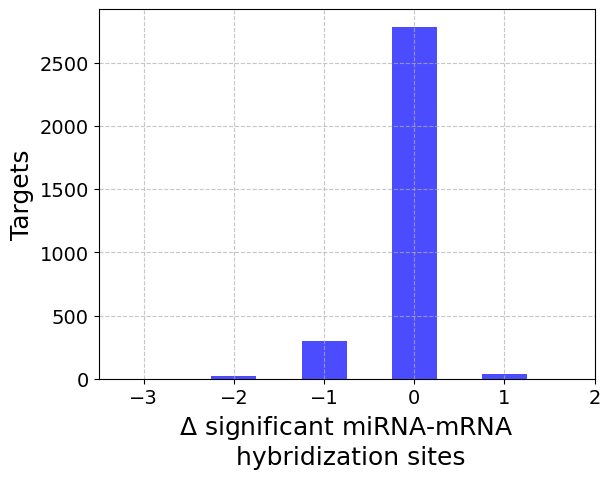

In [19]:
# get the difference between number of significant sites per target
sig_site_df = pd.concat([num_sig_sites_canonical,num_sig_sites_isomiRs],axis = 1)
sig_site_df.columns = ['Canonical', 'isomiR']
sig_site_df.index = [idx[0] for idx in sig_site_df.index.str.split('|')]

# remove all teragets with no signifianct sites and targets loast and gained by isomiRs
sig_site_df.drop(index = [idx[0] for idx in no_sig_isomiR.str.split('|')] + gained_target_isomir, inplace=True)

sig_site_df['diff'] = sig_site_df.diff(axis = 1)['isomiR']
sig_site_df.sort_values(by = 'diff', ascending=True,inplace = True)


plt.hist(sig_site_df['diff'],bins = 10, alpha=0.7, density=False, color = 'blue',align = 'left')

plt.xlabel(r'$\Delta$ significant miRNA-mRNA' '\n hybridization sites', fontsize=18)
plt.ylabel("Targets", fontsize=18)
plt.grid(True, linestyle="--", alpha=0.7, axis="both")
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

reduced_target_isomir = sig_site_df.index[sig_site_df['diff'] < 0].tolist()
increased_target_isomir = sig_site_df.index[sig_site_df['diff'] > 0].tolist()

stat, p = wilcoxon(sig_site_df['Canonical'], sig_site_df['isomiR'])
print(stat, p)

# get effect size for the wilcoxon

n = np.count_nonzero(sig_site_df['diff'])

# Compute Z statistic (normal approximation)
mean_rank = n * (n + 1) / 4
std_rank = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)
z = (stat - mean_rank) / std_rank

# Effect size r = z / sqrt(n)
effect_size_r = abs(z) / np.sqrt(n)
effect_size_r

In [16]:
sig_site_df['diff'].value_counts()

 0    2783
-1     301
 1      42
-2      23
-3       1
 2       1
Name: diff, dtype: int64

In [18]:
# test for enrichment of ALS genes (by Eitan's paper) in miRNA targets and in each lost/gain targets
# get number of ALS genes in lost/reduced or gained/increased targets
not_changed = sig_site_df.index[sig_site_df['diff'] == 0]
down_targets = pd.Series(reduced_target_isomir + lost_target_isomir)
up_targets = pd.Series(increased_target_isomir + gained_target_isomir)
total_targets = len(not_changed) + len(down_targets) + len(up_targets)

sig_overlap_ALS_genes  = sig_site_df[sig_site_df.index.isin(overlap_genes)].index


# test total enrhichmant of ALS proteins in let-7g-5p targets
chi_table =[
    [len(sig_overlap_ALS_genes),
     total_targets-len(sig_overlap_ALS_genes)],
    [ALS_genes_df.shape[0] - len(sig_overlap_ALS_genes),
     20000 - ALS_genes_df.shape[0] - (total_targets-len(sig_overlap_ALS_genes))] # all genes that are not als or miRNA targets
]

odds, p = fisher_exact(chi_table, alternative='two-sided')
print(f'Odd ratio of enrichment of ALS genes in let-7g-5p targets is {round(odds,2)} and the P-value is {round(p,2)}')

# test enrhichmant of ALS proteins in reduced/lost targets
chi_table =[
    [overlap_genes.isin(down_targets).sum(),
     len(down_targets) - overlap_genes.isin(down_targets).sum()],
    [len(sig_overlap_ALS_genes) - overlap_genes.isin(down_targets).sum(),
     total_targets - overlap_genes.isin(down_targets).sum() \
     -(len(down_targets) - overlap_genes.isin(down_targets).sum())] # all genes that are not als or miRNA targets
]

odds, p = fisher_exact(chi_table, alternative='two-sided')
print(f'Odd ratio of enrichment of ALS genes in targets lost/reduced in the  isomiR is {round(odds,2)} \nand the P-value is {round(p,2)}')

# test enrhichmant of ALS proteins in reduced/lost targets
chi_table =[
    [overlap_genes.isin(up_targets).sum(),
     len(up_targets) - overlap_genes.isin(up_targets).sum()],
    [len(sig_overlap_ALS_genes) - overlap_genes.isin(up_targets).sum(),
     total_targets - overlap_genes.isin(up_targets).sum() \
     -(len(up_targets) - overlap_genes.isin(up_targets).sum())] # all genes that are not als or miRNA targets
]

odds, p = fisher_exact(chi_table, alternative='two-sided')
print(f'Odd ratio of enrichment of ALS genes in targets gained/increased in the  isomiR is {round(odds,2)} \nand the P-value is {round(p,2)}')

Odd ratio of enrichment of ALS genes in let-7g-5p targets is 1.47 and the P-value is 0.01
Odd ratio of enrichment of ALS genes in targets lost/reduced in the  isomiR is 1.16 
and the P-value is 0.69
Odd ratio of enrichment of ALS genes in targets gained/increased in the  isomiR is 1.06 
and the P-value is 0.62


In [62]:
# run GO term enrhicmant on genes lost 

sets_to_test = ['GO_Cellular_Component_2025','GO_Molecular_Function_2025','GO_Biological_Process_2025',
               'ClinVar_2019','KEGG_2021_Human',]

results_dict = {}
for s in sets_to_test:
    results = enrichr(
        gene_list=down_targets, # up_targets[[i for i in range(48) if i != 3]].tolist()
        gene_sets=s,
        organism='Human',
        outdir=None,         # No file output
        no_plot=True         # Don’t generate plots for now
    )

    # Display top results
    results_df = results.results
    results_df = results_df[results_df['Adjusted P-value'] <= 0.05]
    results_dict[s] = results_df
results_dict

{'GO_Cellular_Component_2025': Empty DataFrame
 Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes]
 Index: [],
 'GO_Molecular_Function_2025':                      Gene_set  \
 0  GO_Molecular_Function_2025   
 1  GO_Molecular_Function_2025   
 2  GO_Molecular_Function_2025   
 3  GO_Molecular_Function_2025   
 
                                                 Term Overlap   P-value  \
 0  Phosphatidylinositol-3-Phosphate Binding (GO:0...    6/42  0.000096   
 1  Phosphatidylinositol-5-Phosphate Binding (GO:0...    4/17  0.000200   
 2  DNA-directed DNA Polymerase Activity (GO:0003887)    4/19  0.000316   
 3               DNA Polymerase Activity (GO:0034061)    4/21  0.000475   
 
    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
 0          0.035628            0                     0    9.283144   
 1          0.037058            0                     0   17.061278   
 2          0.03

In [124]:
# check let-7g-5p and isomiR bonding to ALS genes 

ALS_let_7_prediction = pd.read_table('ALS_let7_target_prediction.txt',header=None)
ALS_let_7_prediction.rename(columns = {0:'miRNA',1:'Transcript',2 : 'mRNA position',
                                   3:'Folding energy',4:'mRNA seq',5 : 'miRNA seq',
                                   8:'hybridization start', 9:'hybridization end',
                                    10 : 'P-value'}, inplace=True)

# drop columns for visual representation of base-pairing and last column fill with NaN values
ALS_let_7_prediction.drop(columns = [6,7,11], inplace=True)

ALS_let_7_prediction.index = ALS_let_7_prediction.Transcript.apply(lambda x: x.split('|')[0])
ALS_let_7_prediction['P-value'].replace({0 : 1e-6},inplace = True)
ALS_let_7_prediction.index.name = 'Gene'

# divide to canonocal and isomiR
let_7_canoncail_als = ALS_let_7_prediction[ALS_let_7_prediction.miRNA == 'hsa-let-7g-5p']
let_7_isomiR_als = ALS_let_7_prediction[ALS_let_7_prediction.miRNA != 'hsa-let-7g-5p']

# get only significance sites
let_7_canoncail_als_sig = let_7_canoncail_als[let_7_canoncail_als['P-value'] <= 0.05] 
let_7_isomiR_als_sig = let_7_isomiR_als[let_7_isomiR_als['P-value'] <= 0.05]

# calculate number of sites per target
num_sig_sites_canonical_als = let_7_canoncail_als_sig.groupby('Transcript')\
['P-value'].apply(lambda x : (x <= 0.05).sum()).sort_values(ascending=False)

num_sig_sites_isomir_als = let_7_isomiR_als_sig.groupby('Transcript')\
['P-value'].apply(lambda x : (x <= 0.05).sum()).sort_values(ascending=False)

# comapre between forms
sig_sites_als_df = pd.concat([num_sig_sites_canonical_als,
                              num_sig_sites_isomir_als],axis = 1)
sig_sites_als_df.columns = ['Canonical', 'isomiR']
sig_sites_als_df.index = [idx.split('|')[0] for idx in sig_sites_als_df.index]

# remoce unique targts for each form
als_isomir_gained = sig_sites_als_df.index[sig_sites_als_df.Canonical.isnull()]
als_isomir_lost = sig_sites_als_df.index[sig_sites_als_df.isomiR.isnull()]

sig_sites_als_df = sig_sites_als_df[~(sig_sites_als_df.Canonical.isnull() | sig_sites_als_df.isomiR.isnull())]

sig_sites_als_df['diff'] = sig_sites_als_df.diff()['isomiR']
sig_sites_als_df[sig_sites_als_df['diff'].isnull()] = 0
sig_sites_als_df.sort_values(by = 'diff', ascending=True, inplace = True)
sig_sites_als_df

Canonical  isomiR  diff
TMEM106B        9.0     7.0  -3.0
TNRC6B         13.0    11.0  -3.0
RBM33           6.0     6.0  -2.0
VPS54           2.0     1.0  -1.0
G3BP2           2.0     2.0  -1.0
...             ...     ...   ...
ATP23           4.0     4.0   1.0
GRK3            3.0     3.0   1.0
UBQLN3          3.0     4.0   1.0
ITPR2           5.0     5.0   1.0
TARBP2          3.0     3.0   1.0

[190 rows x 3 columns]

31.5 0.0004279404052894483


0.8154576712919342

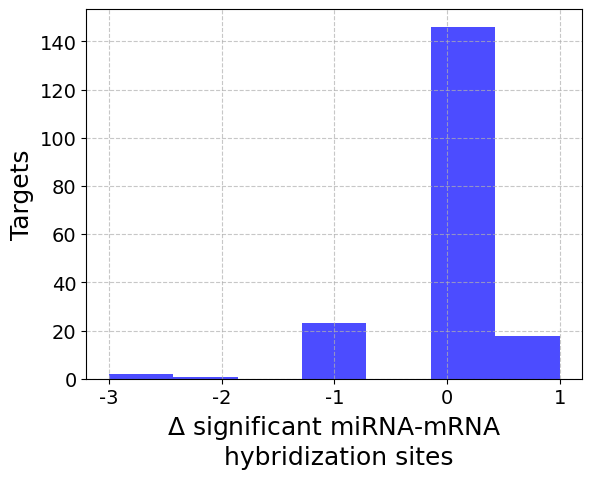

In [146]:
# plot changes histogram and calcaulte statistical difference
plt.hist(sig_sites_als_df['diff'],bins = 7, alpha=0.7, density=False, color = 'blue',align = 'mid')

plt.xlabel(r'$\Delta$ significant miRNA-mRNA' '\n hybridization sites', fontsize=18)
plt.ylabel("Targets", fontsize=18)
plt.grid(True, linestyle="--", alpha=0.7, axis="both")
plt.yticks(fontsize=14)
ticks = np.arange(-3, 2, 1)
plt.xticks(ticks,labels=[str(t) for t in ticks],fontsize=14)

reduced_target_isomir = sig_sites_als_df.index[sig_sites_als_df['diff'] < 0].tolist()
increased_target_isomir = sig_sites_als_df.index[sig_sites_als_df['diff'] > 0].tolist()

stat, p = wilcoxon(sig_sites_als_df['Canonical'], sig_sites_als_df['isomiR'])
print(stat, p)

# get effect size for the wilcoxon

n = np.count_nonzero(sig_sites_als_df['diff'])

# Compute Z statistic (normal approximation)
mean_rank = n * (n + 1) / 4
std_rank = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)
z = (stat - mean_rank) / std_rank

# Effect size r = z / sqrt(n)
effect_size_r = abs(z) / np.sqrt(n)
effect_size_r